In [ ]:
from IPython.display import clear_output
!pip install tashaphyne fasttext keras
!pip install arabic-reshaper python-bidi
clear_output()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.preprocessing import OneHotEncoder
from nltk.tokenize import word_tokenize
from tashaphyne.stemming import ArabicLightStemmer
import nltk
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
nltk.download('punkt')
drive.mount('/content/drive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from tqdm import tqdm
import fasttext
from bidi.algorithm import get_display
import arabic_reshaper

In [ ]:
dataset=pd.read_csv('/content/drive/MyDrive/SeniorProject1/data/experiment/SP2_new_training_set.csv').drop(columns=['Unnamed: 0'])
testing_set=pd.read_csv('/content/drive/MyDrive/SeniorProject1/data/experiment/SP2_new_testing_set.csv').drop(columns=['Unnamed: 0'])
dataset

Tweet     Class
0     حرصا سلامة المدنين الرجاء الجميع إكسبو دبي رجا...  negative
1     عبدالله زايد وزير خارجية الإمارات يزور الجناح ...  negative
2     بدون مبالغة تنظيم أسبوع المهندس الجامعة أيام ز...  negative
3     جناح المغرب يفوز بجائزة افضل تصميم داخلي إكسبو...  negative
4     نسلط الضوء مرة رواق ممل فارغ إكسبو دبي رواق ال...  negative
...                                                 ...       ...
7495  توقف   اختارت فرقة دبي لاستءناف جولاتها العالم...   neutral
7496  اكسبو دبي يقترب  اخبار الامارات اكسبو دبي   را...   neutral
7497                        مجموعة اصدارات جواز اكسبو     neutral
7498     محمد راشد اثناء حضوري تمرين حصن الاتحاد اكس...   neutral
7499  بهدف تعزيز التعاون دولة الامارات كندا استضافت ...   neutral

[7500 rows x 2 columns]

In [ ]:
dataset.dropna(inplace=True)

In [ ]:
def stem(text):
  text=str(text)
  stemmer=ArabicLightStemmer()
  tokens=word_tokenize(text)
  tokens
  stemmized=[]
  for t in tokens:
    stem=stemmer.light_stem(t)
    stemmized.append(stem)

  return ' '.join(stemmized)

#all_texts=pd.concat([dataset['Tweet'],testing_set['Tweet']])
all_texts=dataset['Tweet']
all_texts.apply(stem)

0       حرص سلام مدن رجاء جميع إكسب دب رجاء بق مساف اف...
1       عبدالل زايد زير خارج إمار زور جناح سور إكسب دب...
2       دون مبالغ نظيم سبوع مهندس جامع يام زم حس نظيم ...
3       جناح مغرب فوز جائز فضل صميم داخل إكسب دب جناح ...
4       سلط ضوء مرة رواق ممل رغ إكسب دب رواق جزائر اضح...
                              ...                        
7495    وقف اختار رق دب استءناف جول عالم ما سب علاق كس...
7496     كسبو دب قترب خبار امار كسبو دب رادار يوز مرا خبر
7497                                مجموع اصدار جواز كسبو
7498    محمد راشد اثناء حضور مر حص اتحاد كسبو دب مر ظه...
7499    هدف عزيز تعا دول امار ندا استضاف قنصل عام كند ...
Name: Tweet, Length: 7491, dtype: object

In [ ]:
ExpoTokenizer=Tokenizer()
ExpoTokenizer.fit_on_texts(all_texts)
# save tokenizer model
#import pickle
#with open('/content/drive/MyDrive/SeniorProject1/models/ExpoTokenizer.pickle', 'wb') as handle:
#    pickle.dump(ExpoTokenizer,handle)

# load tokenizer model
#with open('/content/drive/MyDrive/SeniorProject1/models/ExpoTokenizer.pickle', 'rb') as handle:
#    ExpoTokenizer = pickle.load(handle)
print("Number of total vocabulary of train and test =",len(ExpoTokenizer.word_index))

Number of total vocabulary of train and test = 25291


In [ ]:
onehotencoder=OneHotEncoder().fit(np.array(dataset['Class']).reshape(-1,1))

In [ ]:
sents_len=[]
for text in dataset['Tweet']:
  tokens=word_tokenize(text)
  sents_len.append(len(tokens))


#highest 2 sequence len
sorted(sents_len,reverse=True)[:2]

[44, 44]

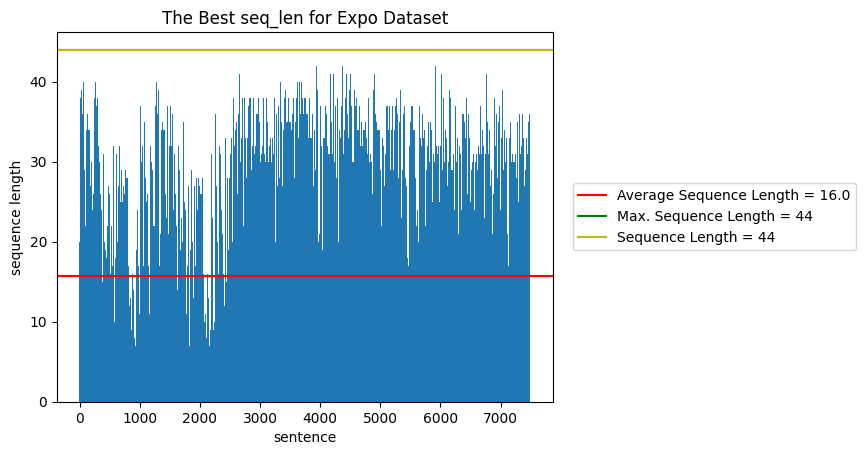

In [ ]:
plt.bar(range(len(sents_len)),sents_len,width=10)
plt.ylabel('sequence length')
plt.xlabel('sentence')
plt.axhline(y=np.mean(sents_len), color='r',label=f'Average Sequence Length = {np.mean(sents_len).round()}')
plt.axhline(y=max(sents_len), color='g',label=f'Max. Sequence Length = {max(sents_len)}')
plt.axhline(y=44, color='y',label='Sequence Length = 44')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.title('The Best seq_len for Expo Dataset')
plt.show()

### Dataset Construction

In [ ]:
class ExpoDataset(Dataset):
  def __init__(self,df,tokenizer,onehotencoder,max_len=44):
    self.text=df['Tweet'].apply(self.stem)
    self.tokenizer=tokenizer
    #self.tokenizer.fit_on_texts(self.text)
    self.text=self.tokenizer.texts_to_sequences(self.text)
    self.text=pad_sequences(self.text,maxlen=max_len)
    self.df=df['Class']
    self.df=onehotencoder.fit_transform(np.array(self.df).reshape(-1,1)).toarray()

  def stem(self, text):
    stemmer=ArabicLightStemmer()
    tokens=word_tokenize(text)
    tokens
    stemmized=[]
    for t in tokens:
      stem=stemmer.light_stem(t)
      stemmized.append(stem)

    return ' '.join(stemmized)

  def __len__(self):
    return len(self.df)
  def __getitem__(self,idx):
    text=self.text[idx]
    label=self.df[idx]
    return text,label

In [ ]:
expo_dataset=ExpoDataset(dataset,ExpoTokenizer,onehotencoder,44)
expo_dataset[0]

(array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,  2340,  5381,
         2937, 23758,  2937, 24406,  1182,   271,  3643,  2111],
       dtype=int32),
 array([1., 0., 0.]))

In [ ]:
len(expo_dataset.tokenizer.word_index)

25291

In [ ]:
seed = torch.Generator().manual_seed(42)
train_set,val_set=torch.utils.data.random_split(expo_dataset,[0.85,0.15], generator=seed)
len(train_set),len(val_set)

(6368, 1123)

In [ ]:
full_dataloader=DataLoader(expo_dataset,batch_size=64,shuffle=True)
train_loader=DataLoader(train_set,batch_size=64,shuffle=True)
val_loader=DataLoader(val_set,batch_size=64,shuffle=False)

In [ ]:
test_loader=DataLoader(ExpoDataset(testing_set,ExpoTokenizer,onehotencoder),batch_size=64,shuffle=False)

# Models

 **FastText Embeddings**

In [ ]:
#Load the Arabic Fasttext model
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ar.300.bin.gz
!gunzip cc.ar.300.bin.gz

--2024-10-15 20:31:05--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ar.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.25, 13.226.210.111, 13.226.210.15, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4500982519 (4.2G) [application/octet-stream]
Saving to: ‘cc.ar.300.bin.gz’

cc.ar.300.bin.gz    100%[===================>]   4.19G   198MB/s    in 33s     

2024-10-15 20:31:38 (129 MB/s) - ‘cc.ar.300.bin.gz’ saved [4500982519/4500982519]



In [ ]:
# Extract the Model Embeddings
#model = fasttext.load_model("cc.ar.300.bin")
#fasttext_weights=np.zeros((len(expo_dataset.tokenizer.word_index)+1,model.get_dimension()))
#for word, index in tqdm(expo_dataset.tokenizer.word_index.items()):
#    fasttext_weights[index]=model.get_word_vector(word)

#np.save('/content/drive/MyDrive/SeniorProject1/models/fasttext_embeddings.npy',fasttext_weights)

In [ ]:
#np.save('/content/drive/MyDrive/SeniorProject1/models/fasttext_embeddings.npy',fasttext_weights)

In [ ]:
# Re-Load the fasttext_weights (you can find it in the project google drive)
fasttext_weights=np.load('/content/drive/MyDrive/SeniorProject1/models/fasttext_embeddings.npy')

In [ ]:
print('The embedding shape = ',fasttext_weights.shape)

The embedding shape =  (25292, 300)


### DL models

In [ ]:
class GRU(nn.Module):
  def __init__(self,fasttext_weights,hidden_size1,hidden_size2,freeze_embedding=True,droprate=0.5,num_layers=1,num_classes=3,dider=True):
    super(GRU,self).__init__()
    self.embedding=nn.Embedding.from_pretrained(torch.FloatTensor(fasttext_weights),freeze=freeze_embedding)
    self.gru=nn.GRU(self.embedding.embedding_dim,hidden_size1,num_layers,batch_first=True,bidirectional=dider)
    self.dropout=nn.Dropout(droprate)
    self.d=2 if dider else 1
    self.fc1=nn.Linear(hidden_size1*self.d,hidden_size2)
    self.fc2=nn.Linear(hidden_size2,num_classes)

  def forward(self,x):
    x=self.embedding(x)
    x,h=self.gru(x)
    x=self.fc1(x[:,-1,:])
    x=F.relu(x)
    x=self.dropout(x)
    x=self.fc2(x)
    return x

In [ ]:
def visualize(text_ids,weights,predictions,labels):

  positives_weights = weights[labels == 2]
  negatives_weights = weights[labels == 0]
  neutrals_weights = weights[labels == 1]

  positives_text_ids = text_ids[labels == 2]
  negatives_text_ids = text_ids[labels == 0]
  neutrals_text_ids = text_ids[labels == 1]

  # Randomly selecting indices for each class
  positive_indices = np.random.choice(np.arange(len(positives_weights)), size=1)
  negative_indices = np.random.choice(np.arange(len(negatives_weights)), size=1)
  neutral_indices = np.random.choice(np.arange(len(neutrals_weights)), size=1)

  fig, axs = plt.subplots(3, figsize=(10, 6))
  #axs = [axs]  # Ensure axs is iterable if there's only one plot
  #print('axs=',type(axs[0]),axs[0])
  # Function to plot heatmaps for a given class
  def plot_heatmaps(indecies, text_ids_, weights_, ax_row):
      for index in indecies:
          num_paddings=sum(text_ids_[index]==0)
          text = " ".join(ExpoTokenizer.sequences_to_texts([text_ids_[index]])).split(' ')
          reshaped_text = [arabic_reshaper.reshape(token) for token in text]
          bidi_text = (['[PAD]']*num_paddings)+[get_display(token) for token in reshaped_text]
          correct_weight = weights_[index]

          # Create the heatmap for the current index
          heatmap = axs[ax_row].imshow([correct_weight], cmap='YlGnBu', aspect='auto')

          # Set the tokens as x-ticks
          axs[ax_row].set_xticks(np.arange(len(bidi_text)))
          axs[ax_row].set_xticklabels(bidi_text, rotation=90)

          # Remove y-ticks
          axs[ax_row].set_yticks([])
      plt.tight_layout()
      return heatmap

  # Plot heatmaps for positive, negative, and neutral predictions
  heatmap=plot_heatmaps(negative_indices, negatives_text_ids, negatives_weights, 0)  # Row 0 for negative
  heatmap=plot_heatmaps(neutral_indices, neutrals_text_ids, neutrals_weights, 1)  # Row 1 for neutral
  heatmap=plot_heatmaps(positive_indices, positives_text_ids, positives_weights, 2)     # Row 2 for positive

  # Set overall titles for each row
  axs[0].set_ylabel('Negative', rotation=0, labelpad=50, fontsize=12)
  axs[1].set_ylabel('Neutral', rotation=0, labelpad=50, fontsize=12)
  axs[2].set_ylabel('Positive', rotation=0, labelpad=50, fontsize=12)

  # Create a single color bar for the entire figure
  cbar_ax = fig.add_axes([1, 0.15, 0.01, 0.8])  # [left, bottom, width, height]
  plt.colorbar(heatmap, cax=cbar_ax)

  plt.suptitle('Attention Weights', fontsize=16, x=0.5, y=1.02)  # Adjust the y-position for the title
  #plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for the title
  plt.show()

In [ ]:
#helper function to automate the loss and accuracy plots
def plot_loss_accuracy(train_total_loss, val_total_loss, train_accuracies, val_accuracies):
    plt.subplots(figsize=(12, 4))

    plt.subplot(121)
    plt.plot(train_total_loss, label='train')
    if len(val_total_loss) != 0:
        plt.plot(val_total_loss, label='val')
    plt.title('Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(122)
    plt.plot(train_accuracies, label='train')
    if len(val_accuracies) != 0:
        plt.plot(val_accuracies, label='val')
    plt.title('Accuracies')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [ ]:
# Test on the test_loader
def test_and_report(model,test_loader,model_name,attention_added=False):
  model.eval()
  predictions=[]
  labels=[]
  test_total_dataitem=0
  test_correct=0
  input_ids_list=[]
  attention_weights=[]
  correct_answers=[]
  all_labels=[]
  with torch.no_grad():
      for batch in test_loader:
          text,label=batch[0].to(device),batch[1].to(device)
          output=model(text)
          if attention_added:
            attention_weights.extend(output[1].cpu().numpy())
            output=output[0]



          # Compute the accuracy
          y_pred=F.softmax(output,dim=1)
          predicted = y_pred.argmax(axis=1)
          test_total_dataitem += label.size(0)
          test_correct += (predicted == label.argmax(axis=1)).sum()
          predictions.extend(predicted.cpu().numpy())
          labels.extend(label.argmax(axis=1).cpu().numpy())
          input_ids_list.extend(text.cpu().numpy())
          all_labels.extend(label.argmax(axis=1).cpu().numpy())
          correct_answers.extend((predicted == label.argmax(axis=1)).cpu().numpy())


  test_accuracy = test_correct/test_total_dataitem
  print(f'Test correct = {test_correct}\n')
  print(f'Test total dataitem = {test_total_dataitem}\n')
  print(f'Test Accuracy = {test_accuracy}\n')
  print(classification_report(labels,predictions,target_names=['negative','neutral','positive']))
  fig,ax=plt.subplots(figsize=(5, 5))
  ConfusionMatrixDisplay.from_predictions(labels,predictions,display_labels=['negative','neutral','positive'],normalize='pred',cmap=plt.cm.Blues, xticks_rotation='vertical',ax=ax)
  plt.title(f'Confusion Matrix of {model_name}')
  plt.show()
  if attention_added:
    visualize(np.array(input_ids_list),np.array(attention_weights),correct_answers,np.array(all_labels))

In [ ]:
#helper function to automate the training loop
def train(model,epochs,optimizer,criterion,train_loader,val_loader=None,attention_added=False):
  train_total_loss=[]
  val_total_loss=[]
  train_accuracies=[]
  val_accuracies=[]
  for epoch in range(epochs):
    train_losses=0
    val_losses=0
    train_total_dataitem=0
    train_correct=0
    tqdm_par=tqdm(train_loader,desc=f'Epoch {epoch+1}')
    #tqdm_par.set_description(f'Epoch {epoch+1}')
    model.train() #training mode
    for batch in tqdm_par:
      text,label=batch[0].to(device),batch[1].to(device)
      output=model(text)
      if attention_added:
        output=output[0]
      train_loss=criterion(output,label)
      optimizer.zero_grad()
      train_losses+=train_loss.item()
      train_loss.backward()
      optimizer.step()
      # Compute the accuracy
      y_pred=F.softmax(output,dim=1)
      predicted = y_pred.argmax(axis=1)
      train_total_dataitem += label.size(0)
      train_correct += (predicted == label.argmax(axis=1)).sum()
    train_accuracy = train_correct / train_total_dataitem

    if val_loader:
      model.eval() #evaluation mode
      with torch.no_grad():
        val_total_dataitem=0
        val_correct=0
        for batch in val_loader:
          text,label=batch[0].to(device),batch[1].to(device)
          output=model(text)
          if attention_added:
            output=output[0]
          val_loss=criterion(output,label)
          val_losses+=val_loss.item()
          # Compute the accuracy
          y_pred=F.softmax(output,dim=1)
          predicted = y_pred.argmax(axis=1)
          val_total_dataitem += label.size(0)
          val_correct += (predicted == label.argmax(axis=1)).sum()
        val_accuracy = val_correct/val_total_dataitem

    tqdm_par.refresh()
    train_total_loss.append(train_losses/len(train_loader))
    train_accuracies.append(train_accuracy.cpu())
    if val_loader:
      val_total_loss.append(val_losses/len(val_loader))
      val_accuracies.append(val_accuracy.cpu())
      print(f'loss = {train_losses/len(train_loader)}, val_loss ={val_losses/len(val_loader)}, accuracy = {train_accuracy}, val_accuracy = {val_accuracy}')
    else:
      print(f'loss = {train_losses/len(train_loader)}, accuracy = {train_accuracy}')

  plot_loss_accuracy(train_total_loss,val_total_loss,train_accuracies,val_accuracies)

You're on a cuda


Epoch 1: 100%|██████████| 100/100 [00:02<00:00, 47.39it/s]


loss = 1.0974259083624929, val_loss =1.0952877990724075, accuracy = 0.34013819694519043, val_accuracy = 0.3223508596420288


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 236.80it/s]


loss = 1.085043165292591, val_loss =1.0790396197004215, accuracy = 0.42949119210243225, val_accuracy = 0.4835262894630432


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 246.72it/s]


loss = 1.0568155300524085, val_loss =1.029563685867285, accuracy = 0.5284233689308167, val_accuracy = 0.5485307574272156


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 233.73it/s]


loss = 0.9724318986936124, val_loss =0.913007921292003, accuracy = 0.5752198696136475, val_accuracy = 0.5983971357345581


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 235.36it/s]


loss = 0.8788880414573942, val_loss =0.844081935302506, accuracy = 0.6209170818328857, val_accuracy = 0.6233303546905518


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 235.62it/s]


loss = 0.816298455850474, val_loss =0.8028326931080618, accuracy = 0.6507537364959717, val_accuracy = 0.6455921530723572


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 245.27it/s]


loss = 0.7908766531727451, val_loss =0.7920342921728863, accuracy = 0.666614294052124, val_accuracy = 0.6482635736465454


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 242.70it/s]


loss = 0.7638096173258782, val_loss =0.7686491584926862, accuracy = 0.6719534993171692, val_accuracy = 0.6589492559432983


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 244.69it/s]


loss = 0.7470907353072834, val_loss =0.7592748474023427, accuracy = 0.6931532621383667, val_accuracy = 0.666963517665863


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 252.07it/s]
<ipython-input-24-a92860fd3f0c>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.7356952895011273, val_loss =0.7556992812752252, accuracy = 0.6934673190116882, val_accuracy = 0.6625111699104309


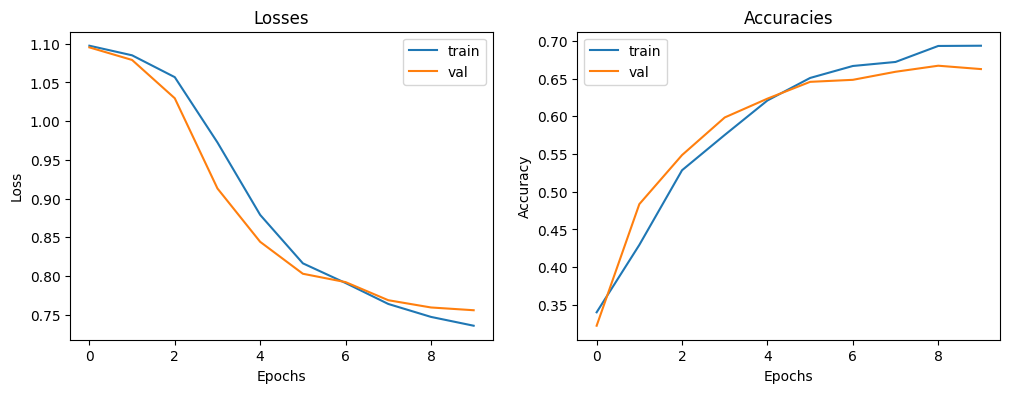

Test correct = 469

Test total dataitem = 750

Test Accuracy = 0.625333309173584

              precision    recall  f1-score   support

    negative       0.62      0.70      0.66       250
     neutral       0.60      0.69      0.64       250
    positive       0.67      0.48      0.56       250

    accuracy                           0.63       750
   macro avg       0.63      0.63      0.62       750
weighted avg       0.63      0.63      0.62       750



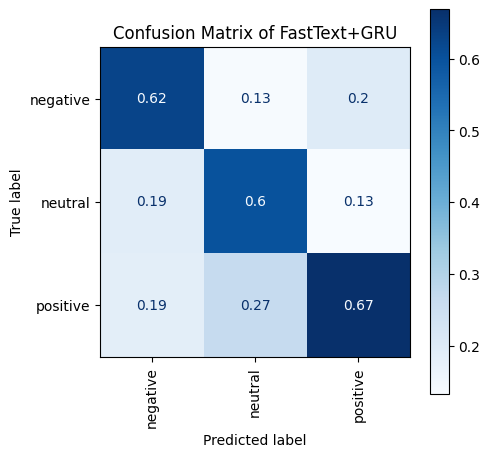

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"You're on a {device}")
#hyperparameter
hidden_size1=128
hidden_size2=64
num_layers=1
bidirectional=True
freeze_embedding=True
droprate=0.5
learning_rate=0.0001
epoch=10
model=GRU(fasttext_weights,hidden_size1,hidden_size2,freeze_embedding,droprate,num_layers,dider=bidirectional).to(device)
optimizer=optim.Adam(model.parameters(),lr=learning_rate) # play around this also
criterion=nn.CrossEntropyLoss()
train(model,epoch,optimizer,criterion,train_loader,val_loader)
model_name='FastText+GRU'
test_and_report(model,test_loader,model_name)

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 158.95it/s]


loss = 1.0966130020469427, val_loss =1.0905245876176253, accuracy = 0.33825376629829407, val_accuracy = 0.35886019468307495


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 169.71it/s]


loss = 1.0841424075327815, val_loss =1.0739870105796152, accuracy = 0.4123743772506714, val_accuracy = 0.5004452466964722


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 185.30it/s]


loss = 1.049914214303717, val_loss =1.0105403055680826, accuracy = 0.5040829181671143, val_accuracy = 0.4995547831058502


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 250.83it/s]


loss = 0.9710458908521105, val_loss =0.9391926718077488, accuracy = 0.5337625741958618, val_accuracy = 0.5547640323638916


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 243.82it/s]


loss = 0.9090984284284059, val_loss =0.8997970620303283, accuracy = 0.5789886713027954, val_accuracy = 0.5734639763832092


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 246.43it/s]


loss = 0.8650120907786186, val_loss =0.8531841535432567, accuracy = 0.6047424674034119, val_accuracy = 0.6179875731468201


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 243.96it/s]


loss = 0.8198975011274888, val_loss =0.8140189835178067, accuracy = 0.6363065242767334, val_accuracy = 0.6375779509544373


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 238.46it/s]


loss = 0.7867617057245115, val_loss =0.7855526236995559, accuracy = 0.652952253818512, val_accuracy = 0.6536064147949219


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 249.77it/s]


loss = 0.754753569015229, val_loss =0.7790549288504287, accuracy = 0.6714823842048645, val_accuracy = 0.6544969081878662


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 236.82it/s]
<ipython-input-24-a92860fd3f0c>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.7314380041383174, val_loss =0.7508815633219672, accuracy = 0.6860866546630859, val_accuracy = 0.6625111699104309


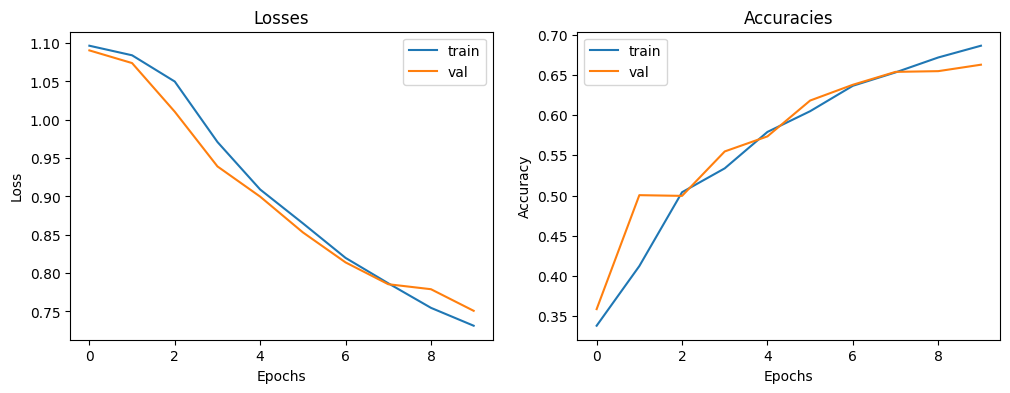

bidirectional = True
Test correct = 460

Test total dataitem = 750

Test Accuracy = 0.6133333444595337

              precision    recall  f1-score   support

    negative       0.62      0.70      0.66       250
     neutral       0.61      0.64      0.63       250
    positive       0.61      0.49      0.54       250

    accuracy                           0.61       750
   macro avg       0.61      0.61      0.61       750
weighted avg       0.61      0.61      0.61       750



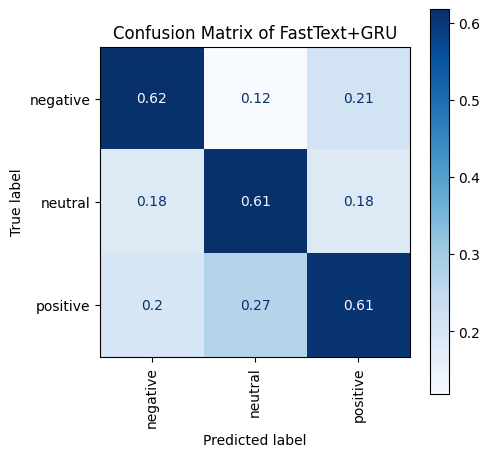

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 288.93it/s]


loss = 1.0953128777910024, val_loss =1.0925321101684065, accuracy = 0.3781406879425049, val_accuracy = 0.4016028642654419


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 304.42it/s]


loss = 1.0849758373945952, val_loss =1.0759773116174436, accuracy = 0.4406406879425049, val_accuracy = 0.48441675305366516


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 275.23it/s]


loss = 1.0478590588411316, val_loss =0.995738301598393, accuracy = 0.5150753855705261, val_accuracy = 0.5244879722595215


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 292.29it/s]


loss = 0.9535115516535007, val_loss =0.9060281023032046, accuracy = 0.5478957295417786, val_accuracy = 0.5761353373527527


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 296.36it/s]


loss = 0.8958013714657863, val_loss =0.8664982078347488, accuracy = 0.5899811387062073, val_accuracy = 0.6126447319984436


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 293.47it/s]


loss = 0.8597403657560062, val_loss =0.8373726369573786, accuracy = 0.6070979833602905, val_accuracy = 0.6179875731468201


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 295.67it/s]


loss = 0.8338325945171527, val_loss =0.8155456376322988, accuracy = 0.6309673190116882, val_accuracy = 0.6277827620506287


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 291.48it/s]


loss = 0.8007983171343949, val_loss =0.796488104693939, accuracy = 0.645100474357605, val_accuracy = 0.6438112258911133


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 292.92it/s]


loss = 0.7770420639928488, val_loss =0.7695262433595157, accuracy = 0.6601758599281311, val_accuracy = 0.6491540670394897


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 302.60it/s]
<ipython-input-24-a92860fd3f0c>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.7517665441185454, val_loss =0.7744379338377344, accuracy = 0.6779208183288574, val_accuracy = 0.6527159810066223


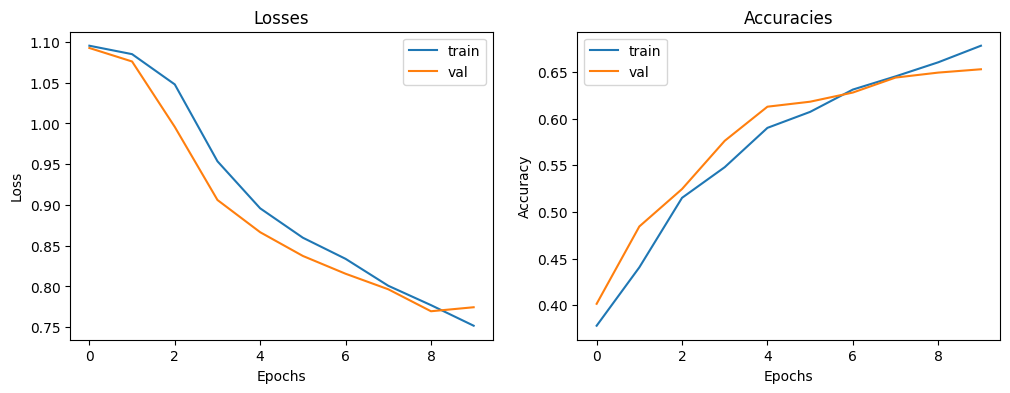

bidirectional = False
Test correct = 449

Test total dataitem = 750

Test Accuracy = 0.5986666679382324

              precision    recall  f1-score   support

    negative       0.70      0.54      0.61       250
     neutral       0.56      0.66      0.61       250
    positive       0.57      0.60      0.58       250

    accuracy                           0.60       750
   macro avg       0.61      0.60      0.60       750
weighted avg       0.61      0.60      0.60       750



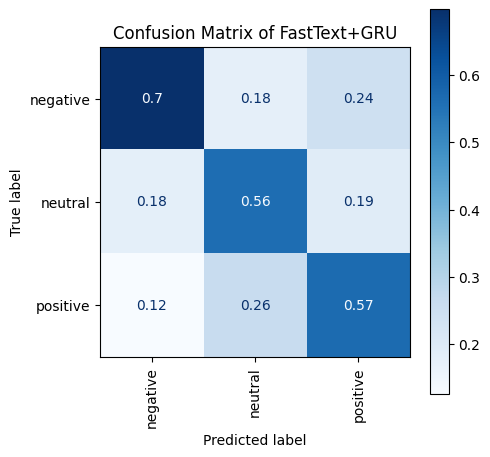

In [ ]:
# Experiment 1
# hyperparameter
bidirectional_options = [True, False]
for bidirectional1 in bidirectional_options:
  model=GRU(fasttext_weights,hidden_size1,hidden_size2,freeze_embedding,droprate,num_layers,dider=bidirectional1).to(device)  # Correct instantiation of the GRU class
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  train(model, epoch, optimizer, criterion, train_loader, val_loader)
  model_name = 'FastText+GRU'
  print(f'bidirectional = {bidirectional1}')
  test_and_report(model, test_loader, model_name)

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 195.28it/s]


loss = 1.095515722716227, val_loss =1.0913234651591333, accuracy = 0.3767273724079132, val_accuracy = 0.44078361988067627


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 240.08it/s]


loss = 1.081528551839292, val_loss =1.0735854098735937, accuracy = 0.46592336893081665, val_accuracy = 0.5022261738777161


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 244.50it/s]


loss = 1.040999784450978, val_loss =0.9958894639054225, accuracy = 0.5144472122192383, val_accuracy = 0.5155832767486572


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 238.21it/s]


loss = 0.9488424800685606, val_loss =0.9236093667047542, accuracy = 0.5617148280143738, val_accuracy = 0.5583259463310242


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 246.58it/s]


loss = 0.8783830704877619, val_loss =0.8519146726936072, accuracy = 0.5986180901527405, val_accuracy = 0.6295636892318726


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 236.10it/s]


loss = 0.825359953067673, val_loss =0.8198602334684915, accuracy = 0.6394472122192383, val_accuracy = 0.6340160369873047


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 241.54it/s]


loss = 0.7863563977755257, val_loss =0.7850464253543159, accuracy = 0.658134400844574, val_accuracy = 0.651825487613678


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 234.59it/s]


loss = 0.7585507925049023, val_loss =0.7777869787454301, accuracy = 0.6755653023719788, val_accuracy = 0.6500445604324341


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 244.45it/s]


loss = 0.7391557607272625, val_loss =0.7526490909082535, accuracy = 0.6853014826774597, val_accuracy = 0.6634016036987305


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 225.26it/s]
<ipython-input-24-a92860fd3f0c>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.7231058551397563, val_loss =0.7502115775133937, accuracy = 0.6951947212219238, val_accuracy = 0.6705253720283508


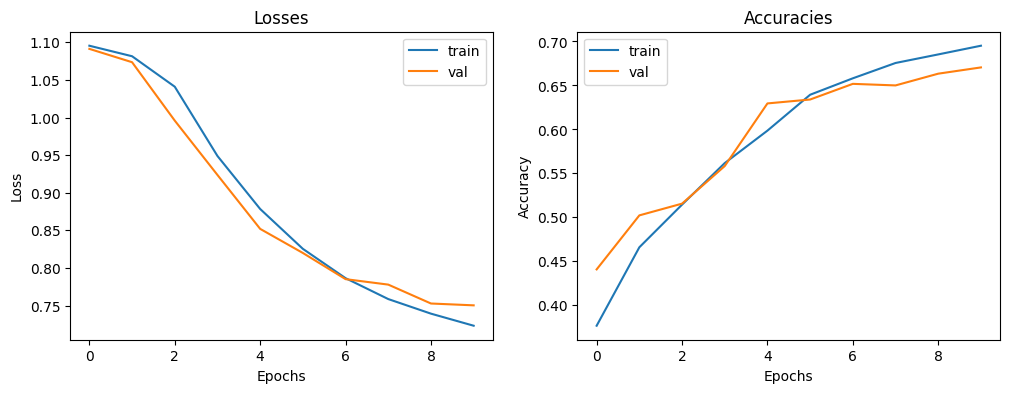

gru_layers = 1
Test correct = 474

Test total dataitem = 750

Test Accuracy = 0.6319999694824219

              precision    recall  f1-score   support

    negative       0.67      0.64      0.65       250
     neutral       0.65      0.62      0.63       250
    positive       0.58      0.64      0.61       250

    accuracy                           0.63       750
   macro avg       0.63      0.63      0.63       750
weighted avg       0.63      0.63      0.63       750



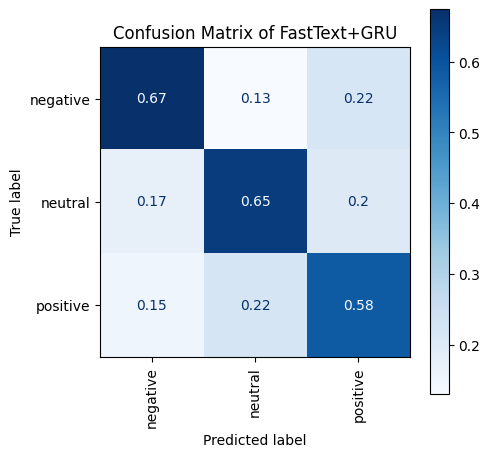

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 166.63it/s]


loss = 1.0940053462423385, val_loss =1.0864866055976894, accuracy = 0.3806532621383667, val_accuracy = 0.49243101477622986


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 163.89it/s]


loss = 1.0571621948853136, val_loss =0.9927914925695708, accuracy = 0.4982725977897644, val_accuracy = 0.5529831051826477


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 172.33it/s]


loss = 0.9115294369118055, val_loss =0.8427273135659994, accuracy = 0.5816583037376404, val_accuracy = 0.6064113974571228


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 164.69it/s]


loss = 0.8000195500432165, val_loss =0.7836271477789278, accuracy = 0.651067852973938, val_accuracy = 0.6473731398582458


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 165.05it/s]


loss = 0.7632098985792254, val_loss =0.7622124596139498, accuracy = 0.6714823842048645, val_accuracy = 0.6607301831245422


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 166.13it/s]


loss = 0.7402275098963582, val_loss =0.7463169979420305, accuracy = 0.6885992288589478, val_accuracy = 0.6740872859954834


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 154.83it/s]


loss = 0.7140989002667629, val_loss =0.7340699468791071, accuracy = 0.7017902135848999, val_accuracy = 0.6758682131767273


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 125.28it/s]


loss = 0.698895776358695, val_loss =0.7268331466151202, accuracy = 0.7162374258041382, val_accuracy = 0.6821015477180481


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 127.14it/s]


loss = 0.6901282180234921, val_loss =0.7139693114078245, accuracy = 0.7181218266487122, val_accuracy = 0.6918967366218567


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 121.51it/s]
<ipython-input-24-a92860fd3f0c>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.672909615589333, val_loss =0.7122739894044426, accuracy = 0.7218906879425049, val_accuracy = 0.6918967366218567


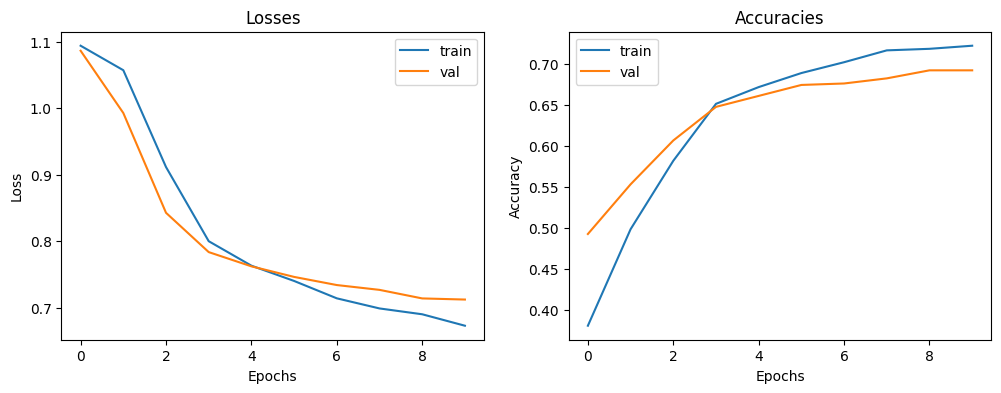

gru_layers = 2
Test correct = 468

Test total dataitem = 750

Test Accuracy = 0.6240000128746033

              precision    recall  f1-score   support

    negative       0.69      0.59      0.63       250
     neutral       0.61      0.68      0.64       250
    positive       0.59      0.60      0.59       250

    accuracy                           0.62       750
   macro avg       0.63      0.62      0.62       750
weighted avg       0.63      0.62      0.62       750



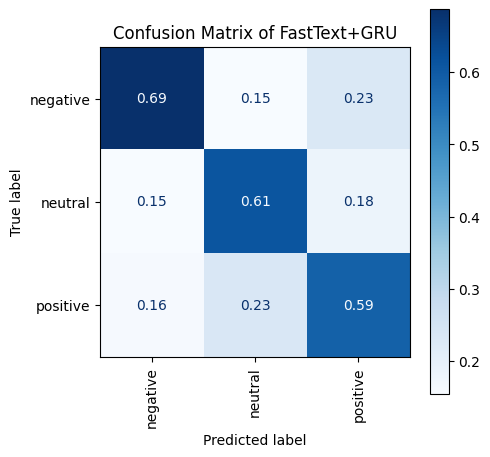

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 115.53it/s]


loss = 1.0940935192350298, val_loss =1.0797734074708487, accuracy = 0.3684045076370239, val_accuracy = 0.4755120277404785


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 118.01it/s]


loss = 1.0019139112136326, val_loss =0.8793727645136801, accuracy = 0.5210427045822144, val_accuracy = 0.6064113974571228


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 120.96it/s]


loss = 0.8485735854847007, val_loss =0.8081200111877277, accuracy = 0.6188756227493286, val_accuracy = 0.6429207921028137


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 121.55it/s]


loss = 0.7843973645770166, val_loss =0.7764894921869402, accuracy = 0.660804033279419, val_accuracy = 0.6553874015808105


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 121.41it/s]


loss = 0.7432395480544437, val_loss =0.7577565409145169, accuracy = 0.6871859431266785, val_accuracy = 0.6562778353691101


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 119.93it/s]


loss = 0.7250921594238026, val_loss =0.7515684608760426, accuracy = 0.6984924674034119, val_accuracy = 0.6607301831245422


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 120.86it/s]


loss = 0.6974714851087629, val_loss =0.7310018879566794, accuracy = 0.7143530249595642, val_accuracy = 0.677649199962616


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 121.43it/s]


loss = 0.6849001780830803, val_loss =0.7453653907177449, accuracy = 0.7157663106918335, val_accuracy = 0.6714158654212952


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 122.54it/s]


loss = 0.6667744478193072, val_loss =0.7203488291530188, accuracy = 0.7259736061096191, val_accuracy = 0.6821015477180481


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 121.48it/s]
<ipython-input-24-a92860fd3f0c>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.6602449863125912, val_loss =0.724132327341275, accuracy = 0.7355527281761169, val_accuracy = 0.6865538954734802


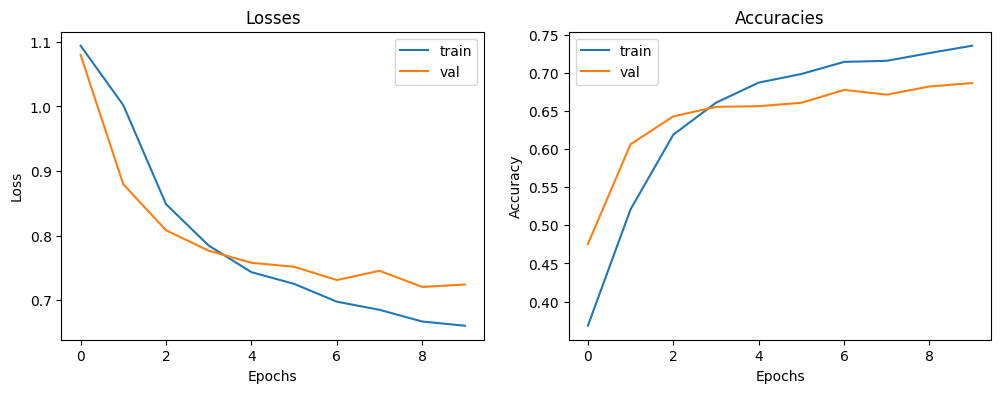

gru_layers = 3
Test correct = 480

Test total dataitem = 750

Test Accuracy = 0.6399999856948853

              precision    recall  f1-score   support

    negative       0.63      0.73      0.68       250
     neutral       0.64      0.62      0.63       250
    positive       0.66      0.56      0.61       250

    accuracy                           0.64       750
   macro avg       0.64      0.64      0.64       750
weighted avg       0.64      0.64      0.64       750



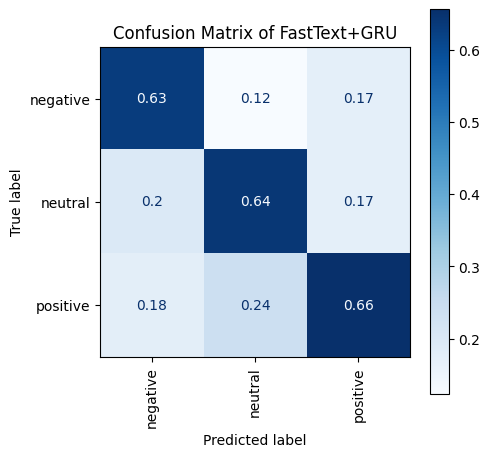

Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 78.94it/s]


loss = 1.0949195495899766, val_loss =1.0781094822500432, accuracy = 0.3680904507637024, val_accuracy = 0.4674977958202362


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 77.71it/s]


loss = 0.99161611889489, val_loss =0.926855485103581, accuracy = 0.4872801601886749, val_accuracy = 0.5057880878448486


Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 76.74it/s]


loss = 0.8954161122301594, val_loss =0.8535416384767149, accuracy = 0.5596733689308167, val_accuracy = 0.6055209636688232


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 93.27it/s]


loss = 0.8249545256185229, val_loss =0.7950090263910141, accuracy = 0.6286118030548096, val_accuracy = 0.6375779509544373


Epoch 5: 100%|██████████| 100/100 [00:01<00:00, 94.23it/s]


loss = 0.7627878167966264, val_loss =0.7586417873632089, accuracy = 0.6703831553459167, val_accuracy = 0.6616206765174866


Epoch 6: 100%|██████████| 100/100 [00:01<00:00, 95.78it/s]


loss = 0.7275050540476513, val_loss =0.7337092304762105, accuracy = 0.6967650651931763, val_accuracy = 0.6749777793884277


Epoch 7: 100%|██████████| 100/100 [00:01<00:00, 95.72it/s]


loss = 0.7065100380923104, val_loss =0.7281944951073485, accuracy = 0.7049309015274048, val_accuracy = 0.6785396337509155


Epoch 8: 100%|██████████| 100/100 [00:01<00:00, 96.04it/s]


loss = 0.6863686657170911, val_loss =0.7167885125396194, accuracy = 0.7162374258041382, val_accuracy = 0.6821015477180481


Epoch 9: 100%|██████████| 100/100 [00:01<00:00, 95.70it/s]


loss = 0.6653134113779743, val_loss =0.7095848028487545, accuracy = 0.722047746181488, val_accuracy = 0.6936776638031006


Epoch 10: 100%|██████████| 100/100 [00:01<00:00, 95.71it/s]
<ipython-input-24-a92860fd3f0c>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.6539653235115839, val_loss =0.7136211025558638, accuracy = 0.7311557531356812, val_accuracy = 0.6927871704101562


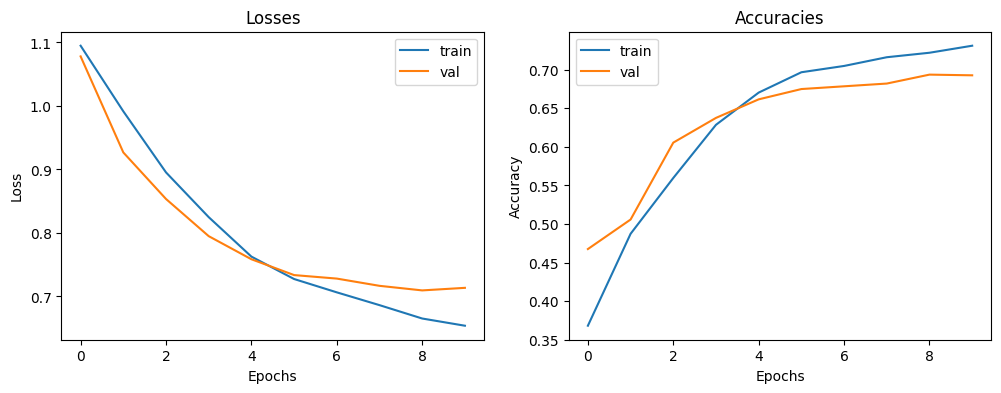

gru_layers = 4
Test correct = 468

Test total dataitem = 750

Test Accuracy = 0.6240000128746033

              precision    recall  f1-score   support

    negative       0.63      0.70      0.67       250
     neutral       0.59      0.65      0.62       250
    positive       0.66      0.52      0.58       250

    accuracy                           0.62       750
   macro avg       0.63      0.62      0.62       750
weighted avg       0.63      0.62      0.62       750



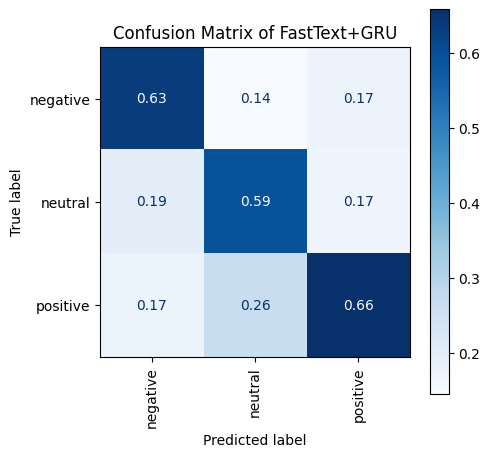

In [ ]:
bidirectional=True
gru_layers=[1,2,3,4]
for gru_layer in gru_layers:
  model=GRU(fasttext_weights,hidden_size1,hidden_size2,freeze_embedding,droprate,gru_layer,dider=bidirectional).to(device)
  optimizer=optim.Adam(model.parameters(),lr=learning_rate)
  train(model,epoch,optimizer,criterion,train_loader,val_loader)
  model_name='FastText+GRU'
  print(f'gru_layers = {gru_layer}')
  test_and_report(model,test_loader,model_name)

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 179.13it/s]


loss = 1.0989818485919387, val_loss =1.0968686221670063, accuracy = 0.34060928225517273, val_accuracy = 0.4096170961856842


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 123.98it/s]


loss = 1.094664847496897, val_loss =1.0911477204175695, accuracy = 0.37782663106918335, val_accuracy = 0.44256457686424255


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 128.22it/s]


loss = 1.0827604935783892, val_loss =1.0689775749686217, accuracy = 0.43938443064689636, val_accuracy = 0.49421194195747375


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 124.49it/s]


loss = 1.0389402542775497, val_loss =0.994850772183152, accuracy = 0.4842964708805084, val_accuracy = 0.5431879162788391


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 119.71it/s]


loss = 0.9521913905872498, val_loss =0.9065743900883558, accuracy = 0.5307788848876953, val_accuracy = 0.5601068735122681


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 137.44it/s]


loss = 0.8972998171742074, val_loss =0.8956426408518815, accuracy = 0.5596733689308167, val_accuracy = 0.5654497146606445


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 187.63it/s]


loss = 0.864823492889991, val_loss =0.8520279553997893, accuracy = 0.5865263938903809, val_accuracy = 0.5983971357345581


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 185.90it/s]


loss = 0.8431666819009115, val_loss =0.8294563705940539, accuracy = 0.6072550415992737, val_accuracy = 0.6206589937210083


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 187.87it/s]


loss = 0.8170520895709342, val_loss =0.8095005596902901, accuracy = 0.6271984577178955, val_accuracy = 0.6251113414764404


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 186.42it/s]
<ipython-input-24-a92860fd3f0c>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.7921485941240098, val_loss =0.7981547485809729, accuracy = 0.6480841636657715, val_accuracy = 0.6251113414764404


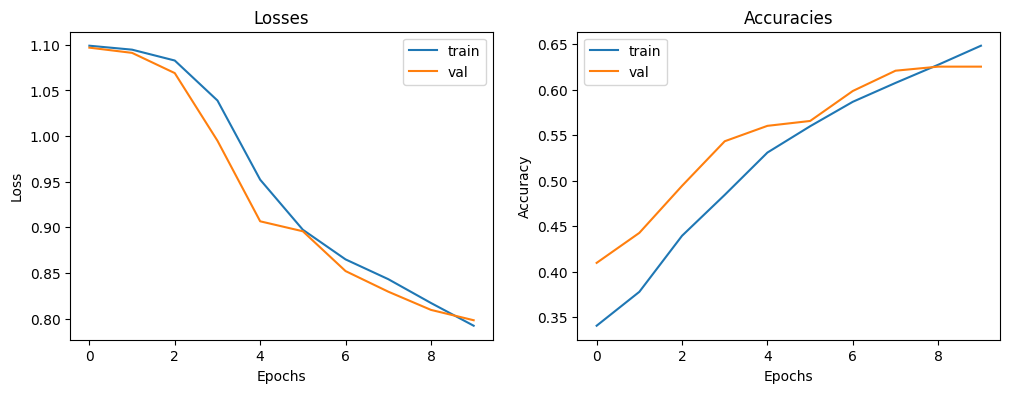

gru_hidden = 32
Test correct = 456

Test total dataitem = 750

Test Accuracy = 0.6079999804496765

              precision    recall  f1-score   support

    negative       0.59      0.71      0.64       250
     neutral       0.64      0.59      0.62       250
    positive       0.59      0.53      0.56       250

    accuracy                           0.61       750
   macro avg       0.61      0.61      0.61       750
weighted avg       0.61      0.61      0.61       750



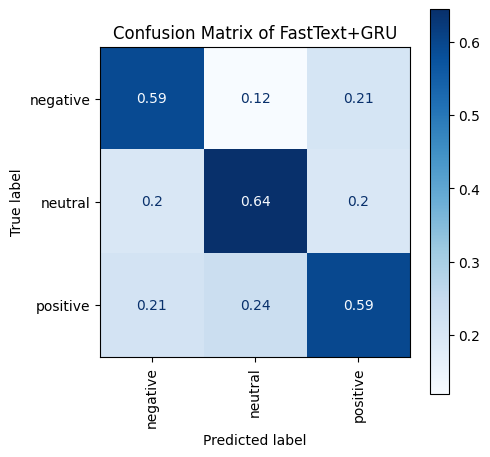

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 175.85it/s]


loss = 1.097904275683686, val_loss =1.0952123810167587, accuracy = 0.3558416962623596, val_accuracy = 0.4300979673862457


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 175.47it/s]


loss = 1.0825206366647036, val_loss =1.0607792646875458, accuracy = 0.44550877809524536, val_accuracy = 0.4915405213832855


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 176.99it/s]


loss = 0.9960712341149338, val_loss =0.9306627911482273, accuracy = 0.5356469750404358, val_accuracy = 0.5645592212677002


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 174.62it/s]


loss = 0.8775920362549369, val_loss =0.8458450593865506, accuracy = 0.6023869514465332, val_accuracy = 0.6233303546905518


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 176.59it/s]


loss = 0.8071494406220154, val_loss =0.8132018133680085, accuracy = 0.6505967378616333, val_accuracy = 0.6295636892318726


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 183.59it/s]


loss = 0.7703981054222094, val_loss =0.7727925289332652, accuracy = 0.6735238432884216, val_accuracy = 0.658058762550354


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 178.99it/s]


loss = 0.7403805091670074, val_loss =0.7610895471864505, accuracy = 0.6895414590835571, val_accuracy = 0.6544969081878662


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 180.64it/s]


loss = 0.7245344209512404, val_loss =0.7506481301904258, accuracy = 0.6937813758850098, val_accuracy = 0.6571683287620544


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 178.06it/s]


loss = 0.7062941893987227, val_loss =0.7368682023774397, accuracy = 0.7079145908355713, val_accuracy = 0.677649199962616


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 177.78it/s]
<ipython-input-24-a92860fd3f0c>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.6959149768074713, val_loss =0.726158132969581, accuracy = 0.7149811387062073, val_accuracy = 0.6936776638031006


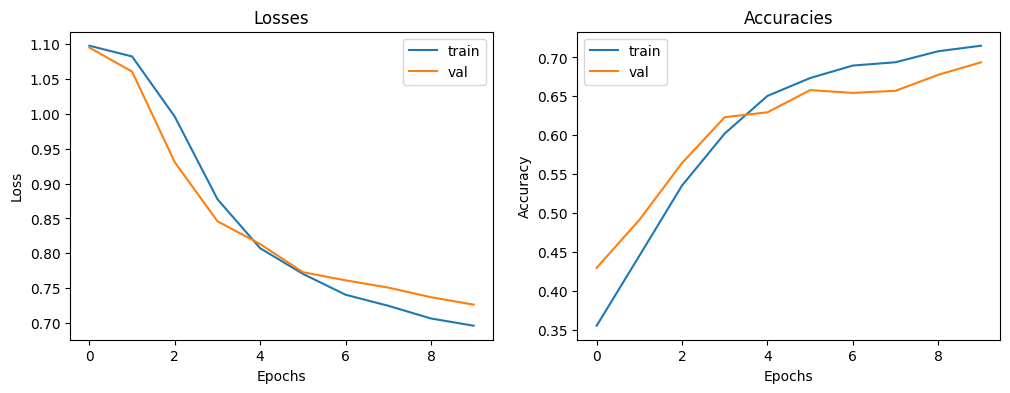

gru_hidden = 64
Test correct = 463

Test total dataitem = 750

Test Accuracy = 0.6173333525657654

              precision    recall  f1-score   support

    negative       0.64      0.62      0.63       250
     neutral       0.60      0.67      0.63       250
    positive       0.61      0.56      0.59       250

    accuracy                           0.62       750
   macro avg       0.62      0.62      0.62       750
weighted avg       0.62      0.62      0.62       750



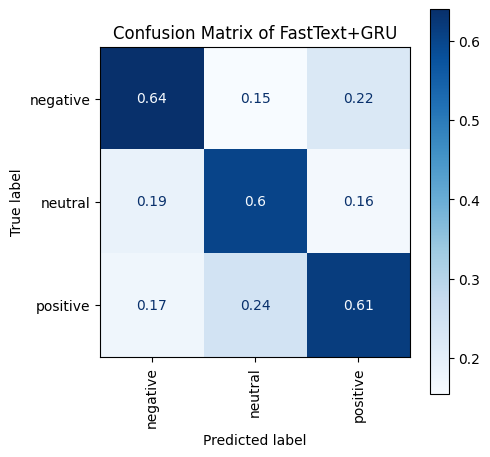

Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 96.05it/s]


loss = 1.095842419397086, val_loss =1.084104197503378, accuracy = 0.3649497330188751, val_accuracy = 0.5022261738777161


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 94.60it/s]


loss = 1.0233906877040864, val_loss =0.9267325061595155, accuracy = 0.5113065242767334, val_accuracy = 0.5681211352348328


Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 97.04it/s]


loss = 0.8530307751390501, val_loss =0.7992180339361925, accuracy = 0.6190326809883118, val_accuracy = 0.6429207921028137


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 101.28it/s]


loss = 0.7833301816796302, val_loss =0.7773060958061944, accuracy = 0.6639447212219238, val_accuracy = 0.6500445604324341


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 124.05it/s]


loss = 0.742785803698498, val_loss =0.7535468176009119, accuracy = 0.6925250887870789, val_accuracy = 0.6687444448471069


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 123.61it/s]


loss = 0.7179376682115253, val_loss =0.7425466016116035, accuracy = 0.7047738432884216, val_accuracy = 0.6731967926025391


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 123.54it/s]


loss = 0.6965908896424299, val_loss =0.7385871003159702, accuracy = 0.7171796560287476, val_accuracy = 0.677649199962616


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 122.07it/s]


loss = 0.6864004727925567, val_loss =0.7242476131541595, accuracy = 0.7245603203773499, val_accuracy = 0.6865538954734802


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 122.90it/s]


loss = 0.6717845419857258, val_loss =0.7120288354574494, accuracy = 0.7289572954177856, val_accuracy = 0.6945681571960449


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 123.96it/s]
<ipython-input-24-a92860fd3f0c>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.6598933464836592, val_loss =0.7077427932605219, accuracy = 0.7366520166397095, val_accuracy = 0.7025823593139648


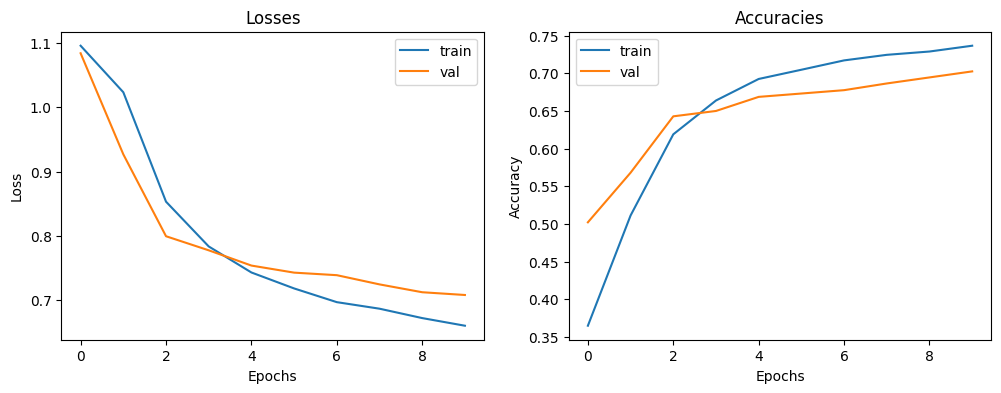

gru_hidden = 128
Test correct = 465

Test total dataitem = 750

Test Accuracy = 0.6200000047683716

              precision    recall  f1-score   support

    negative       0.66      0.62      0.64       250
     neutral       0.59      0.69      0.63       250
    positive       0.62      0.55      0.59       250

    accuracy                           0.62       750
   macro avg       0.62      0.62      0.62       750
weighted avg       0.62      0.62      0.62       750



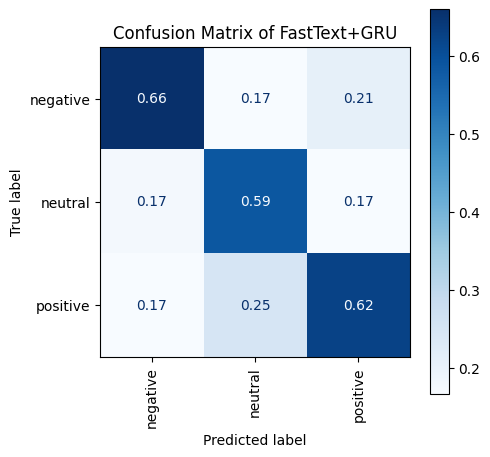

Epoch 1: 100%|██████████| 100/100 [00:02<00:00, 44.43it/s]


loss = 1.0847530514281243, val_loss =1.0295518334895846, accuracy = 0.40860551595687866, val_accuracy = 0.5138023495674133


Epoch 2: 100%|██████████| 100/100 [00:02<00:00, 43.39it/s]


loss = 0.8958591101055936, val_loss =0.8090442038899739, accuracy = 0.5874685645103455, val_accuracy = 0.641139805316925


Epoch 3: 100%|██████████| 100/100 [00:02<00:00, 43.11it/s]


loss = 0.7821655899577127, val_loss =0.7694323265852983, accuracy = 0.6637876629829407, val_accuracy = 0.6723063588142395


Epoch 4: 100%|██████████| 100/100 [00:02<00:00, 43.68it/s]


loss = 0.7340015761391442, val_loss =0.7509492100221068, accuracy = 0.6901695728302002, val_accuracy = 0.6660730242729187


Epoch 5: 100%|██████████| 100/100 [00:02<00:00, 43.81it/s]


loss = 0.70828921366749, val_loss =0.7271827238537731, accuracy = 0.7068153023719788, val_accuracy = 0.6812110543251038


Epoch 6: 100%|██████████| 100/100 [00:02<00:00, 44.04it/s]


loss = 0.6864486553556526, val_loss =0.7208009681728966, accuracy = 0.7138819098472595, val_accuracy = 0.6918967366218567


Epoch 7: 100%|██████████| 100/100 [00:02<00:00, 44.05it/s]


loss = 0.6675430269893377, val_loss =0.7170357866599737, accuracy = 0.7330402135848999, val_accuracy = 0.6918967366218567


Epoch 8: 100%|██████████| 100/100 [00:02<00:00, 43.75it/s]


loss = 0.6503459709153572, val_loss =0.7163288697318797, accuracy = 0.7346105575561523, val_accuracy = 0.690115749835968


Epoch 9: 100%|██████████| 100/100 [00:02<00:00, 43.54it/s]


loss = 0.640806617513963, val_loss =0.6953262865931994, accuracy = 0.7380653023719788, val_accuracy = 0.6963490843772888


Epoch 10: 100%|██████████| 100/100 [00:02<00:00, 44.62it/s]
<ipython-input-24-a92860fd3f0c>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.6205355714250572, val_loss =0.701745803984788, accuracy = 0.7517274022102356, val_accuracy = 0.7052537798881531


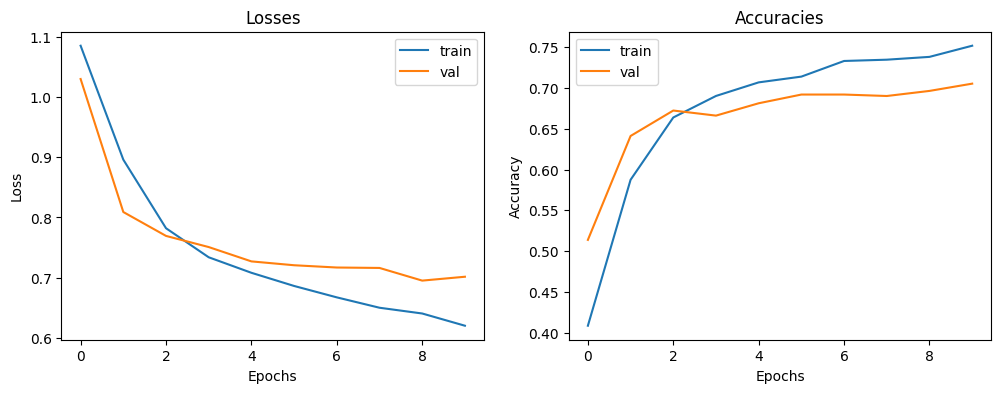

gru_hidden = 256
Test correct = 457

Test total dataitem = 750

Test Accuracy = 0.609333336353302

              precision    recall  f1-score   support

    negative       0.62      0.65      0.64       250
     neutral       0.60      0.64      0.62       250
    positive       0.60      0.54      0.57       250

    accuracy                           0.61       750
   macro avg       0.61      0.61      0.61       750
weighted avg       0.61      0.61      0.61       750



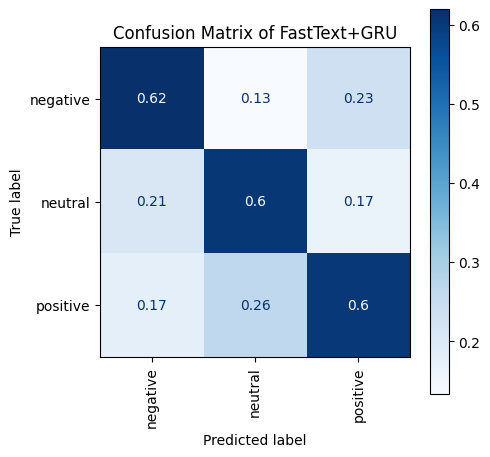

In [ ]:
bidirectional=True
num_layers=3
gru_hidden_size=[32,64,128,256]
for gru_hidden in gru_hidden_size:
  model=GRU(fasttext_weights,gru_hidden,hidden_size2,freeze_embedding,droprate,num_layers,dider=bidirectional).to(device)
  optimizer=optim.Adam(model.parameters(),lr=learning_rate)
  train(model,epoch,optimizer,criterion,train_loader,val_loader)
  model_name='FastText+GRU'
  print(f'gru_hidden = {gru_hidden}')
  test_and_report(model,test_loader,model_name)

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 114.41it/s]


loss = 1.1113082086388022, val_loss =1.0933242286570253, accuracy = 0.3332286477088928, val_accuracy = 0.34728407859802246


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 118.95it/s]


loss = 1.0797250562813132, val_loss =1.0122087767170298, accuracy = 0.3963567912578583, val_accuracy = 0.5173642039299011


Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 99.01it/s]


loss = 0.9891543586598709, val_loss =0.8979711545779119, accuracy = 0.5069095492362976, val_accuracy = 0.5868210196495056


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 99.16it/s]


loss = 0.9376150884575327, val_loss =0.8585414132848013, accuracy = 0.544283926486969, val_accuracy = 0.609082818031311


Epoch 5: 100%|██████████| 100/100 [00:01<00:00, 98.21it/s]


loss = 0.8912177746885572, val_loss =0.8299315726452892, accuracy = 0.5736494660377502, val_accuracy = 0.6322351098060608


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 127.42it/s]


loss = 0.8596415636020538, val_loss =0.8078268049586942, accuracy = 0.5990892052650452, val_accuracy = 0.6509349942207336


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 128.13it/s]


loss = 0.8267191735372762, val_loss =0.7886755346529378, accuracy = 0.621702253818512, val_accuracy = 0.6447017192840576


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 128.70it/s]


loss = 0.8022938440286634, val_loss =0.7631640766042336, accuracy = 0.6485552787780762, val_accuracy = 0.6616206765174866


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 126.47it/s]


loss = 0.7713479797034415, val_loss =0.7939592194153062, accuracy = 0.6672424674034119, val_accuracy = 0.6625111699104309


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 125.40it/s]
<ipython-input-24-a92860fd3f0c>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.7565863163951689, val_loss =0.737412571160969, accuracy = 0.6774497628211975, val_accuracy = 0.6740872859954834


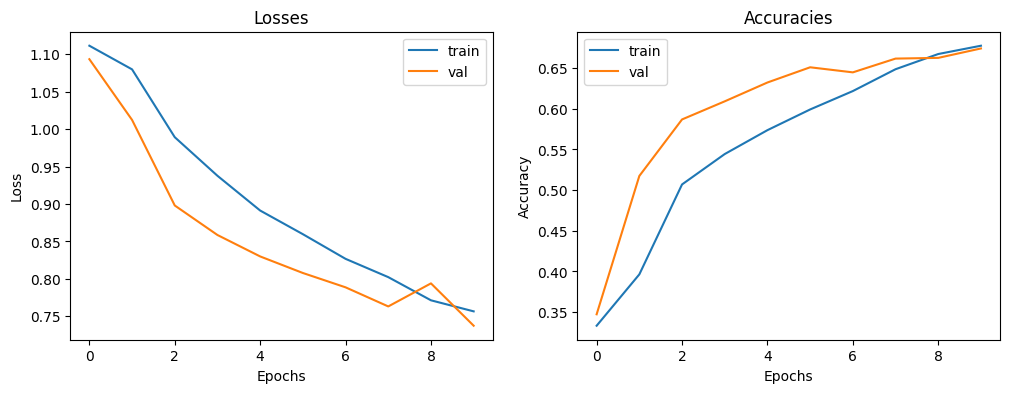

fc_hidden = 16
Test correct = 462

Test total dataitem = 750

Test Accuracy = 0.6159999966621399

              precision    recall  f1-score   support

    negative       0.65      0.64      0.65       250
     neutral       0.61      0.65      0.63       250
    positive       0.58      0.56      0.57       250

    accuracy                           0.62       750
   macro avg       0.62      0.62      0.62       750
weighted avg       0.62      0.62      0.62       750



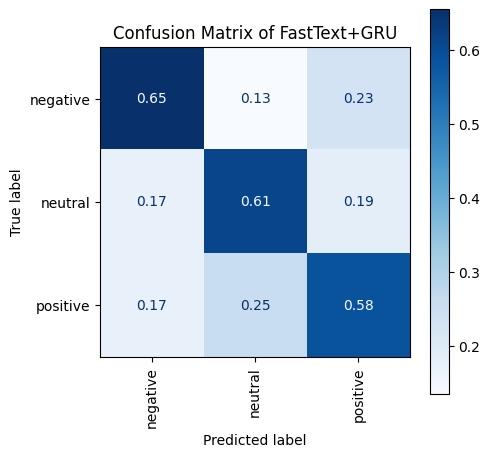

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 126.65it/s]


loss = 1.0991052418295295, val_loss =1.0912206126214374, accuracy = 0.3498743772506714, val_accuracy = 0.4318788945674896


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 128.40it/s]


loss = 1.055005422164686, val_loss =1.0088936242082762, accuracy = 0.4513190984725952, val_accuracy = 0.4728406071662903


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 126.31it/s]


loss = 0.9537228291435167, val_loss =0.908697196928459, accuracy = 0.5325062870979309, val_accuracy = 0.5672306418418884


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 126.74it/s]


loss = 0.886399043588317, val_loss =0.84877957464011, accuracy = 0.5877826809883118, val_accuracy = 0.6037399768829346


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 127.12it/s]


loss = 0.8253456653669127, val_loss =0.8115764505361089, accuracy = 0.6281406879425049, val_accuracy = 0.6286731958389282


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 119.75it/s]


loss = 0.789698224546446, val_loss =0.771489625115646, accuracy = 0.6609610319137573, val_accuracy = 0.6553874015808105


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 100.22it/s]


loss = 0.7465289953174215, val_loss =0.7843474559326071, accuracy = 0.6859296560287476, val_accuracy = 0.6500445604324341


Epoch 8: 100%|██████████| 100/100 [00:01<00:00, 97.40it/s]


loss = 0.7352499300802811, val_loss =0.7405286033825842, accuracy = 0.6914258599281311, val_accuracy = 0.6589492559432983


Epoch 9: 100%|██████████| 100/100 [00:01<00:00, 97.31it/s]


loss = 0.7185392528611919, val_loss =0.7216009132504012, accuracy = 0.7032034993171692, val_accuracy = 0.6865538954734802


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 105.71it/s]
<ipython-input-24-a92860fd3f0c>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.6989910178291211, val_loss =0.7263069447309207, accuracy = 0.720634400844574, val_accuracy = 0.6749777793884277


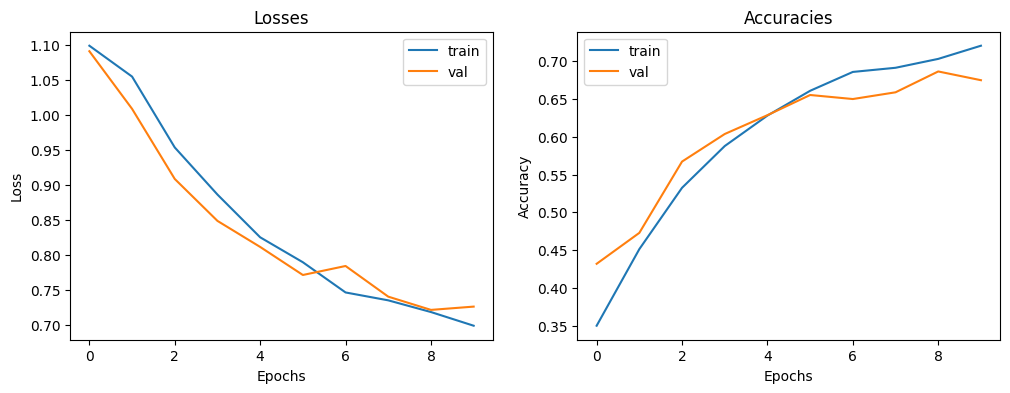

fc_hidden = 32
Test correct = 465

Test total dataitem = 750

Test Accuracy = 0.6200000047683716

              precision    recall  f1-score   support

    negative       0.61      0.72      0.66       250
     neutral       0.61      0.63      0.62       250
    positive       0.65      0.51      0.57       250

    accuracy                           0.62       750
   macro avg       0.62      0.62      0.62       750
weighted avg       0.62      0.62      0.62       750



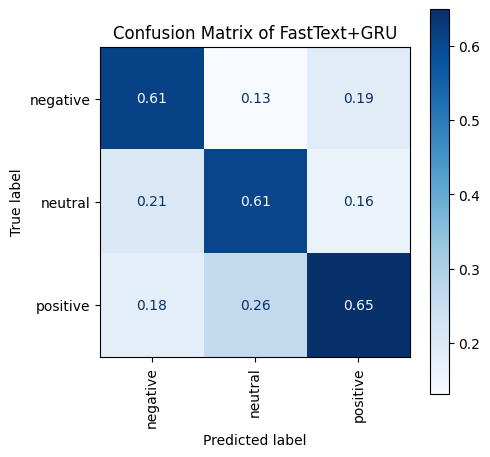

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 126.61it/s]


loss = 1.096379933115095, val_loss =1.0886268352764465, accuracy = 0.3599246144294739, val_accuracy = 0.46037399768829346


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 123.52it/s]


loss = 1.0292675381014122, val_loss =0.9033733060409772, accuracy = 0.5073806643486023, val_accuracy = 0.5779163241386414


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 123.69it/s]


loss = 0.8506184914706683, val_loss =0.8031184720384541, accuracy = 0.6284547448158264, val_accuracy = 0.6420302987098694


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 124.29it/s]


loss = 0.7775817581925366, val_loss =0.7788860398070288, accuracy = 0.6670854091644287, val_accuracy = 0.6598397493362427


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 124.90it/s]


loss = 0.7504081771090932, val_loss =0.7681873444132858, accuracy = 0.6834170818328857, val_accuracy = 0.651825487613678


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 124.33it/s]


loss = 0.7261026780328393, val_loss =0.7519084270675814, accuracy = 0.7033605575561523, val_accuracy = 0.666963517665863


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 122.94it/s]


loss = 0.7084670230262782, val_loss =0.7339640348240556, accuracy = 0.7061871886253357, val_accuracy = 0.6758682131767273


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 124.12it/s]


loss = 0.6886975311258903, val_loss =0.7283365190001888, accuracy = 0.7203203439712524, val_accuracy = 0.6749777793884277


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 124.12it/s]


loss = 0.6767409352772938, val_loss =0.7180562729094481, accuracy = 0.7262876629829407, val_accuracy = 0.6856634020805359


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 124.22it/s]
<ipython-input-24-a92860fd3f0c>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.6610575473979589, val_loss =0.7124573760146473, accuracy = 0.7328831553459167, val_accuracy = 0.690115749835968


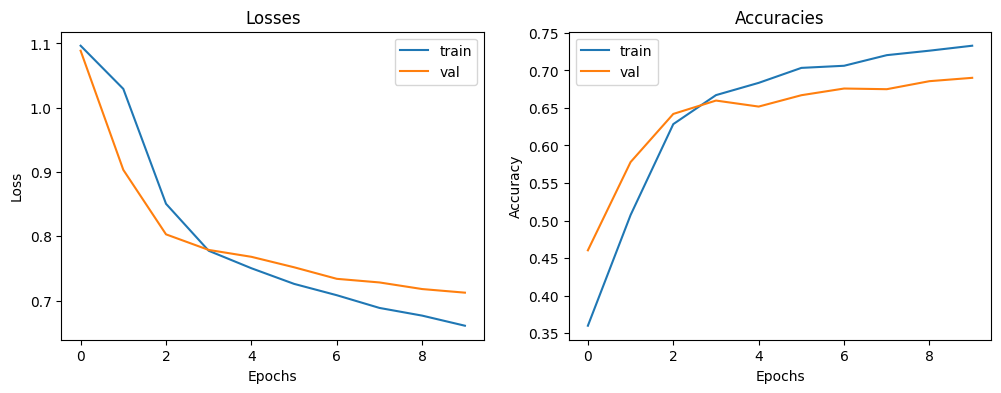

fc_hidden = 64
Test correct = 472

Test total dataitem = 750

Test Accuracy = 0.6293333172798157

              precision    recall  f1-score   support

    negative       0.67      0.65      0.66       250
     neutral       0.62      0.65      0.63       250
    positive       0.60      0.59      0.60       250

    accuracy                           0.63       750
   macro avg       0.63      0.63      0.63       750
weighted avg       0.63      0.63      0.63       750



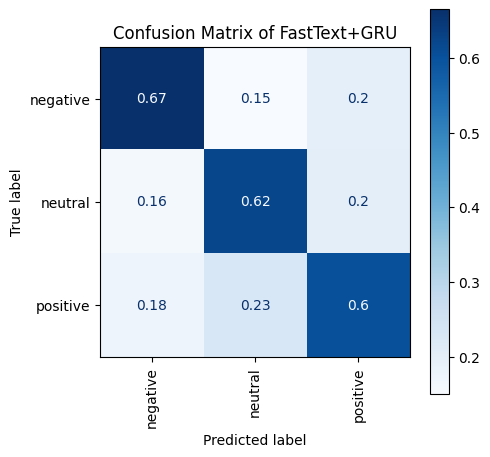

Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 97.56it/s]


loss = 1.0952557656913995, val_loss =1.0845688682833006, accuracy = 0.36918970942497253, val_accuracy = 0.4772929847240448


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 94.55it/s]


loss = 1.016760756392032, val_loss =0.9203213204688852, accuracy = 0.5102072954177856, val_accuracy = 0.5672306418418884


Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 94.18it/s]


loss = 0.8369562015926931, val_loss =0.8053617409668818, accuracy = 0.6322236061096191, val_accuracy = 0.6429207921028137


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 112.86it/s]


loss = 0.7683563713215699, val_loss =0.8523632790274283, accuracy = 0.6670854091644287, val_accuracy = 0.6153161525726318


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 122.87it/s]


loss = 0.7406714989306784, val_loss =0.7511708570063569, accuracy = 0.685615599155426, val_accuracy = 0.6758682131767273


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 122.82it/s]


loss = 0.7023162542859063, val_loss =0.7489088778147042, accuracy = 0.7032034993171692, val_accuracy = 0.6687444448471069


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 122.57it/s]


loss = 0.6865113170719269, val_loss =0.7314844934967817, accuracy = 0.7118404507637024, val_accuracy = 0.6812110543251038


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 121.59it/s]


loss = 0.6710965654150641, val_loss =0.7184465341880688, accuracy = 0.7264447212219238, val_accuracy = 0.6892253160476685


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 122.75it/s]


loss = 0.65293896750165, val_loss =0.7460091953262842, accuracy = 0.731783926486969, val_accuracy = 0.6812110543251038


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 122.77it/s]
<ipython-input-24-a92860fd3f0c>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.6462317478247951, val_loss =0.7177197978110237, accuracy = 0.7372801303863525, val_accuracy = 0.700801432132721


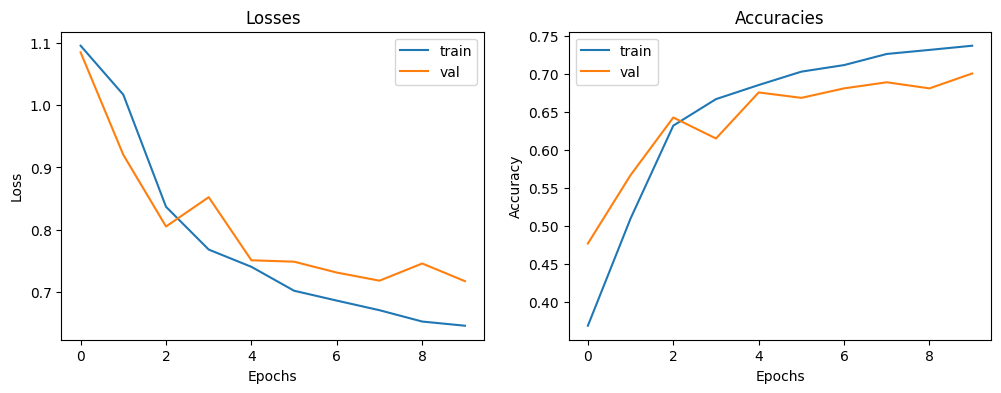

fc_hidden = 128
Test correct = 465

Test total dataitem = 750

Test Accuracy = 0.6200000047683716

              precision    recall  f1-score   support

    negative       0.67      0.65      0.66       250
     neutral       0.58      0.71      0.64       250
    positive       0.63      0.50      0.56       250

    accuracy                           0.62       750
   macro avg       0.62      0.62      0.62       750
weighted avg       0.62      0.62      0.62       750



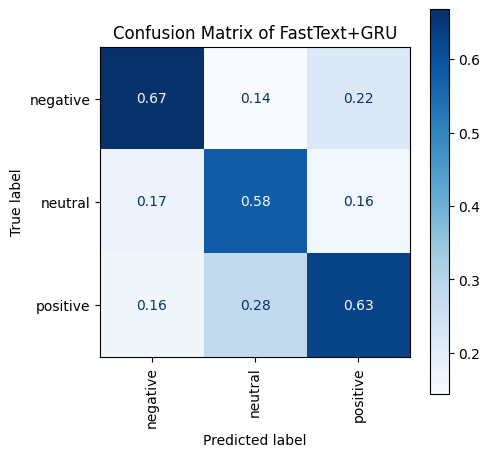

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 123.07it/s]


loss = 1.0920161775965243, val_loss =1.0759438298184365, accuracy = 0.40782034397125244, val_accuracy = 0.5146927833557129


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 121.79it/s]


loss = 0.9636177375272382, val_loss =0.8411729271857193, accuracy = 0.5763190984725952, val_accuracy = 0.6233303546905518


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 122.09it/s]


loss = 0.7993160890242144, val_loss =0.7957278335811607, accuracy = 0.646513819694519, val_accuracy = 0.651825487613678


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 112.35it/s]


loss = 0.7406681414823834, val_loss =0.7690129552321787, accuracy = 0.6802763938903809, val_accuracy = 0.658058762550354


Epoch 5: 100%|██████████| 100/100 [00:01<00:00, 95.93it/s]


loss = 0.714695850810258, val_loss =0.7680455750351058, accuracy = 0.6973931789398193, val_accuracy = 0.6598397493362427


Epoch 6: 100%|██████████| 100/100 [00:01<00:00, 95.70it/s]


loss = 0.6975844683945525, val_loss =0.740560120291521, accuracy = 0.7054020166397095, val_accuracy = 0.6785396337509155


Epoch 7: 100%|██████████| 100/100 [00:01<00:00, 93.21it/s]


loss = 0.6836379923670575, val_loss =0.7381872089225605, accuracy = 0.7116833925247192, val_accuracy = 0.677649199962616


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 121.47it/s]


loss = 0.6644284463030271, val_loss =0.7265147121967553, accuracy = 0.7236180901527405, val_accuracy = 0.690115749835968


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 121.18it/s]


loss = 0.6542720401272618, val_loss =0.7361500544888488, accuracy = 0.7309987545013428, val_accuracy = 0.6874443888664246


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 122.09it/s]
<ipython-input-24-a92860fd3f0c>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.6435546146840443, val_loss =0.73640723803067, accuracy = 0.7364949584007263, val_accuracy = 0.6821015477180481


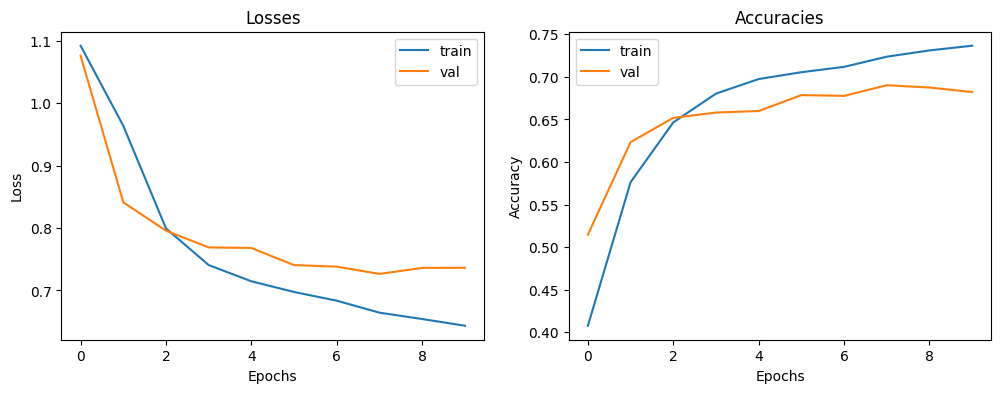

fc_hidden = 256
Test correct = 480

Test total dataitem = 750

Test Accuracy = 0.6399999856948853

              precision    recall  f1-score   support

    negative       0.62      0.73      0.67       250
     neutral       0.63      0.64      0.63       250
    positive       0.69      0.56      0.62       250

    accuracy                           0.64       750
   macro avg       0.64      0.64      0.64       750
weighted avg       0.64      0.64      0.64       750



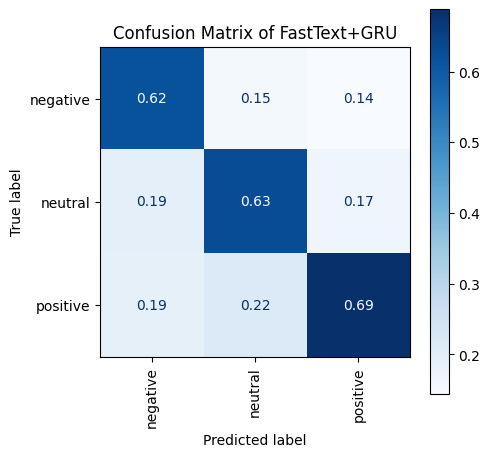

In [ ]:
bidirectional=True
num_layers=3
hidden_size1=128
fc_hidden_size=[16,32,64,128,256]
for fc_hidden in fc_hidden_size:
  model=GRU(fasttext_weights,hidden_size1,fc_hidden,freeze_embedding,droprate,num_layers,dider=bidirectional).to(device)
  optimizer=optim.Adam(model.parameters(),lr=learning_rate)
  train(model,epoch,optimizer,criterion,train_loader,val_loader)
  model_name='FastText+GRU'
  print(f'fc_hidden = {fc_hidden}')
  test_and_report(model,test_loader,model_name)

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 112.21it/s]


loss = 1.0836583524756134, val_loss =1.0292786444877349, accuracy = 0.42870602011680603, val_accuracy = 0.5013357400894165


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 125.64it/s]


loss = 0.9188093459955416, val_loss =0.8395481619035958, accuracy = 0.5789886713027954, val_accuracy = 0.6153161525726318


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 125.62it/s]


loss = 0.7995330260071205, val_loss =0.7949945889867469, accuracy = 0.6454145908355713, val_accuracy = 0.6438112258911133


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 123.28it/s]


loss = 0.7442730866394414, val_loss =0.771287808670581, accuracy = 0.677763819694519, val_accuracy = 0.6625111699104309


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 125.29it/s]


loss = 0.7106158872130618, val_loss =0.7552422125617527, accuracy = 0.6983354091644287, val_accuracy = 0.666963517665863


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 123.21it/s]


loss = 0.6883212446548714, val_loss =0.7314503247480533, accuracy = 0.7086997628211975, val_accuracy = 0.6821015477180481


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 114.87it/s]


loss = 0.6710228489516158, val_loss =0.7202259865420361, accuracy = 0.71875, val_accuracy = 0.6981300115585327


Epoch 8: 100%|██████████| 100/100 [00:01<00:00, 99.77it/s]


loss = 0.6551694179622427, val_loss =0.7243101154831247, accuracy = 0.72722989320755, val_accuracy = 0.700801432132721


Epoch 9: 100%|██████████| 100/100 [00:01<00:00, 98.14it/s]


loss = 0.636497528968248, val_loss =0.7121816970227219, accuracy = 0.7355527281761169, val_accuracy = 0.6999109983444214


Epoch 10: 100%|██████████| 100/100 [00:01<00:00, 97.71it/s]
<ipython-input-24-a92860fd3f0c>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.6329801569688425, val_loss =0.7256090480099142, accuracy = 0.7357097864151001, val_accuracy = 0.6927871704101562


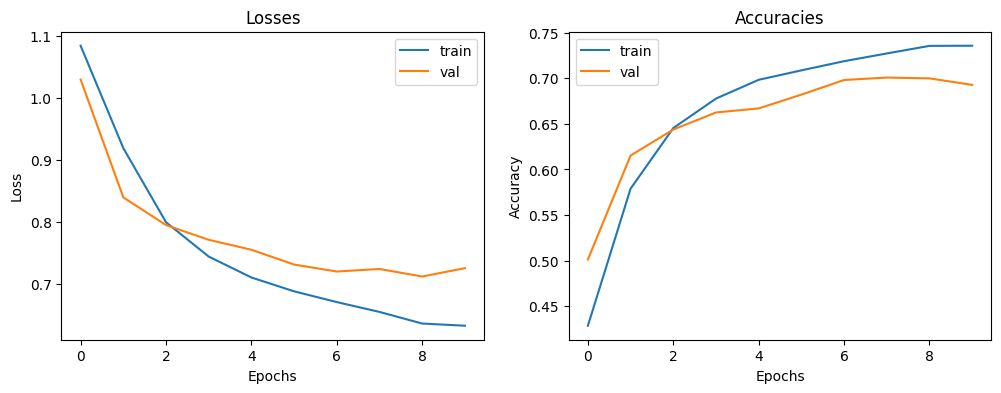

drop_rate = 0.1
Test correct = 460

Test total dataitem = 750

Test Accuracy = 0.6133333444595337

              precision    recall  f1-score   support

    negative       0.63      0.70      0.66       250
     neutral       0.58      0.68      0.63       250
    positive       0.65      0.46      0.54       250

    accuracy                           0.61       750
   macro avg       0.62      0.61      0.61       750
weighted avg       0.62      0.61      0.61       750



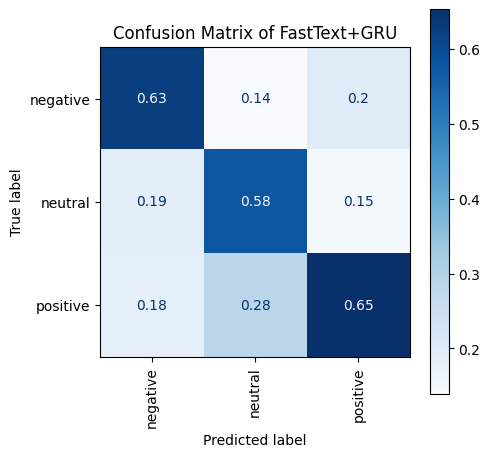

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 124.90it/s]


loss = 1.089268712233752, val_loss =1.0599029715025117, accuracy = 0.40295225381851196, val_accuracy = 0.49599289894104004


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 123.93it/s]


loss = 0.9440907284576678, val_loss =0.8379451045443097, accuracy = 0.5711369514465332, val_accuracy = 0.6277827620506287


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 123.10it/s]


loss = 0.7909582961708657, val_loss =0.7862309291243225, accuracy = 0.6520100235939026, val_accuracy = 0.6455921530723572


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 122.21it/s]


loss = 0.7449650340985682, val_loss =0.7596153726613256, accuracy = 0.6754083037376404, val_accuracy = 0.6651825904846191


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 122.28it/s]


loss = 0.7038628169667936, val_loss =0.7673805021249878, accuracy = 0.6997487545013428, val_accuracy = 0.6625111699104309


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 121.10it/s]


loss = 0.684087943339473, val_loss =0.7446278185996995, accuracy = 0.7077575325965881, val_accuracy = 0.6723063588142395


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 122.68it/s]


loss = 0.6689226634861188, val_loss =0.7289068812428418, accuracy = 0.7211055159568787, val_accuracy = 0.6865538954734802


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 122.97it/s]


loss = 0.6614634475744242, val_loss =0.7277336628721969, accuracy = 0.7181218266487122, val_accuracy = 0.6865538954734802


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 121.93it/s]


loss = 0.6431272151341182, val_loss =0.7279327254146333, accuracy = 0.7325690984725952, val_accuracy = 0.683882474899292


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 121.61it/s]
<ipython-input-24-a92860fd3f0c>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.6375553819761626, val_loss =0.7081584704286393, accuracy = 0.7294284105300903, val_accuracy = 0.7061442732810974


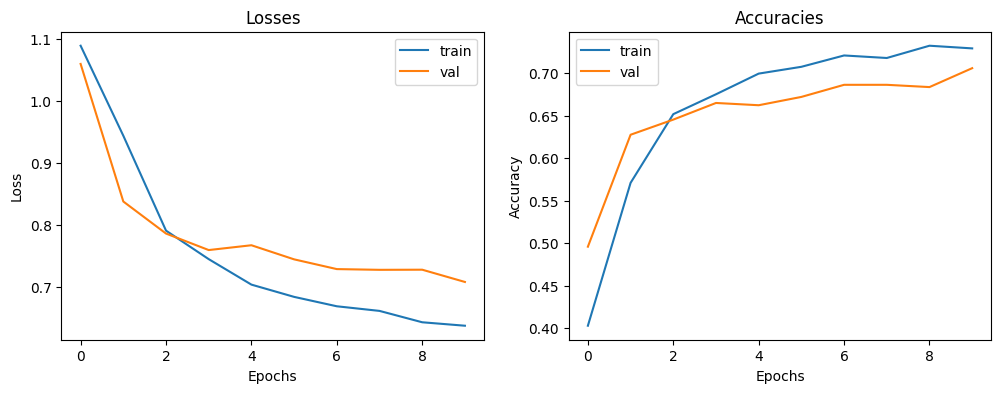

drop_rate = 0.2
Test correct = 478

Test total dataitem = 750

Test Accuracy = 0.637333333492279

              precision    recall  f1-score   support

    negative       0.65      0.66      0.66       250
     neutral       0.63      0.66      0.64       250
    positive       0.63      0.60      0.61       250

    accuracy                           0.64       750
   macro avg       0.64      0.64      0.64       750
weighted avg       0.64      0.64      0.64       750



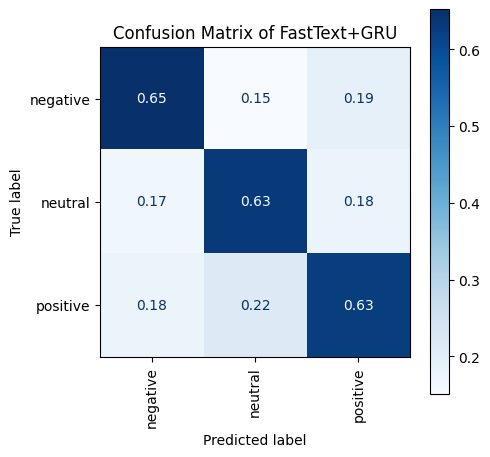

Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 95.92it/s]


loss = 1.0894895868096501, val_loss =1.0596691964342009, accuracy = 0.4092336595058441, val_accuracy = 0.49866431951522827


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 95.34it/s]


loss = 0.9258588168973801, val_loss =0.8454540922125388, accuracy = 0.590452253818512, val_accuracy = 0.6010685563087463


Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 96.09it/s]


loss = 0.7855655250797281, val_loss =0.7792630709233761, accuracy = 0.6537374258041382, val_accuracy = 0.6491540670394897


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 120.42it/s]


loss = 0.7359172553722602, val_loss =0.7596690042381404, accuracy = 0.6766645908355713, val_accuracy = 0.666963517665863


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 121.43it/s]


loss = 0.7101211268841143, val_loss =0.7522592809015936, accuracy = 0.6948806643486023, val_accuracy = 0.658058762550354


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 119.52it/s]


loss = 0.6885252824254349, val_loss =0.7330642958181944, accuracy = 0.7052449584007263, val_accuracy = 0.6812110543251038


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 121.46it/s]


loss = 0.6666029257324407, val_loss =0.7161042137129467, accuracy = 0.7196922302246094, val_accuracy = 0.6892253160476685


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 122.22it/s]


loss = 0.6532265768399157, val_loss =0.7268608226031084, accuracy = 0.7231469750404358, val_accuracy = 0.6865538954734802


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 121.84it/s]


loss = 0.6408048182578204, val_loss =0.7083845719981972, accuracy = 0.7306846380233765, val_accuracy = 0.699020504951477


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 122.46it/s]
<ipython-input-24-a92860fd3f0c>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.6300117624217546, val_loss =0.7105308105402357, accuracy = 0.7379083037376404, val_accuracy = 0.6936776638031006


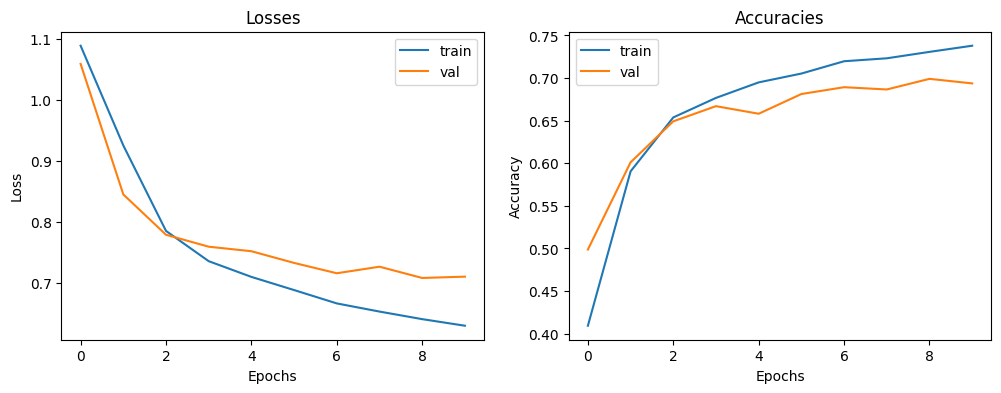

drop_rate = 0.3
Test correct = 470

Test total dataitem = 750

Test Accuracy = 0.6266666650772095

              precision    recall  f1-score   support

    negative       0.62      0.68      0.65       250
     neutral       0.65      0.60      0.62       250
    positive       0.61      0.61      0.61       250

    accuracy                           0.63       750
   macro avg       0.63      0.63      0.63       750
weighted avg       0.63      0.63      0.63       750



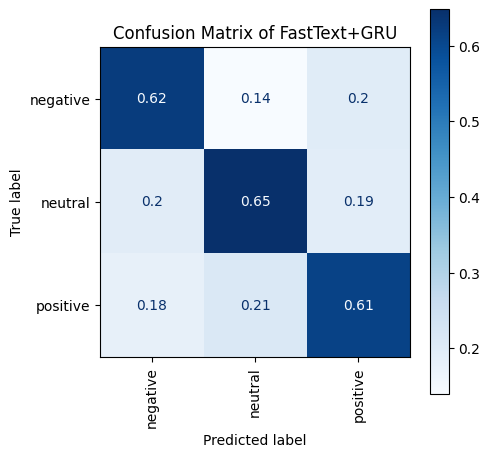

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 122.19it/s]


loss = 1.0929734485782683, val_loss =1.0719114882797594, accuracy = 0.39164572954177856, val_accuracy = 0.5022261738777161


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 122.17it/s]


loss = 0.9545204914419446, val_loss =0.8452858881725531, accuracy = 0.569566547870636, val_accuracy = 0.6108637452125549


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 122.13it/s]


loss = 0.7941299148199323, val_loss =0.7980688462646897, accuracy = 0.6438441872596741, val_accuracy = 0.6420302987098694


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 100.08it/s]


loss = 0.7351209868628211, val_loss =0.7664829483002817, accuracy = 0.682317852973938, val_accuracy = 0.651825487613678


Epoch 5: 100%|██████████| 100/100 [00:01<00:00, 98.35it/s]


loss = 0.7075567569997656, val_loss =0.7495955832703787, accuracy = 0.6977072954177856, val_accuracy = 0.6634016036987305


Epoch 6: 100%|██████████| 100/100 [00:01<00:00, 95.01it/s]


loss = 0.6855805345253612, val_loss =0.7278589480490834, accuracy = 0.7171796560287476, val_accuracy = 0.6794301271438599


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 102.68it/s]


loss = 0.6674583905341206, val_loss =0.7226131748348716, accuracy = 0.726601779460907, val_accuracy = 0.690115749835968


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 122.54it/s]


loss = 0.6574379512945415, val_loss =0.7166007971165411, accuracy = 0.7244032621383667, val_accuracy = 0.6874443888664246


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 123.95it/s]


loss = 0.6371197363127067, val_loss =0.7182096021601388, accuracy = 0.7357097864151001, val_accuracy = 0.6999109983444214


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 123.53it/s]
<ipython-input-24-a92860fd3f0c>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.6275656668518059, val_loss =0.7446952253525985, accuracy = 0.7427763938903809, val_accuracy = 0.6883348226547241


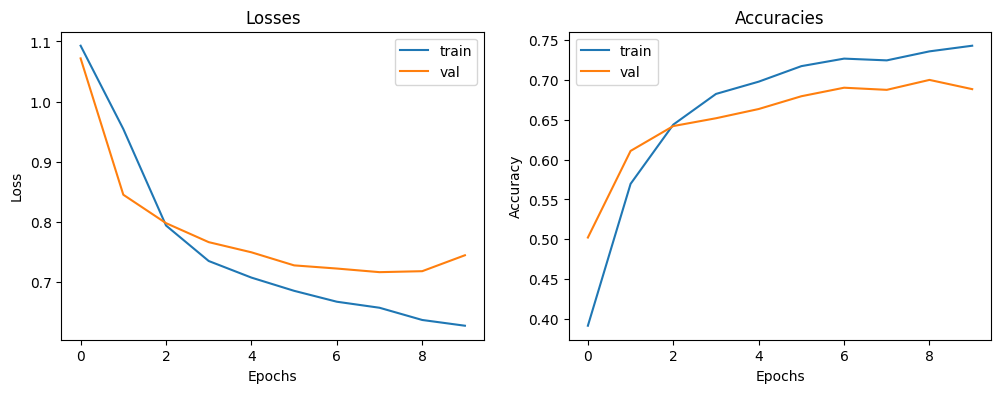

drop_rate = 0.4
Test correct = 459

Test total dataitem = 750

Test Accuracy = 0.6119999885559082

              precision    recall  f1-score   support

    negative       0.62      0.72      0.66       250
     neutral       0.57      0.67      0.62       250
    positive       0.67      0.45      0.54       250

    accuracy                           0.61       750
   macro avg       0.62      0.61      0.61       750
weighted avg       0.62      0.61      0.61       750



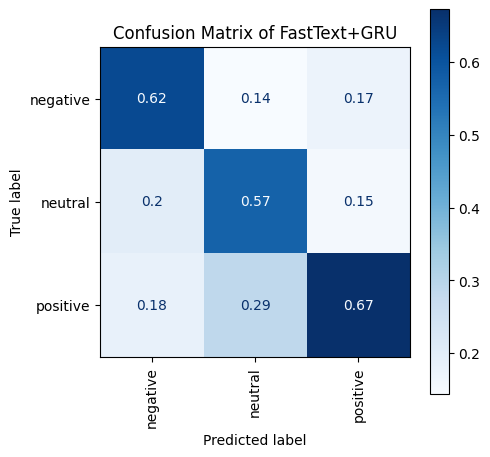

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 122.83it/s]


loss = 1.0925610133446753, val_loss =1.0736027870194187, accuracy = 0.3966708481311798, val_accuracy = 0.5093499422073364


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 122.88it/s]


loss = 0.9637651476438623, val_loss =0.8501099451202973, accuracy = 0.5612437129020691, val_accuracy = 0.5948352813720703


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 123.52it/s]


loss = 0.8052607850443746, val_loss =0.7907657629785789, accuracy = 0.6435301303863525, val_accuracy = 0.6402493715286255


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 121.25it/s]


loss = 0.7482690887547505, val_loss =0.7630927861529118, accuracy = 0.6812185645103455, val_accuracy = 0.658058762550354


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 121.44it/s]


loss = 0.7259891893842724, val_loss =0.7635369451851898, accuracy = 0.6878140568733215, val_accuracy = 0.6571683287620544


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 122.82it/s]


loss = 0.7005675435804187, val_loss =0.7437625243536164, accuracy = 0.7035175561904907, val_accuracy = 0.6705253720283508


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 124.55it/s]


loss = 0.6789056286003688, val_loss =0.7294313591272046, accuracy = 0.7179648280143738, val_accuracy = 0.677649199962616


Epoch 8: 100%|██████████| 100/100 [00:01<00:00, 98.26it/s]


loss = 0.6672217252857626, val_loss =0.7306660108034968, accuracy = 0.7223618030548096, val_accuracy = 0.6892253160476685


Epoch 9: 100%|██████████| 100/100 [00:01<00:00, 98.69it/s]


loss = 0.6522143721931388, val_loss =0.7335775604782467, accuracy = 0.7319409251213074, val_accuracy = 0.6794301271438599


Epoch 10: 100%|██████████| 100/100 [00:01<00:00, 93.37it/s]
<ipython-input-24-a92860fd3f0c>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.6407233955305947, val_loss =0.7134854833900294, accuracy = 0.7361809015274048, val_accuracy = 0.6999109983444214


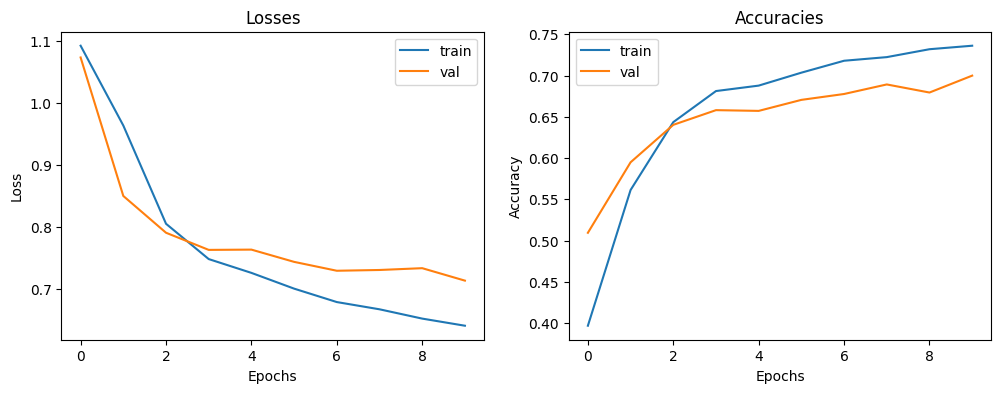

drop_rate = 0.5
Test correct = 470

Test total dataitem = 750

Test Accuracy = 0.6266666650772095

              precision    recall  f1-score   support

    negative       0.66      0.66      0.66       250
     neutral       0.58      0.71      0.64       250
    positive       0.66      0.50      0.57       250

    accuracy                           0.63       750
   macro avg       0.63      0.63      0.62       750
weighted avg       0.63      0.63      0.62       750



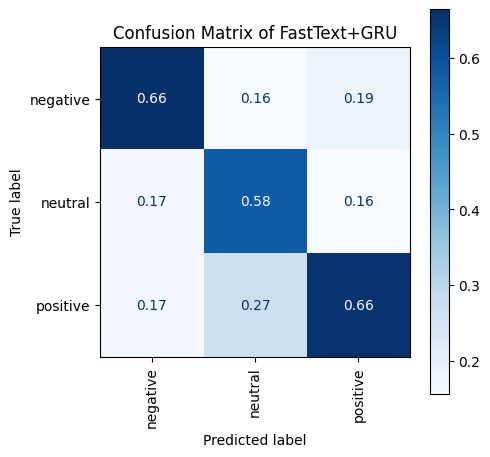

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 124.55it/s]


loss = 1.0928679820150138, val_loss =1.0789992530076278, accuracy = 0.3949434757232666, val_accuracy = 0.5200356245040894


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 123.11it/s]


loss = 0.9861432598845568, val_loss =0.8601602713614407, accuracy = 0.5370603203773499, val_accuracy = 0.6224399209022522


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 123.54it/s]


loss = 0.8114727650221902, val_loss =0.791544246678758, accuracy = 0.6429020166397095, val_accuracy = 0.6455921530723572


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 124.27it/s]


loss = 0.7554117074138048, val_loss =0.7756297140299077, accuracy = 0.6732097864151001, val_accuracy = 0.6491540670394897


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 123.31it/s]


loss = 0.7246379369616625, val_loss =0.7524843877044438, accuracy = 0.6909547448158264, val_accuracy = 0.6607301831245422


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 120.78it/s]


loss = 0.7025920862079147, val_loss =0.7457163762125197, accuracy = 0.705716073513031, val_accuracy = 0.6740872859954834


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 124.72it/s]


loss = 0.687104108067615, val_loss =0.7343038578482279, accuracy = 0.7068153023719788, val_accuracy = 0.6794301271438599


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 125.23it/s]


loss = 0.6690300142167507, val_loss =0.7371481871151893, accuracy = 0.7251884341239929, val_accuracy = 0.6740872859954834


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 123.17it/s]


loss = 0.6589114622226134, val_loss =0.7169720411248226, accuracy = 0.7298994660377502, val_accuracy = 0.690115749835968


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 123.85it/s]
<ipython-input-24-a92860fd3f0c>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.652522991896949, val_loss =0.7135189409931338, accuracy = 0.7295854091644287, val_accuracy = 0.6945681571960449


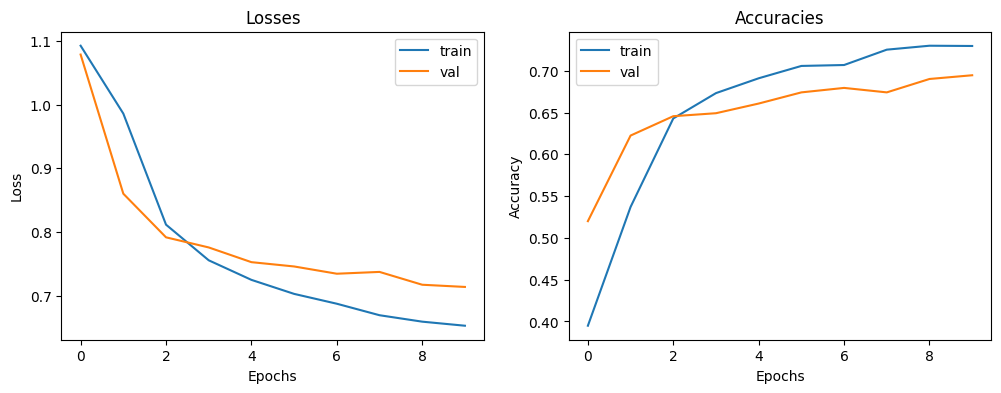

drop_rate = 0.6
Test correct = 472

Test total dataitem = 750

Test Accuracy = 0.6293333172798157

              precision    recall  f1-score   support

    negative       0.69      0.56      0.62       250
     neutral       0.62      0.69      0.65       250
    positive       0.59      0.64      0.61       250

    accuracy                           0.63       750
   macro avg       0.63      0.63      0.63       750
weighted avg       0.63      0.63      0.63       750



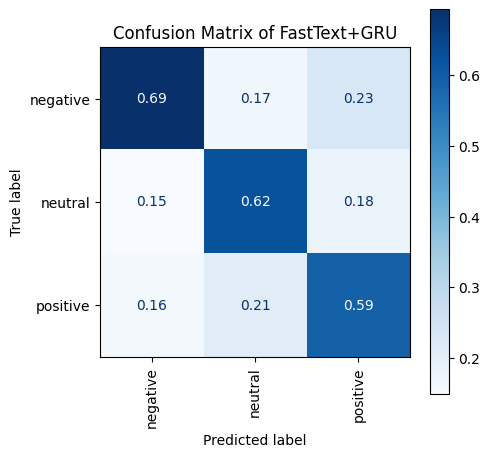

In [ ]:
bidirectional=True
num_layers=3
hidden_size1=128
hidden_size2=256
drop_rates=[0.1,0.2,0.3,0.4,0.5,0.6]
for drop_rate in drop_rates:
  model=GRU(fasttext_weights,hidden_size1,hidden_size2,freeze_embedding,drop_rate,num_layers,dider=bidirectional).to(device)
  optimizer=optim.Adam(model.parameters(),lr=learning_rate)
  train(model,epoch,optimizer,criterion,train_loader,val_loader)
  model_name='FastText+GRU'
  print(f'drop_rate = {drop_rate}')
  test_and_report(model,test_loader,model_name)

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 106.10it/s]


loss = 1.090077374270186, val_loss =1.063106020040337, accuracy = 0.3971419632434845, val_accuracy = 0.5173642039299011


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 123.09it/s]


loss = 0.9406154838082148, val_loss =0.8375304180900529, accuracy = 0.5738065242767334, val_accuracy = 0.6126447319984436


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 122.41it/s]


loss = 0.7758514277276117, val_loss =0.7902673156787863, accuracy = 0.6575062870979309, val_accuracy = 0.641139805316925


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 122.86it/s]


loss = 0.7311191439028335, val_loss =0.7636179505034335, accuracy = 0.684202253818512, val_accuracy = 0.6598397493362427


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 123.37it/s]


loss = 0.6996815922954557, val_loss =0.7631783872952043, accuracy = 0.7047738432884216, val_accuracy = 0.6687444448471069


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 122.37it/s]


loss = 0.682653069717635, val_loss =0.7375591610596905, accuracy = 0.710898220539093, val_accuracy = 0.6714158654212952


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 100.48it/s]


loss = 0.6614381017920278, val_loss =0.7349115964228292, accuracy = 0.7174937129020691, val_accuracy = 0.6749777793884277


Epoch 8: 100%|██████████| 100/100 [00:01<00:00, 98.24it/s]


loss = 0.6498792296965257, val_loss =0.7318086603007465, accuracy = 0.7289572954177856, val_accuracy = 0.6794301271438599


Epoch 9: 100%|██████████| 100/100 [00:01<00:00, 94.84it/s]


loss = 0.6355776742161106, val_loss =0.7266580708017703, accuracy = 0.7399497628211975, val_accuracy = 0.6874443888664246


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 106.61it/s]
<ipython-input-24-a92860fd3f0c>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.6239886278421909, val_loss =0.7202297040058063, accuracy = 0.7457600235939026, val_accuracy = 0.6910062432289124


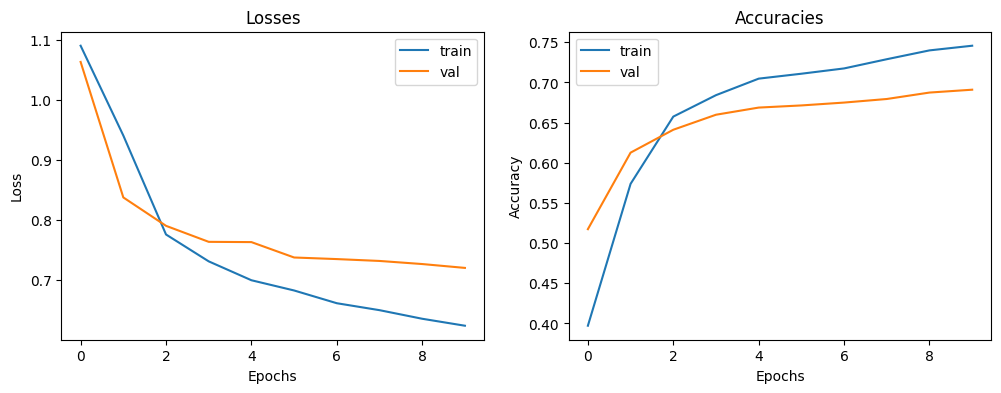

freeze_embedding = True
Test correct = 475

Test total dataitem = 750

Test Accuracy = 0.6333333253860474

              precision    recall  f1-score   support

    negative       0.63      0.70      0.66       250
     neutral       0.62      0.64      0.63       250
    positive       0.65      0.57      0.60       250

    accuracy                           0.63       750
   macro avg       0.63      0.63      0.63       750
weighted avg       0.63      0.63      0.63       750



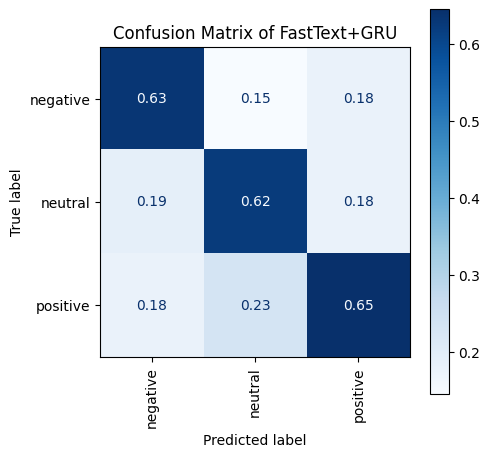

Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 92.52it/s]


loss = 1.0848672775737942, val_loss =1.0275912543817882, accuracy = 0.4313756227493286, val_accuracy = 0.5360641479492188


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 93.31it/s]


loss = 0.8208569547600928, val_loss =0.7135143549316877, accuracy = 0.6455715894699097, val_accuracy = 0.6794301271438599


Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 93.19it/s]


loss = 0.600671984007131, val_loss =0.6634988059319089, accuracy = 0.7465451955795288, val_accuracy = 0.7195013761520386


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 93.03it/s]


loss = 0.5057546438497229, val_loss =0.6291610253635481, accuracy = 0.7952260971069336, val_accuracy = 0.7310774922370911


Epoch 5: 100%|██████████| 100/100 [00:01<00:00, 93.24it/s]


loss = 0.4466439824621375, val_loss =0.6593976147493648, accuracy = 0.8217650651931763, val_accuracy = 0.7212823033332825


Epoch 6: 100%|██████████| 100/100 [00:01<00:00, 93.41it/s]


loss = 0.4105067758392033, val_loss =0.6487468433492073, accuracy = 0.8365263938903809, val_accuracy = 0.7462155222892761


Epoch 7: 100%|██████████| 100/100 [00:01<00:00, 93.81it/s]


loss = 0.36670818131412375, val_loss =0.6481086570432378, accuracy = 0.8572550415992737, val_accuracy = 0.7444345951080322


Epoch 8: 100%|██████████| 100/100 [00:01<00:00, 90.51it/s]


loss = 0.3365593333053502, val_loss =0.6701894725737598, accuracy = 0.8713881969451904, val_accuracy = 0.7462155222892761


Epoch 9: 100%|██████████| 100/100 [00:01<00:00, 88.84it/s]


loss = 0.3150271020480034, val_loss =0.7125229767746739, accuracy = 0.8800250887870789, val_accuracy = 0.7462155222892761


Epoch 10: 100%|██████████| 100/100 [00:01<00:00, 87.04it/s]
<ipython-input-24-a92860fd3f0c>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.29333695689338923, val_loss =0.7093661893269212, accuracy = 0.8896042704582214, val_accuracy = 0.7488869428634644


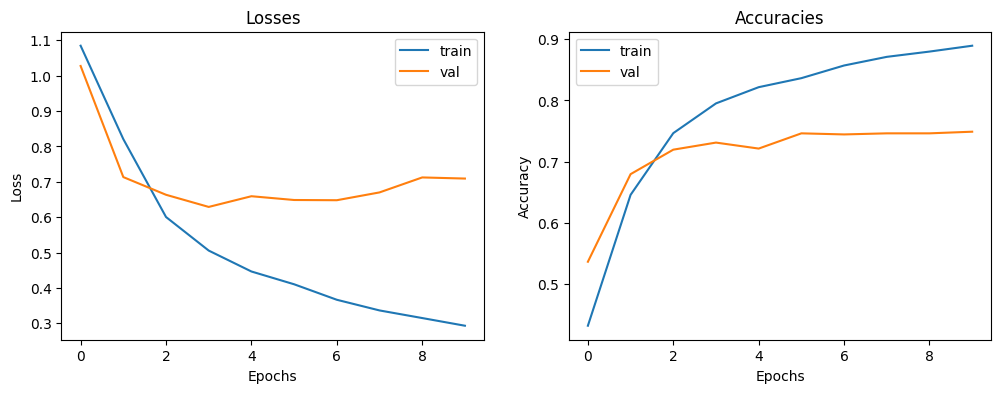

freeze_embedding = False
Test correct = 501

Test total dataitem = 750

Test Accuracy = 0.6679999828338623

              precision    recall  f1-score   support

    negative       0.71      0.64      0.67       250
     neutral       0.62      0.72      0.66       250
    positive       0.69      0.64      0.67       250

    accuracy                           0.67       750
   macro avg       0.67      0.67      0.67       750
weighted avg       0.67      0.67      0.67       750



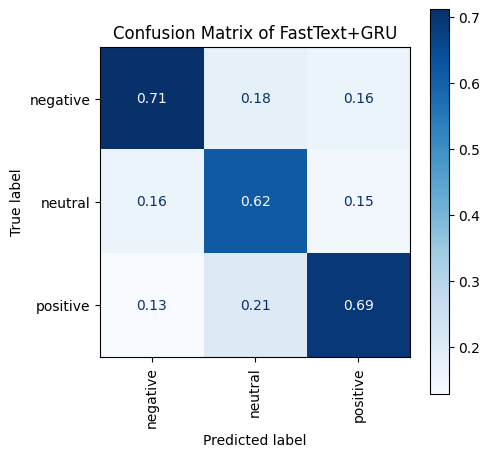

In [ ]:
bidirectional=True
num_layers=3
hidden_size1=128
hidden_size2=256
droprate=0.2
freeze_options=[True,False]
for freeze in freeze_options:
  model=GRU(fasttext_weights,hidden_size1,hidden_size2,freeze,droprate,num_layers,dider=bidirectional).to(device)
  optimizer=optim.Adam(model.parameters(),lr=learning_rate)
  train(model,epoch,optimizer,criterion,train_loader,val_loader)
  model_name='FastText+GRU'
  print(f'freeze_embedding = {freeze}')
  test_and_report(model,test_loader,model_name)

Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 89.07it/s]


loss = 3.3011835652051285, val_loss =1.1038326902448068, accuracy = 0.33652636408805847, val_accuracy = 0.3463935852050781


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 90.32it/s]


loss = 1.1030223792538163, val_loss =1.117029492752183, accuracy = 0.33401381969451904, val_accuracy = 0.31700801849365234


Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 75.84it/s]


loss = 1.102403922667727, val_loss =1.1009363979308142, accuracy = 0.3220791518688202, val_accuracy = 0.31700801849365234


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 60.81it/s]


loss = 1.101637212933856, val_loss =1.1014139735428172, accuracy = 0.33008792996406555, val_accuracy = 0.31878897547721863


Epoch 5: 100%|██████████| 100/100 [00:01<00:00, 50.15it/s]


loss = 1.1012972582195653, val_loss =1.1008836012865817, accuracy = 0.33527010679244995, val_accuracy = 0.3357079327106476


Epoch 6: 100%|██████████| 100/100 [00:01<00:00, 50.41it/s]


loss = 1.1015821987390517, val_loss =1.0998464855380239, accuracy = 0.32537686824798584, val_accuracy = 0.3357079327106476


Epoch 7: 100%|██████████| 100/100 [00:01<00:00, 75.27it/s]


loss = 1.1167768477275968, val_loss =1.0989347211780056, accuracy = 0.3310301601886749, val_accuracy = 0.3357079327106476


Epoch 8: 100%|██████████| 100/100 [00:01<00:00, 76.38it/s]


loss = 1.1027131729805841, val_loss =1.1083315021964528, accuracy = 0.3310301601886749, val_accuracy = 0.31700801849365234


Epoch 9: 100%|██████████| 100/100 [00:01<00:00, 76.33it/s]


loss = 1.103120190948248, val_loss =1.1053375708116662, accuracy = 0.329773873090744, val_accuracy = 0.3357079327106476


Epoch 10: 100%|██████████| 100/100 [00:01<00:00, 69.59it/s]
<ipython-input-24-a92860fd3f0c>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 1.1024375201854855, val_loss =1.0994816745202691, accuracy = 0.3280464708805084, val_accuracy = 0.34728407859802246


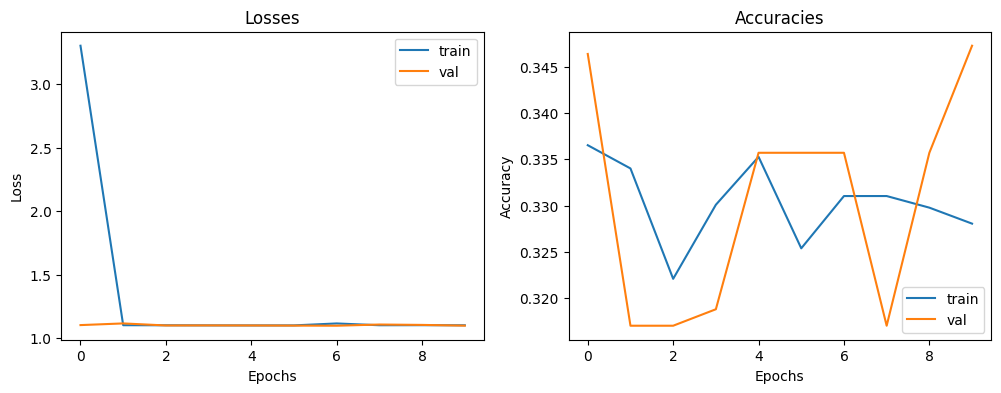

learning_rate = 0.1
Test correct = 250

Test total dataitem = 750

Test Accuracy = 0.3333333432674408

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       250
     neutral       0.00      0.00      0.00       250
    positive       0.33      1.00      0.50       250

    accuracy                           0.33       750
   macro avg       0.11      0.33      0.17       750
weighted avg       0.11      0.33      0.17       750



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


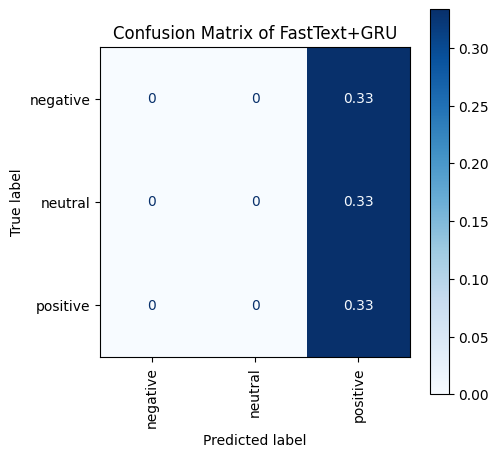

Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 83.26it/s]


loss = 0.8472472716205266, val_loss =0.6736669989484769, accuracy = 0.6174622774124146, val_accuracy = 0.7016919255256653


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 78.90it/s]


loss = 0.5822025082099072, val_loss =0.6286614414945935, accuracy = 0.7683731317520142, val_accuracy = 0.7444345951080322


Epoch 3: 100%|██████████| 100/100 [00:02<00:00, 47.35it/s]


loss = 0.44940793982487776, val_loss =0.6598847498772528, accuracy = 0.8293027281761169, val_accuracy = 0.7061442732810974


Epoch 4: 100%|██████████| 100/100 [00:02<00:00, 44.85it/s]


loss = 0.3766095838527573, val_loss =0.6740683005667817, accuracy = 0.858668327331543, val_accuracy = 0.7230632305145264


Epoch 5: 100%|██████████| 100/100 [00:01<00:00, 74.59it/s]


loss = 0.3302140592317738, val_loss =0.7241500412217658, accuracy = 0.8753140568733215, val_accuracy = 0.7061442732810974


Epoch 6: 100%|██████████| 100/100 [00:01<00:00, 66.24it/s]


loss = 0.30002602768132036, val_loss =0.8987252067585568, accuracy = 0.8856784105300903, val_accuracy = 0.7114871144294739


Epoch 7: 100%|██████████| 100/100 [00:01<00:00, 71.89it/s]


loss = 0.277951697518878, val_loss =0.9474858100198497, accuracy = 0.891331672668457, val_accuracy = 0.7248441576957703


Epoch 8: 100%|██████████| 100/100 [00:01<00:00, 69.25it/s]


loss = 0.2670120124922154, val_loss =0.7941261162357718, accuracy = 0.8966708183288574, val_accuracy = 0.7114871144294739


Epoch 9: 100%|██████████| 100/100 [00:01<00:00, 64.76it/s]


loss = 0.2760109743154215, val_loss =0.7986085069600306, accuracy = 0.8947864174842834, val_accuracy = 0.70970618724823


Epoch 10: 100%|██████████| 100/100 [00:01<00:00, 65.91it/s]


loss = 0.26439334994789404, val_loss =0.9715278176507967, accuracy = 0.9012248516082764, val_accuracy = 0.7070347666740417


<ipython-input-24-a92860fd3f0c>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


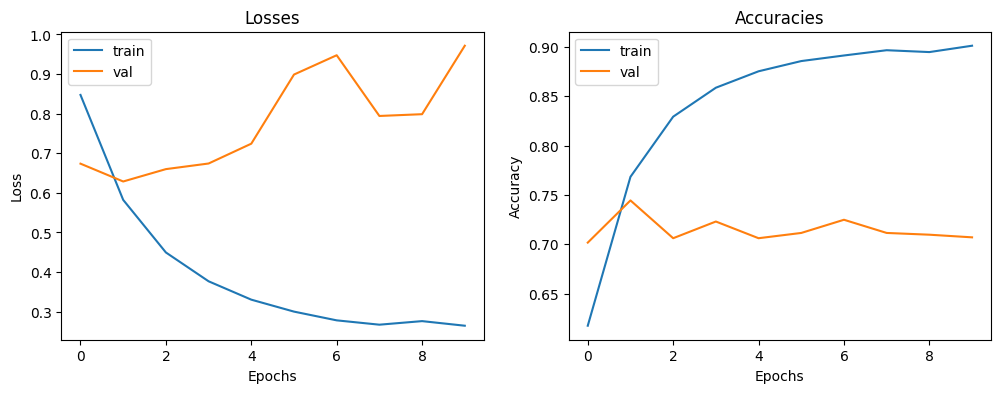

learning_rate = 0.01
Test correct = 452

Test total dataitem = 750

Test Accuracy = 0.6026666760444641

              precision    recall  f1-score   support

    negative       0.77      0.44      0.56       250
     neutral       0.58      0.65      0.61       250
    positive       0.54      0.72      0.62       250

    accuracy                           0.60       750
   macro avg       0.63      0.60      0.60       750
weighted avg       0.63      0.60      0.60       750



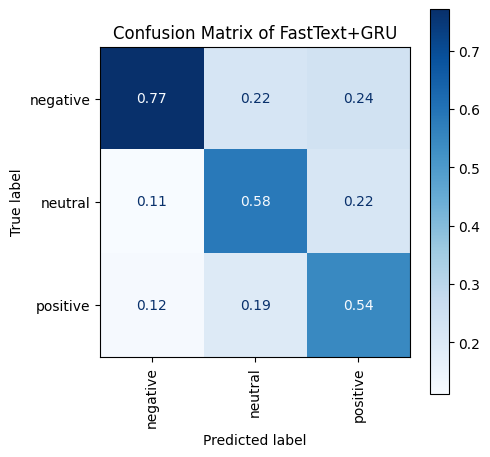

Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 84.90it/s]


loss = 0.8101455644059752, val_loss =0.6406067712318974, accuracy = 0.6124371886253357, val_accuracy = 0.7266251444816589


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 86.17it/s]


loss = 0.5091773135981339, val_loss =0.6011739659824848, accuracy = 0.7923994660377502, val_accuracy = 0.7524487972259521


Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 87.62it/s]


loss = 0.38815034272992577, val_loss =0.6550908245499332, accuracy = 0.8429648280143738, val_accuracy = 0.7408726811408997


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 94.98it/s]


loss = 0.3102839123072593, val_loss =0.6260161656101662, accuracy = 0.8771984577178955, val_accuracy = 0.7444345951080322


Epoch 5: 100%|██████████| 100/100 [00:01<00:00, 94.90it/s]


loss = 0.26576744254422385, val_loss =0.6636808539732036, accuracy = 0.8935301303863525, val_accuracy = 0.7444345951080322


Epoch 6: 100%|██████████| 100/100 [00:01<00:00, 95.09it/s]


loss = 0.22672875921155722, val_loss =0.7845912010567742, accuracy = 0.910804033279419, val_accuracy = 0.7399821877479553


Epoch 7: 100%|██████████| 100/100 [00:01<00:00, 95.57it/s]


loss = 0.18583883560614975, val_loss =0.8515715312564837, accuracy = 0.9269786477088928, val_accuracy = 0.7292965650558472


Epoch 8: 100%|██████████| 100/100 [00:01<00:00, 94.34it/s]


loss = 0.16814175514495086, val_loss =0.8971831781230873, accuracy = 0.9356155395507812, val_accuracy = 0.7275155782699585


Epoch 9: 100%|██████████| 100/100 [00:01<00:00, 95.61it/s]


loss = 0.14648275296876873, val_loss =0.9144414707129427, accuracy = 0.9433103203773499, val_accuracy = 0.7399821877479553


Epoch 10: 100%|██████████| 100/100 [00:01<00:00, 95.76it/s]
<ipython-input-24-a92860fd3f0c>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.12549332727606738, val_loss =1.0200952482074432, accuracy = 0.9502198100090027, val_accuracy = 0.7248441576957703


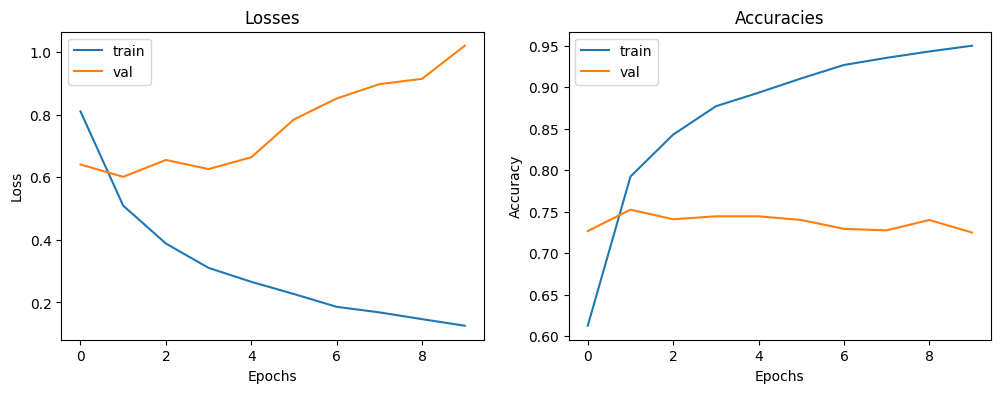

learning_rate = 0.001
Test correct = 446

Test total dataitem = 750

Test Accuracy = 0.5946666598320007

              precision    recall  f1-score   support

    negative       0.69      0.45      0.54       250
     neutral       0.57      0.64      0.60       250
    positive       0.57      0.70      0.63       250

    accuracy                           0.59       750
   macro avg       0.61      0.59      0.59       750
weighted avg       0.61      0.59      0.59       750



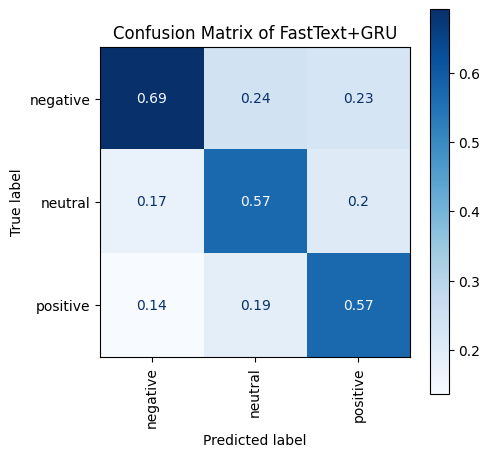

Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 95.05it/s]


loss = 0.7646226196970383, val_loss =0.6305439668384578, accuracy = 0.6557788848876953, val_accuracy = 0.7390917539596558


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 87.62it/s]


loss = 0.4853842893101546, val_loss =0.5756527559502819, accuracy = 0.8035489916801453, val_accuracy = 0.7506678700447083


Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 86.37it/s]


loss = 0.3690608764333598, val_loss =0.6619260690344624, accuracy = 0.8520728349685669, val_accuracy = 0.7275155782699585


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 86.05it/s]


loss = 0.2896789771623793, val_loss =0.7380766390102205, accuracy = 0.884736180305481, val_accuracy = 0.74799644947052


Epoch 5: 100%|██████████| 100/100 [00:01<00:00, 91.27it/s]


loss = 0.24299797246164018, val_loss =0.6991871405860884, accuracy = 0.9073492288589478, val_accuracy = 0.7292965650558472


Epoch 6: 100%|██████████| 100/100 [00:01<00:00, 95.44it/s]


loss = 0.2034356903192733, val_loss =0.7551269152208461, accuracy = 0.9181846380233765, val_accuracy = 0.7355298399925232


Epoch 7: 100%|██████████| 100/100 [00:01<00:00, 95.84it/s]


loss = 0.16985724304903357, val_loss =0.9024351051866165, accuracy = 0.9345163106918335, val_accuracy = 0.7408726811408997


Epoch 8: 100%|██████████| 100/100 [00:01<00:00, 95.51it/s]


loss = 0.14898978573785984, val_loss =1.3486254315663297, accuracy = 0.9417399168014526, val_accuracy = 0.7364203333854675


Epoch 9: 100%|██████████| 100/100 [00:01<00:00, 95.66it/s]


loss = 0.12542557528929554, val_loss =1.1657576856460983, accuracy = 0.9514760971069336, val_accuracy = 0.7462155222892761


Epoch 10: 100%|██████████| 100/100 [00:01<00:00, 95.36it/s]
<ipython-input-24-a92860fd3f0c>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.11415624996093145, val_loss =1.1377487767802659, accuracy = 0.9560301303863525, val_accuracy = 0.7399821877479553


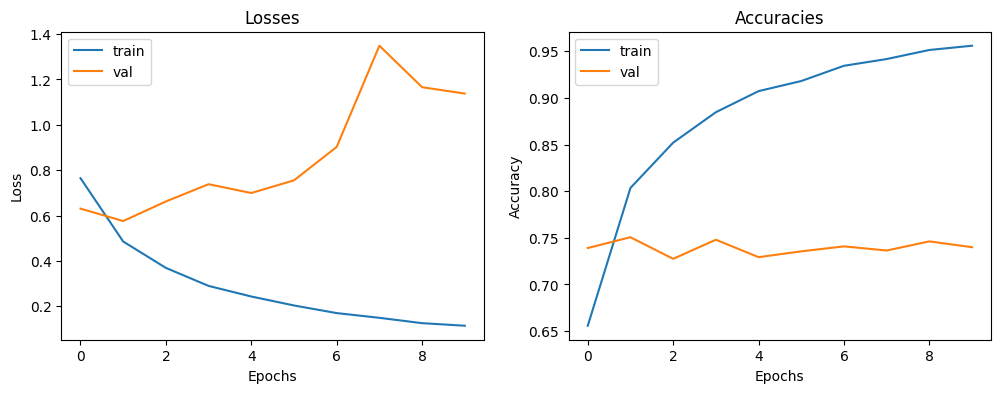

learning_rate = 0.002
Test correct = 460

Test total dataitem = 750

Test Accuracy = 0.6133333444595337

              precision    recall  f1-score   support

    negative       0.69      0.49      0.57       250
     neutral       0.58      0.70      0.63       250
    positive       0.61      0.65      0.63       250

    accuracy                           0.61       750
   macro avg       0.62      0.61      0.61       750
weighted avg       0.62      0.61      0.61       750



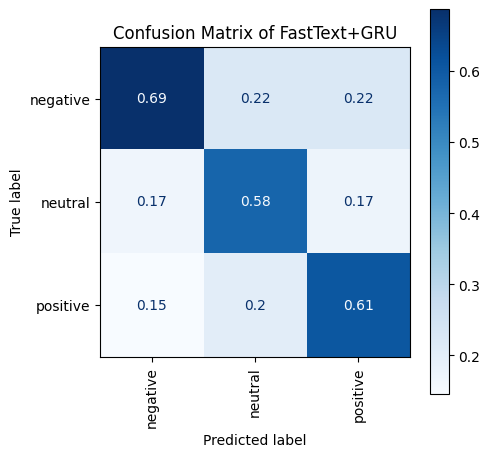

Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 95.64it/s]


loss = 0.8032681987353135, val_loss =0.6287975449348793, accuracy = 0.6276695728302002, val_accuracy = 0.7382012605667114


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 94.84it/s]


loss = 0.5104545350741614, val_loss =0.5981783356095606, accuracy = 0.7991520166397095, val_accuracy = 0.7462155222892761


Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 92.67it/s]


loss = 0.3545254989662317, val_loss =0.6144449895109256, accuracy = 0.8630653023719788, val_accuracy = 0.7560107111930847


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 88.88it/s]


loss = 0.2692189373865008, val_loss =0.732221114877474, accuracy = 0.8987122774124146, val_accuracy = 0.7301869988441467


Epoch 5: 100%|██████████| 100/100 [00:01<00:00, 88.06it/s]


loss = 0.22119862098710513, val_loss =0.834757280201269, accuracy = 0.913316547870636, val_accuracy = 0.7364203333854675


Epoch 6: 100%|██████████| 100/100 [00:01<00:00, 84.35it/s]


loss = 0.1902104693797784, val_loss =0.9693499038956893, accuracy = 0.9272927045822144, val_accuracy = 0.7284060716629028


Epoch 7: 100%|██████████| 100/100 [00:01<00:00, 93.89it/s]


loss = 0.1627321570922568, val_loss =1.0977727572753975, accuracy = 0.9378140568733215, val_accuracy = 0.7284060716629028


Epoch 8: 100%|██████████| 100/100 [00:01<00:00, 95.39it/s]


loss = 0.1243246336655871, val_loss =1.0707660317939631, accuracy = 0.9513190984725952, val_accuracy = 0.7390917539596558


Epoch 9: 100%|██████████| 100/100 [00:01<00:00, 95.20it/s]


loss = 0.13352949826679947, val_loss =1.0154900407654648, accuracy = 0.9506909251213074, val_accuracy = 0.7346394062042236


Epoch 10: 100%|██████████| 100/100 [00:01<00:00, 94.65it/s]
<ipython-input-24-a92860fd3f0c>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.12824430203453296, val_loss =1.1866824966088274, accuracy = 0.947864294052124, val_accuracy = 0.7453250288963318


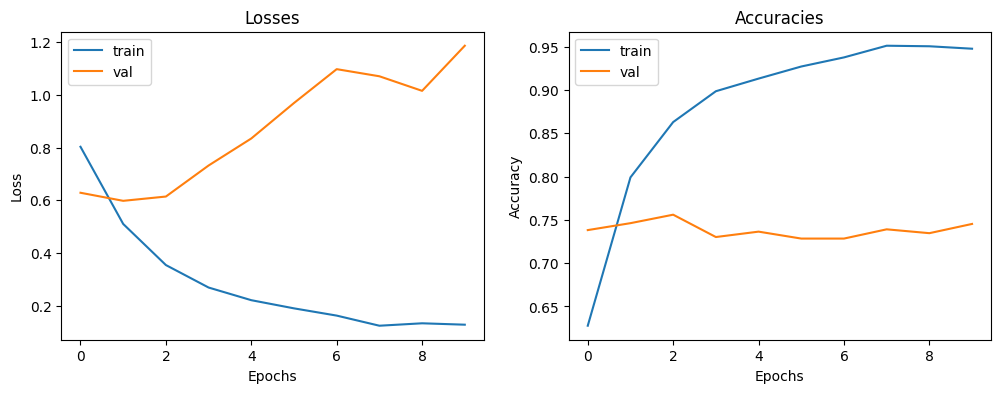

learning_rate = 0.003
Test correct = 452

Test total dataitem = 750

Test Accuracy = 0.6026666760444641

              precision    recall  f1-score   support

    negative       0.77      0.46      0.58       250
     neutral       0.57      0.64      0.61       250
    positive       0.55      0.70      0.62       250

    accuracy                           0.60       750
   macro avg       0.63      0.60      0.60       750
weighted avg       0.63      0.60      0.60       750



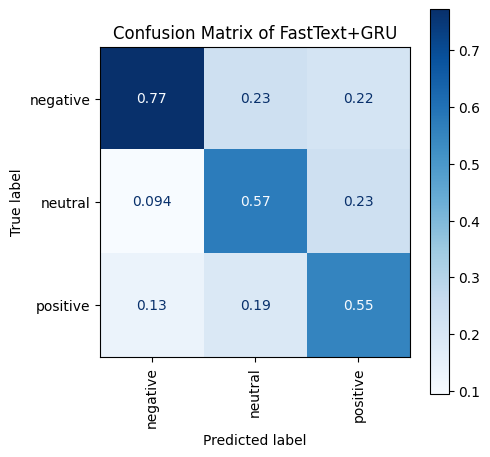

Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 95.82it/s]


loss = 1.0788386799395084, val_loss =1.0069453047218895, accuracy = 0.44723618030548096, val_accuracy = 0.5004452466964722


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 96.00it/s]


loss = 0.8323927740729414, val_loss =0.744057199131653, accuracy = 0.6224874258041382, val_accuracy = 0.6687444448471069


Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 96.51it/s]


loss = 0.628673049203353, val_loss =0.6470222367085553, accuracy = 0.7281721234321594, val_accuracy = 0.7177203893661499


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 95.67it/s]


loss = 0.5269883264652708, val_loss =0.6267694261270547, accuracy = 0.7889447212219238, val_accuracy = 0.7390917539596558


Epoch 5: 100%|██████████| 100/100 [00:01<00:00, 90.49it/s]


loss = 0.46221257178829545, val_loss =0.6105031100431063, accuracy = 0.8120288848876953, val_accuracy = 0.7390917539596558


Epoch 6: 100%|██████████| 100/100 [00:01<00:00, 86.73it/s]


loss = 0.41707932529738173, val_loss =0.6156711457906726, accuracy = 0.8341708183288574, val_accuracy = 0.74799644947052


Epoch 7: 100%|██████████| 100/100 [00:01<00:00, 86.84it/s]


loss = 0.3872317407360492, val_loss =0.6138982201410229, accuracy = 0.8479899168014526, val_accuracy = 0.7453250288963318


Epoch 8: 100%|██████████| 100/100 [00:01<00:00, 88.35it/s]


loss = 0.3560940711888406, val_loss =0.6198544436855602, accuracy = 0.8603957295417786, val_accuracy = 0.74799644947052


Epoch 9: 100%|██████████| 100/100 [00:01<00:00, 95.69it/s]


loss = 0.3227865945965729, val_loss =0.6499816615662254, accuracy = 0.8740577697753906, val_accuracy = 0.7390917539596558


Epoch 10: 100%|██████████| 100/100 [00:01<00:00, 95.34it/s]
<ipython-input-24-a92860fd3f0c>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.308225750392096, val_loss =0.7315657190227061, accuracy = 0.8826947212219238, val_accuracy = 0.7230632305145264


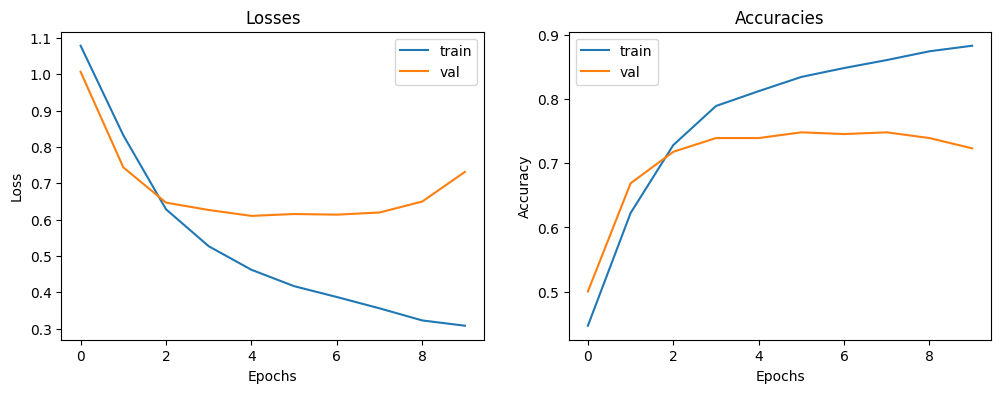

learning_rate = 0.0001
Test correct = 445

Test total dataitem = 750

Test Accuracy = 0.5933333039283752

              precision    recall  f1-score   support

    negative       0.79      0.40      0.53       250
     neutral       0.54      0.75      0.63       250
    positive       0.57      0.63      0.60       250

    accuracy                           0.59       750
   macro avg       0.63      0.59      0.59       750
weighted avg       0.63      0.59      0.59       750



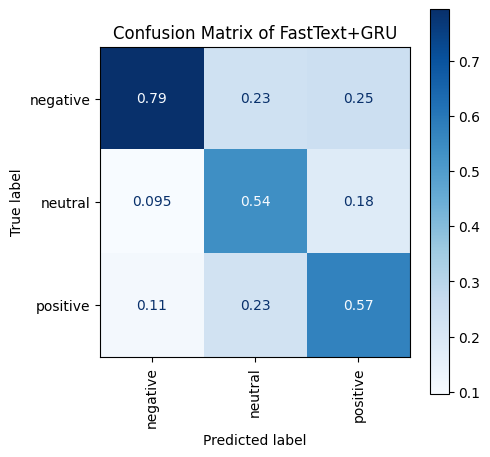

Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 96.46it/s]


loss = 1.0198062561033294, val_loss =0.8278468160808736, accuracy = 0.48853641748428345, val_accuracy = 0.62600177526474


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 95.67it/s]


loss = 0.6502241877227789, val_loss =0.659369883869381, accuracy = 0.7242462038993835, val_accuracy = 0.7034728527069092


Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 95.50it/s]


loss = 0.49949171273467075, val_loss =0.6098430073761212, accuracy = 0.7949120402336121, val_accuracy = 0.741763174533844


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 95.75it/s]


loss = 0.42013546696725146, val_loss =0.6196865221487662, accuracy = 0.8332286477088928, val_accuracy = 0.7408726811408997


Epoch 5: 100%|██████████| 100/100 [00:01<00:00, 95.36it/s]


loss = 0.36194006649550714, val_loss =0.6352153128569282, accuracy = 0.8581972122192383, val_accuracy = 0.7453250288963318


Epoch 6: 100%|██████████| 100/100 [00:01<00:00, 95.56it/s]


loss = 0.32296222198774044, val_loss =0.6801588757188441, accuracy = 0.8753140568733215, val_accuracy = 0.7444345951080322


Epoch 7: 100%|██████████| 100/100 [00:01<00:00, 86.26it/s]


loss = 0.2943653495348265, val_loss =0.660070783018348, accuracy = 0.8892902135848999, val_accuracy = 0.7462155222892761


Epoch 8: 100%|██████████| 100/100 [00:01<00:00, 85.93it/s]


loss = 0.26637867936045084, val_loss =0.7263534316927712, accuracy = 0.89777010679245, val_accuracy = 0.7301869988441467


Epoch 9: 100%|██████████| 100/100 [00:01<00:00, 85.19it/s]


loss = 0.2406528166534079, val_loss =0.7479915695075579, accuracy = 0.9040514826774597, val_accuracy = 0.732858419418335


Epoch 10: 100%|██████████| 100/100 [00:01<00:00, 93.19it/s]
<ipython-input-24-a92860fd3f0c>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.2191514832873896, val_loss =0.8093269135536997, accuracy = 0.9137876629829407, val_accuracy = 0.7301869988441467


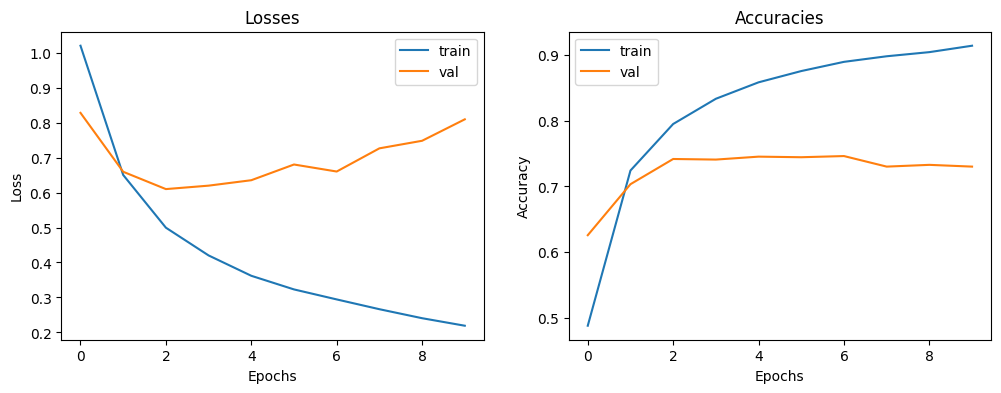

learning_rate = 0.0002
Test correct = 464

Test total dataitem = 750

Test Accuracy = 0.6186666488647461

              precision    recall  f1-score   support

    negative       0.73      0.49      0.59       250
     neutral       0.56      0.75      0.64       250
    positive       0.62      0.62      0.62       250

    accuracy                           0.62       750
   macro avg       0.64      0.62      0.62       750
weighted avg       0.64      0.62      0.62       750



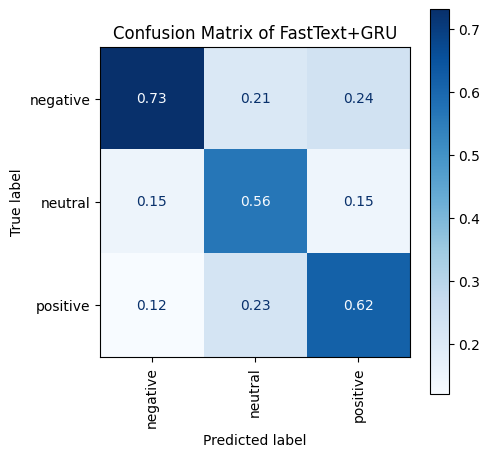

Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 95.47it/s]


loss = 0.9333963865782425, val_loss =0.6930859809837928, accuracy = 0.5336055159568787, val_accuracy = 0.700801432132721


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 94.89it/s]


loss = 0.5751167898645144, val_loss =0.6191354938771895, accuracy = 0.7606784105300903, val_accuracy = 0.7292965650558472


Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 94.80it/s]


loss = 0.45104353964136407, val_loss =0.5873313353311417, accuracy = 0.8179962038993835, val_accuracy = 0.7471059560775757


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 94.88it/s]


loss = 0.37249212734393267, val_loss =0.6355747360804593, accuracy = 0.8548994660377502, val_accuracy = 0.7462155222892761


Epoch 5: 100%|██████████| 100/100 [00:01<00:00, 94.41it/s]


loss = 0.3413490652969594, val_loss =0.6590114667222795, accuracy = 0.8649497628211975, val_accuracy = 0.7488869428634644


Epoch 6: 100%|██████████| 100/100 [00:01<00:00, 95.14it/s]


loss = 0.293853343175755, val_loss =0.6844479814255482, accuracy = 0.8863065242767334, val_accuracy = 0.7408726811408997


Epoch 7: 100%|██████████| 100/100 [00:01<00:00, 94.47it/s]


loss = 0.2591279007478075, val_loss =0.6977900875344466, accuracy = 0.8974560499191284, val_accuracy = 0.7426536083221436


Epoch 8: 100%|██████████| 100/100 [00:01<00:00, 86.63it/s]


loss = 0.2266217958127626, val_loss =0.7614039407683096, accuracy = 0.9130024909973145, val_accuracy = 0.732858419418335


Epoch 9: 100%|██████████| 100/100 [00:01<00:00, 88.14it/s]


loss = 0.20466596426644276, val_loss =0.8059198139115179, accuracy = 0.9195979833602905, val_accuracy = 0.7301869988441467


Epoch 10: 100%|██████████| 100/100 [00:01<00:00, 84.86it/s]
<ipython-input-24-a92860fd3f0c>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.18454425679738837, val_loss =0.8805277828791872, accuracy = 0.9301193356513977, val_accuracy = 0.7310774922370911


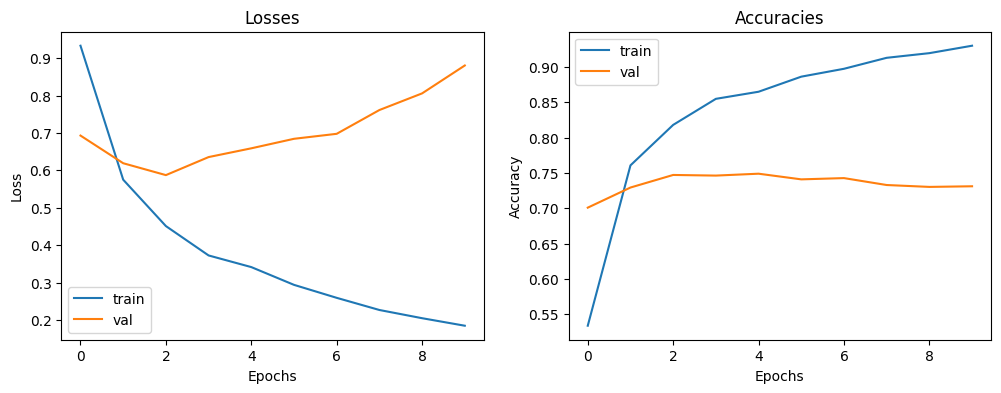

learning_rate = 0.0003
Test correct = 481

Test total dataitem = 750

Test Accuracy = 0.6413333415985107

              precision    recall  f1-score   support

    negative       0.70      0.60      0.64       250
     neutral       0.62      0.66      0.64       250
    positive       0.61      0.67      0.64       250

    accuracy                           0.64       750
   macro avg       0.65      0.64      0.64       750
weighted avg       0.65      0.64      0.64       750



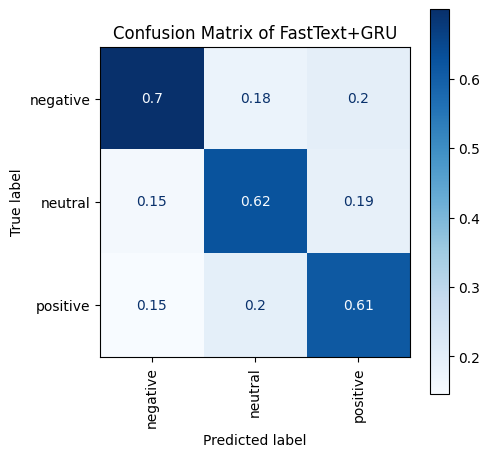

Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 94.81it/s]


loss = 1.0992601892165839, val_loss =1.0978647146226157, accuracy = 0.33260050415992737, val_accuracy = 0.34728407859802246


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 94.45it/s]


loss = 1.0979695799015463, val_loss =1.096650813271602, accuracy = 0.3315012454986572, val_accuracy = 0.34728407859802246


Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 94.76it/s]


loss = 1.0962398721277713, val_loss =1.094896611015475, accuracy = 0.33872488141059875, val_accuracy = 0.3481745421886444


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 93.54it/s]


loss = 1.0933527643233538, val_loss =1.0919152503744476, accuracy = 0.3914887011051178, val_accuracy = 0.43811219930648804


Epoch 5: 100%|██████████| 100/100 [00:01<00:00, 94.81it/s]


loss = 1.0888625467196107, val_loss =1.0861169343607293, accuracy = 0.45854270458221436, val_accuracy = 0.512911856174469


Epoch 6: 100%|██████████| 100/100 [00:01<00:00, 94.90it/s]


loss = 1.08025356980972, val_loss =1.0741592415445855, accuracy = 0.5235552787780762, val_accuracy = 0.5200356245040894


Epoch 7: 100%|██████████| 100/100 [00:01<00:00, 94.62it/s]


loss = 1.0608274315670132, val_loss =1.0476434223738218, accuracy = 0.5493090152740479, val_accuracy = 0.5485307574272156


Epoch 8: 100%|██████████| 100/100 [00:01<00:00, 94.62it/s]


loss = 1.0232173308636994, val_loss =1.0022761343564424, accuracy = 0.570351779460907, val_accuracy = 0.5494211912155151


Epoch 9: 100%|██████████| 100/100 [00:01<00:00, 90.49it/s]


loss = 0.9670185088645666, val_loss =0.9439710365748772, accuracy = 0.5865263938903809, val_accuracy = 0.5583259463310242


Epoch 10: 100%|██████████| 100/100 [00:01<00:00, 88.31it/s]
<ipython-input-24-a92860fd3f0c>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.8993412735802121, val_loss =0.8796267607552369, accuracy = 0.6085113286972046, val_accuracy = 0.6001781225204468


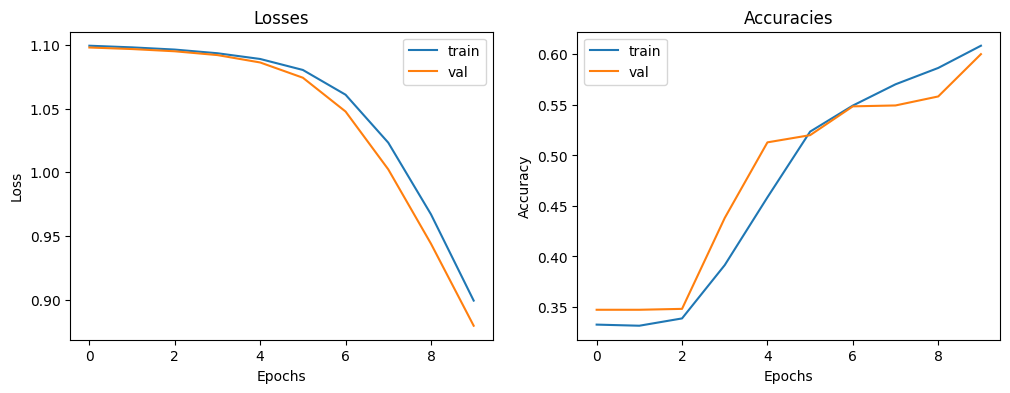

learning_rate = 1e-05
Test correct = 432

Test total dataitem = 750

Test Accuracy = 0.5759999752044678

              precision    recall  f1-score   support

    negative       0.56      0.78      0.65       250
     neutral       0.58      0.61      0.59       250
    positive       0.62      0.34      0.44       250

    accuracy                           0.58       750
   macro avg       0.58      0.58      0.56       750
weighted avg       0.58      0.58      0.56       750



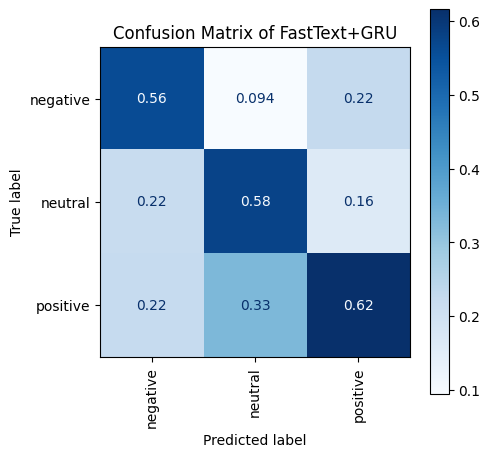

In [ ]:
bidirectional=True
num_layers=3
hidden_size1=128
hidden_size2=256
droprate=0.2
freeze_embedding=False
learning_rates=[0.1,0.01,0.001,0.002,0.003,0.0001,0.0002,0.0003,0.00001]
for learning_rate1 in learning_rates:
  model=GRU(fasttext_weights,hidden_size1,hidden_size2,freeze_embedding,droprate,num_layers,dider=bidirectional).to(device)
  optimizer=optim.Adam(model.parameters(),lr=learning_rate1)
  train(model,epoch,optimizer,criterion,train_loader,val_loader)
  model_name='FastText+GRU'
  print(f'learning_rate = {learning_rate1}')
  test_and_report(model,test_loader,model_name)

Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 88.67it/s]


loss = 0.9418541667814133, val_loss =0.7225019269027388, accuracy = 0.5326632857322693, val_accuracy = 0.6758682131767273


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 94.61it/s]
<ipython-input-24-a92860fd3f0c>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.6048445699968216, val_loss =0.6133706397785563, accuracy = 0.7445037364959717, val_accuracy = 0.7319679856300354


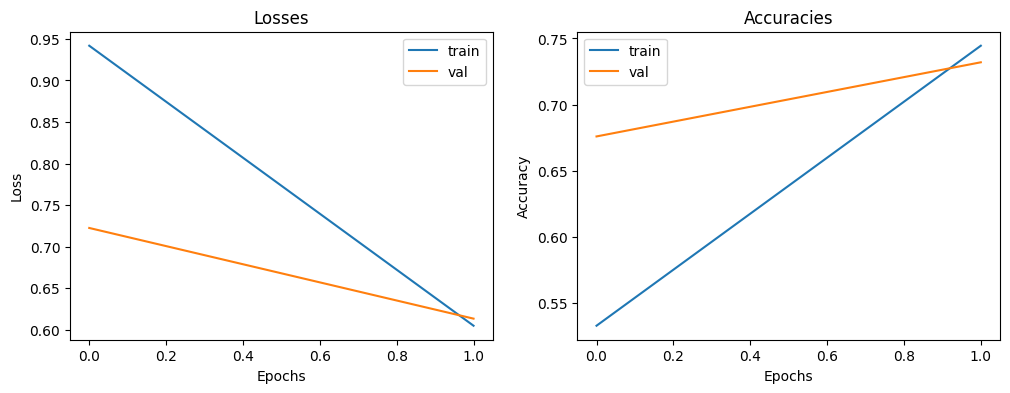

num_epochs = 2
Test correct = 472

Test total dataitem = 750

Test Accuracy = 0.6293333172798157

              precision    recall  f1-score   support

    negative       0.71      0.62      0.66       250
     neutral       0.56      0.78      0.65       250
    positive       0.66      0.49      0.56       250

    accuracy                           0.63       750
   macro avg       0.64      0.63      0.63       750
weighted avg       0.64      0.63      0.63       750



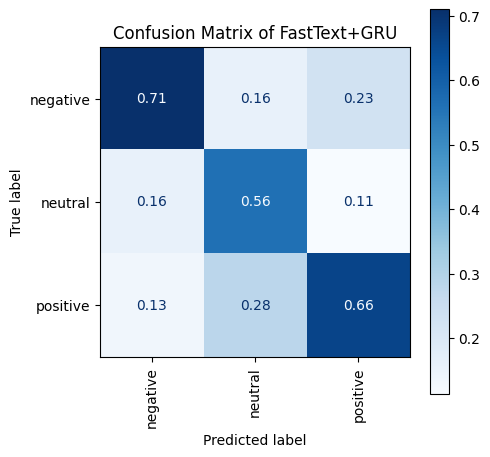

Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 94.82it/s]


loss = 0.9501549050323956, val_loss =0.7282512532412223, accuracy = 0.5191583037376404, val_accuracy = 0.6794301271438599


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 93.73it/s]


loss = 0.6014344709663237, val_loss =0.633352988028526, accuracy = 0.751884400844574, val_accuracy = 0.715939462184906


Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 93.51it/s]
<ipython-input-24-a92860fd3f0c>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.46830199246942356, val_loss =0.6528342084827965, accuracy = 0.8104585409164429, val_accuracy = 0.7301869988441467


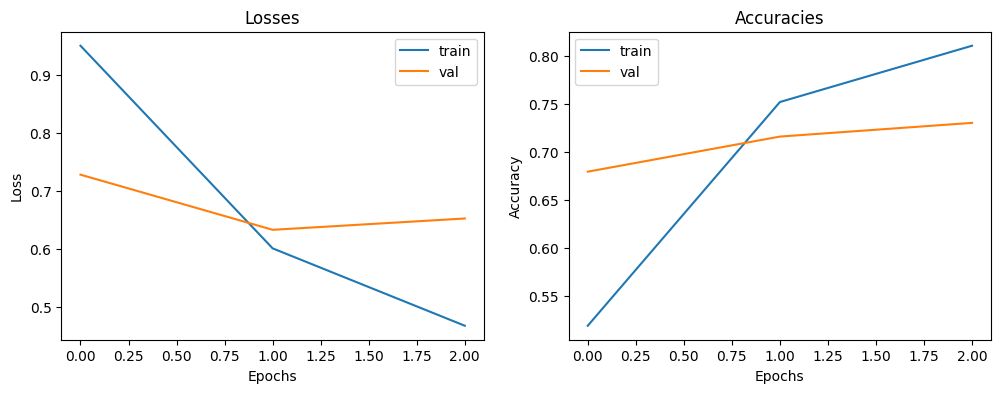

num_epochs = 3
Test correct = 472

Test total dataitem = 750

Test Accuracy = 0.6293333172798157

              precision    recall  f1-score   support

    negative       0.73      0.61      0.66       250
     neutral       0.55      0.80      0.65       250
    positive       0.67      0.48      0.56       250

    accuracy                           0.63       750
   macro avg       0.65      0.63      0.63       750
weighted avg       0.65      0.63      0.63       750



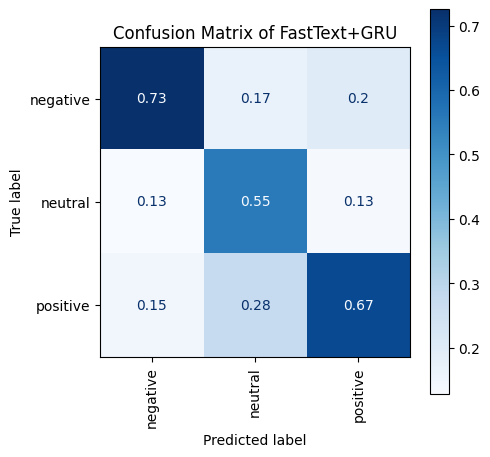

Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 93.85it/s]


loss = 0.9445834340943838, val_loss =0.7713342225237283, accuracy = 0.5321922302246094, val_accuracy = 0.6536064147949219


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 91.09it/s]


loss = 0.5891308108422709, val_loss =0.620771399902783, accuracy = 0.7507851719856262, val_accuracy = 0.7310774922370911


Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 86.47it/s]


loss = 0.45843752796013404, val_loss =0.6063948038484269, accuracy = 0.8156406879425049, val_accuracy = 0.7524487972259521


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 86.74it/s]
<ipython-input-24-a92860fd3f0c>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.3890487869437061, val_loss =0.5972529061546015, accuracy = 0.8443781137466431, val_accuracy = 0.7560107111930847


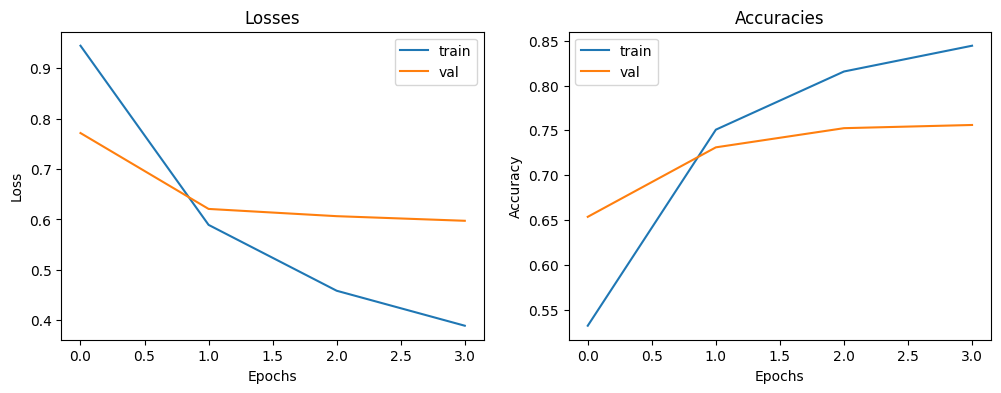

num_epochs = 4
Test correct = 486

Test total dataitem = 750

Test Accuracy = 0.6480000019073486

              precision    recall  f1-score   support

    negative       0.72      0.61      0.66       250
     neutral       0.61      0.71      0.66       250
    positive       0.63      0.63      0.63       250

    accuracy                           0.65       750
   macro avg       0.65      0.65      0.65       750
weighted avg       0.65      0.65      0.65       750



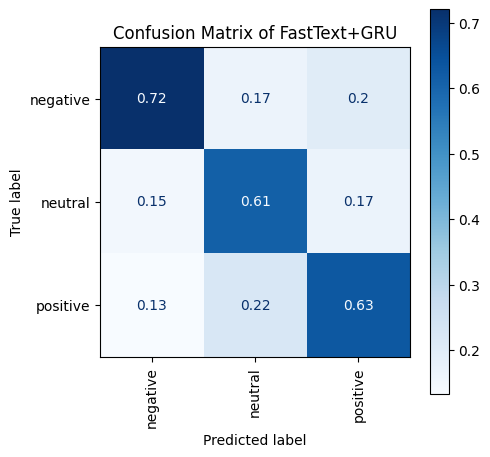

Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 93.63it/s]


loss = 0.9637826869270065, val_loss =0.7218690249535794, accuracy = 0.507851779460907, val_accuracy = 0.6723063588142395


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 93.15it/s]


loss = 0.6090824899077052, val_loss =0.6382824863535274, accuracy = 0.7401067614555359, val_accuracy = 0.7301869988441467


Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 89.66it/s]


loss = 0.47395403885942416, val_loss =0.6055482933351269, accuracy = 0.807945966720581, val_accuracy = 0.7292965650558472


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 93.42it/s]


loss = 0.3931037259543564, val_loss =0.6489157312934803, accuracy = 0.8445351719856262, val_accuracy = 0.7346394062042236


Epoch 5: 100%|██████████| 100/100 [00:01<00:00, 93.26it/s]
<ipython-input-24-a92860fd3f0c>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.3328603647706825, val_loss =0.7551406364815804, accuracy = 0.8693467378616333, val_accuracy = 0.7301869988441467


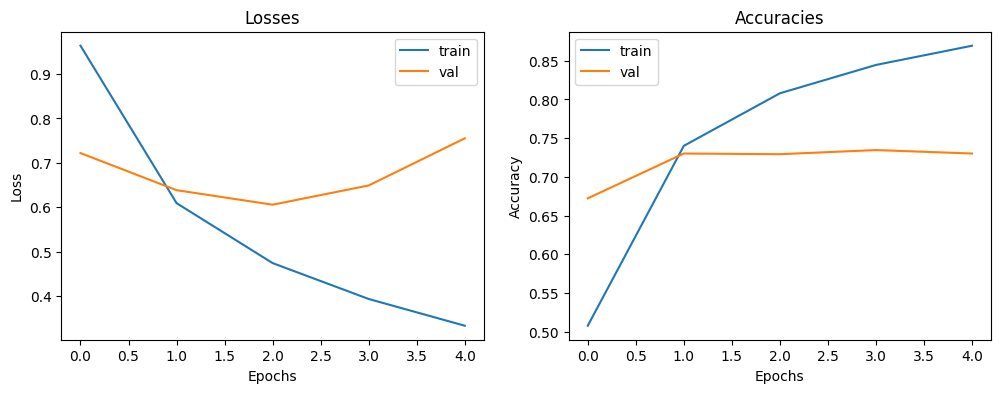

num_epochs = 5
Test correct = 476

Test total dataitem = 750

Test Accuracy = 0.6346666812896729

              precision    recall  f1-score   support

    negative       0.69      0.65      0.67       250
     neutral       0.57      0.76      0.65       250
    positive       0.69      0.49      0.57       250

    accuracy                           0.63       750
   macro avg       0.65      0.63      0.63       750
weighted avg       0.65      0.63      0.63       750



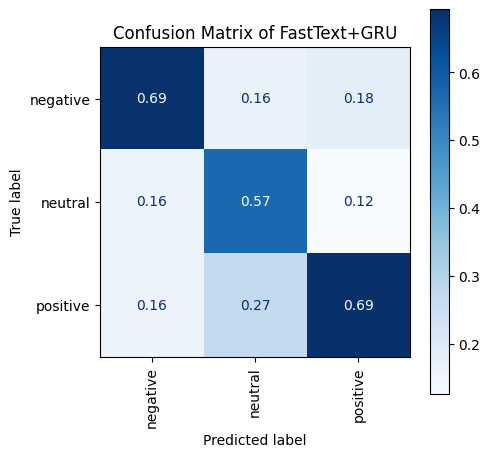

Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 93.47it/s]


loss = 0.9525153475347906, val_loss =0.7210260847785754, accuracy = 0.5202575325965881, val_accuracy = 0.6829919815063477


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 94.01it/s]


loss = 0.6026097982583815, val_loss =0.6295925068789248, accuracy = 0.75, val_accuracy = 0.7275155782699585


Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 93.51it/s]


loss = 0.46302651942514783, val_loss =0.6387316683011603, accuracy = 0.8120288848876953, val_accuracy = 0.7390917539596558


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 86.42it/s]


loss = 0.3878119169266722, val_loss =0.5976934479791907, accuracy = 0.8445351719856262, val_accuracy = 0.7604630589485168


Epoch 5: 100%|██████████| 100/100 [00:01<00:00, 84.59it/s]


loss = 0.32948630884932156, val_loss =0.6315613705320151, accuracy = 0.8687185645103455, val_accuracy = 0.7515583634376526


Epoch 6: 100%|██████████| 100/100 [00:01<00:00, 83.19it/s]
<ipython-input-24-a92860fd3f0c>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.2915176148456393, val_loss =0.6793527436975713, accuracy = 0.8861494660377502, val_accuracy = 0.7364203333854675


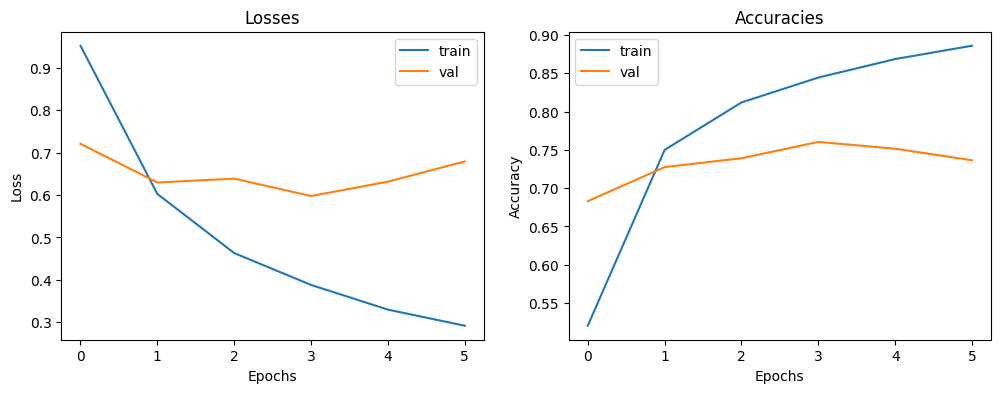

num_epochs = 6
Test correct = 477

Test total dataitem = 750

Test Accuracy = 0.6359999775886536

              precision    recall  f1-score   support

    negative       0.79      0.50      0.61       250
     neutral       0.57      0.78      0.66       250
    positive       0.64      0.63      0.63       250

    accuracy                           0.64       750
   macro avg       0.66      0.64      0.63       750
weighted avg       0.66      0.64      0.63       750



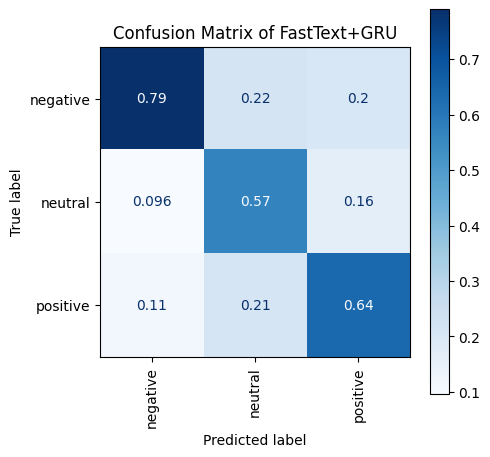

Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 94.65it/s]


loss = 0.942265619795944, val_loss =0.7437814626614526, accuracy = 0.5287374258041382, val_accuracy = 0.6687444448471069


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 94.73it/s]


loss = 0.5908889410639495, val_loss =0.6227276451020266, accuracy = 0.7493718266487122, val_accuracy = 0.7390917539596558


Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 94.71it/s]


loss = 0.45105637784236025, val_loss =0.6013358835355272, accuracy = 0.8190954923629761, val_accuracy = 0.7497773766517639


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 94.50it/s]


loss = 0.3822700648584862, val_loss =0.6526528073933371, accuracy = 0.8440640568733215, val_accuracy = 0.7390917539596558


Epoch 5: 100%|██████████| 100/100 [00:01<00:00, 94.60it/s]


loss = 0.3278922198424203, val_loss =0.6537044158462573, accuracy = 0.8707600235939026, val_accuracy = 0.7471059560775757


Epoch 6: 100%|██████████| 100/100 [00:01<00:00, 94.38it/s]


loss = 0.29651052731375244, val_loss =0.6846783145243488, accuracy = 0.8850502371788025, val_accuracy = 0.7364203333854675


Epoch 7: 100%|██████████| 100/100 [00:01<00:00, 94.92it/s]
<ipython-input-24-a92860fd3f0c>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.2643821575351791, val_loss =0.7220650366202754, accuracy = 0.8946293592453003, val_accuracy = 0.7444345951080322


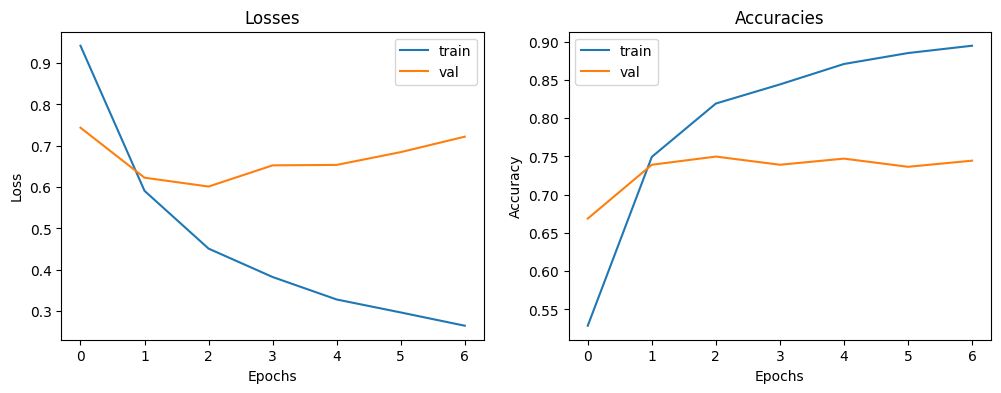

num_epochs = 7
Test correct = 489

Test total dataitem = 750

Test Accuracy = 0.6520000100135803

              precision    recall  f1-score   support

    negative       0.71      0.60      0.65       250
     neutral       0.64      0.68      0.66       250
    positive       0.62      0.67      0.64       250

    accuracy                           0.65       750
   macro avg       0.66      0.65      0.65       750
weighted avg       0.66      0.65      0.65       750



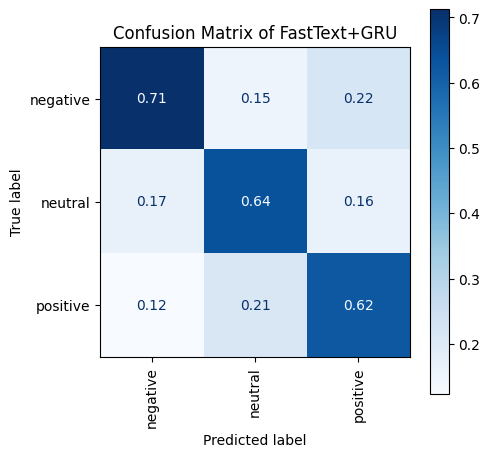

Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 91.93it/s]


loss = 0.9372034661512589, val_loss =0.7207996057938241, accuracy = 0.5320351719856262, val_accuracy = 0.6731967926025391


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 86.11it/s]


loss = 0.5867152780629477, val_loss =0.6083400800453496, accuracy = 0.7523555159568787, val_accuracy = 0.7346394062042236


Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 84.84it/s]


loss = 0.45858394243057776, val_loss =0.6214650877226082, accuracy = 0.8167399168014526, val_accuracy = 0.7382012605667114


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 86.54it/s]


loss = 0.3852253308297111, val_loss =0.6309157163919793, accuracy = 0.8475188612937927, val_accuracy = 0.7337489128112793


Epoch 5: 100%|██████████| 100/100 [00:01<00:00, 95.47it/s]


loss = 0.33418478484174813, val_loss =0.6648540915409427, accuracy = 0.8743718266487122, val_accuracy = 0.7435441017150879


Epoch 6: 100%|██████████| 100/100 [00:01<00:00, 95.21it/s]


loss = 0.29643318103226923, val_loss =0.7438724421017948, accuracy = 0.888033926486969, val_accuracy = 0.7266251444816589


Epoch 7: 100%|██████████| 100/100 [00:01<00:00, 95.85it/s]


loss = 0.2636909724406521, val_loss =0.7308078330882037, accuracy = 0.8974560499191284, val_accuracy = 0.7408726811408997


Epoch 8: 100%|██████████| 100/100 [00:01<00:00, 95.42it/s]
<ipython-input-24-a92860fd3f0c>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.24293414565333024, val_loss =0.7617319939723227, accuracy = 0.9051507711410522, val_accuracy = 0.7221727967262268


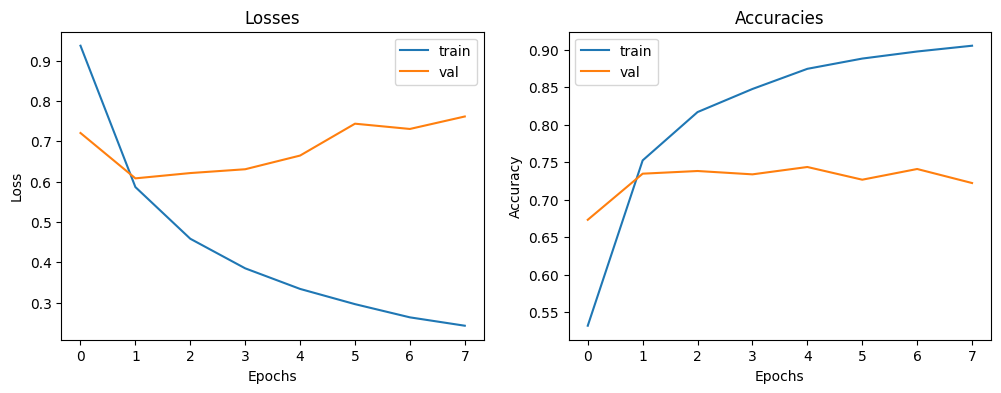

num_epochs = 8
Test correct = 469

Test total dataitem = 750

Test Accuracy = 0.625333309173584

              precision    recall  f1-score   support

    negative       0.72      0.50      0.59       250
     neutral       0.57      0.76      0.65       250
    positive       0.64      0.62      0.63       250

    accuracy                           0.63       750
   macro avg       0.64      0.63      0.62       750
weighted avg       0.64      0.63      0.62       750



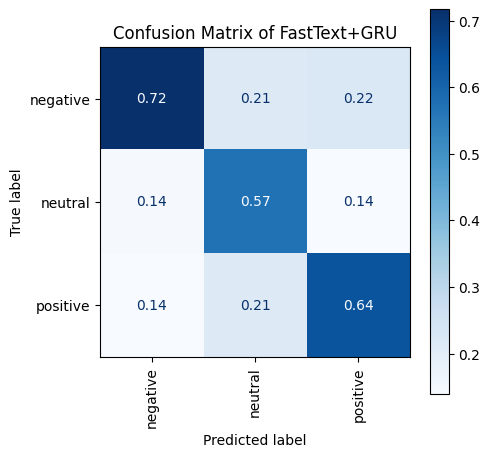

Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 95.93it/s]


loss = 0.9476636696170317, val_loss =0.7191164455797878, accuracy = 0.5309359431266785, val_accuracy = 0.6874443888664246


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 95.98it/s]


loss = 0.5870345081293271, val_loss =0.6311659687547366, accuracy = 0.7622487545013428, val_accuracy = 0.7337489128112793


Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 95.63it/s]


loss = 0.45770920551482047, val_loss =0.6189381788597443, accuracy = 0.8129711151123047, val_accuracy = 0.7488869428634644


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 95.61it/s]


loss = 0.38575411716048136, val_loss =0.6952137949219717, accuracy = 0.8465766310691833, val_accuracy = 0.7275155782699585


Epoch 5: 100%|██████████| 100/100 [00:01<00:00, 87.98it/s]


loss = 0.3301148998083406, val_loss =0.6474746675375762, accuracy = 0.8706030249595642, val_accuracy = 0.7524487972259521


Epoch 6: 100%|██████████| 100/100 [00:01<00:00, 85.81it/s]


loss = 0.29509872751882127, val_loss =0.6958959148402211, accuracy = 0.8867776393890381, val_accuracy = 0.7364203333854675


Epoch 7: 100%|██████████| 100/100 [00:01<00:00, 85.74it/s]


loss = 0.26301659082486833, val_loss =0.6909618994578582, accuracy = 0.8958856463432312, val_accuracy = 0.7382012605667114


Epoch 8: 100%|██████████| 100/100 [00:01<00:00, 88.92it/s]


loss = 0.23946544594711663, val_loss =0.7811255546146771, accuracy = 0.9079774022102356, val_accuracy = 0.7266251444816589


Epoch 9: 100%|██████████| 100/100 [00:01<00:00, 95.59it/s]


loss = 0.2145092982809749, val_loss =0.8231138352957144, accuracy = 0.9189698100090027, val_accuracy = 0.7355298399925232


Epoch 10: 100%|██████████| 100/100 [00:01<00:00, 95.89it/s]
<ipython-input-24-a92860fd3f0c>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.19208145527910908, val_loss =0.840341933042724, accuracy = 0.926350474357605, val_accuracy = 0.7292965650558472


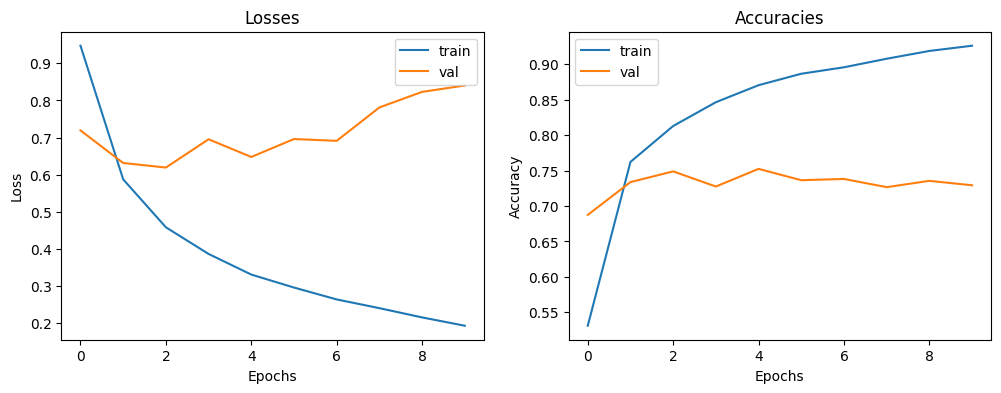

num_epochs = 10
Test correct = 473

Test total dataitem = 750

Test Accuracy = 0.6306666731834412

              precision    recall  f1-score   support

    negative       0.71      0.54      0.62       250
     neutral       0.59      0.74      0.65       250
    positive       0.62      0.61      0.62       250

    accuracy                           0.63       750
   macro avg       0.64      0.63      0.63       750
weighted avg       0.64      0.63      0.63       750



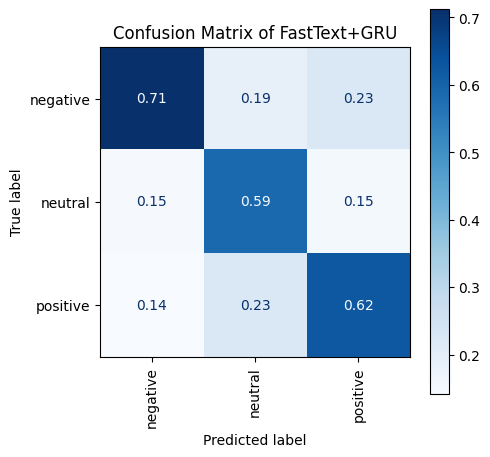

Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 95.30it/s]


loss = 0.955086965507653, val_loss =0.71141859961499, accuracy = 0.5284233689308167, val_accuracy = 0.6945681571960449


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 95.96it/s]


loss = 0.5923138019945691, val_loss =0.6219871871083645, accuracy = 0.7580087780952454, val_accuracy = 0.732858419418335


Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 95.63it/s]


loss = 0.4561489188013934, val_loss =0.6017291367618234, accuracy = 0.8201947212219238, val_accuracy = 0.7435441017150879


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 95.52it/s]


loss = 0.3768822370954589, val_loss =0.6280781251936521, accuracy = 0.8527010083198547, val_accuracy = 0.732858419418335


Epoch 5: 100%|██████████| 100/100 [00:01<00:00, 95.39it/s]


loss = 0.3367802201076317, val_loss =0.6366401113721921, accuracy = 0.8702889084815979, val_accuracy = 0.7551202178001404


Epoch 6: 100%|██████████| 100/100 [00:01<00:00, 95.39it/s]


loss = 0.28052717269784777, val_loss =0.7036145842776849, accuracy = 0.8886620402336121, val_accuracy = 0.7506678700447083


Epoch 7: 100%|██████████| 100/100 [00:01<00:00, 86.49it/s]


loss = 0.2576068985738306, val_loss =0.7121585991635757, accuracy = 0.9012248516082764, val_accuracy = 0.7382012605667114


Epoch 8: 100%|██████████| 100/100 [00:01<00:00, 86.04it/s]


loss = 0.2350870424692533, val_loss =0.7675837190105418, accuracy = 0.9115892052650452, val_accuracy = 0.7292965650558472


Epoch 9: 100%|██████████| 100/100 [00:01<00:00, 85.97it/s]


loss = 0.21646745616001348, val_loss =0.7680372782080146, accuracy = 0.9203831553459167, val_accuracy = 0.7275155782699585


Epoch 10: 100%|██████████| 100/100 [00:01<00:00, 88.61it/s]


loss = 0.2021887940198085, val_loss =0.884977553369447, accuracy = 0.9247801303863525, val_accuracy = 0.7337489128112793


Epoch 11: 100%|██████████| 100/100 [00:01<00:00, 95.59it/s]


loss = 0.169802298506251, val_loss =0.9299074159626232, accuracy = 0.9335741400718689, val_accuracy = 0.7284060716629028


Epoch 12: 100%|██████████| 100/100 [00:01<00:00, 95.10it/s]
<ipython-input-24-a92860fd3f0c>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.16181777656624674, val_loss =1.0291470134403928, accuracy = 0.9396984577178955, val_accuracy = 0.7275155782699585


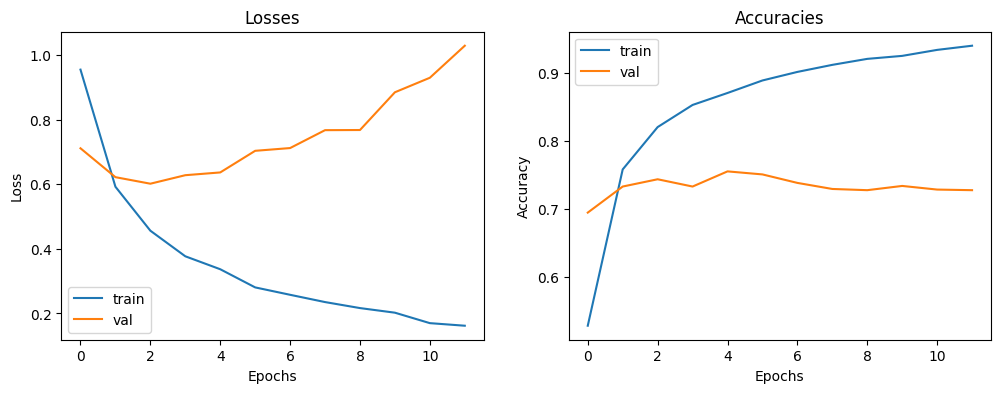

num_epochs = 12
Test correct = 473

Test total dataitem = 750

Test Accuracy = 0.6306666731834412

              precision    recall  f1-score   support

    negative       0.71      0.56      0.63       250
     neutral       0.59      0.72      0.65       250
    positive       0.62      0.61      0.61       250

    accuracy                           0.63       750
   macro avg       0.64      0.63      0.63       750
weighted avg       0.64      0.63      0.63       750



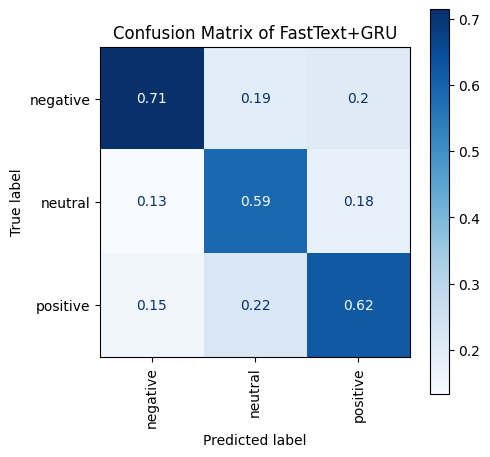

Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 95.61it/s]


loss = 0.9591201689303852, val_loss =0.7222133696274666, accuracy = 0.5168027877807617, val_accuracy = 0.6883348226547241


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 95.65it/s]


loss = 0.5984679198657795, val_loss =0.6079579828213947, accuracy = 0.7459170818328857, val_accuracy = 0.732858419418335


Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 95.43it/s]


loss = 0.46446405062690244, val_loss =0.6723999068506327, accuracy = 0.8118718266487122, val_accuracy = 0.7292965650558472


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 95.60it/s]


loss = 0.39073712127814164, val_loss =0.6254424686369584, accuracy = 0.8484610319137573, val_accuracy = 0.7230632305145264


Epoch 5: 100%|██████████| 100/100 [00:01<00:00, 91.88it/s]


loss = 0.3398098309879134, val_loss =0.6402625067360724, accuracy = 0.8643215894699097, val_accuracy = 0.7524487972259521


Epoch 6: 100%|██████████| 100/100 [00:01<00:00, 61.91it/s]


loss = 0.29187061029740813, val_loss =0.6785409123214172, accuracy = 0.8863065242767334, val_accuracy = 0.7301869988441467


Epoch 7: 100%|██████████| 100/100 [00:02<00:00, 45.07it/s]


loss = 0.26332261386909656, val_loss =0.7871464974756148, accuracy = 0.8958856463432312, val_accuracy = 0.7230632305145264


Epoch 8: 100%|██████████| 100/100 [00:02<00:00, 48.39it/s]


loss = 0.226383760955138, val_loss =0.8338552206740935, accuracy = 0.915986180305481, val_accuracy = 0.7257346510887146


Epoch 9: 100%|██████████| 100/100 [00:01<00:00, 52.89it/s]


loss = 0.21003525837678488, val_loss =0.7866221862357318, accuracy = 0.9183416962623596, val_accuracy = 0.7319679856300354


Epoch 10: 100%|██████████| 100/100 [00:01<00:00, 70.63it/s]


loss = 0.19243087108114978, val_loss =0.9151497418401396, accuracy = 0.9247801303863525, val_accuracy = 0.7275155782699585


Epoch 11: 100%|██████████| 100/100 [00:01<00:00, 67.49it/s]


loss = 0.17978880529015911, val_loss =0.9379243078434037, accuracy = 0.9307474493980408, val_accuracy = 0.7248441576957703


Epoch 12: 100%|██████████| 100/100 [00:01<00:00, 76.57it/s]


loss = 0.15894531862290637, val_loss =1.021433253331695, accuracy = 0.9387562870979309, val_accuracy = 0.7319679856300354


Epoch 13: 100%|██████████| 100/100 [00:01<00:00, 70.29it/s]


loss = 0.1467559290501081, val_loss =1.1257032649854533, accuracy = 0.9451947212219238, val_accuracy = 0.7301869988441467


Epoch 14: 100%|██████████| 100/100 [00:01<00:00, 69.98it/s]


loss = 0.13633710918940142, val_loss =1.0892093342848204, accuracy = 0.9444095492362976, val_accuracy = 0.7257346510887146


Epoch 15: 100%|██████████| 100/100 [00:01<00:00, 65.80it/s]
<ipython-input-24-a92860fd3f0c>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.12318779616161755, val_loss =1.1745295890993628, accuracy = 0.9536746144294739, val_accuracy = 0.7248441576957703


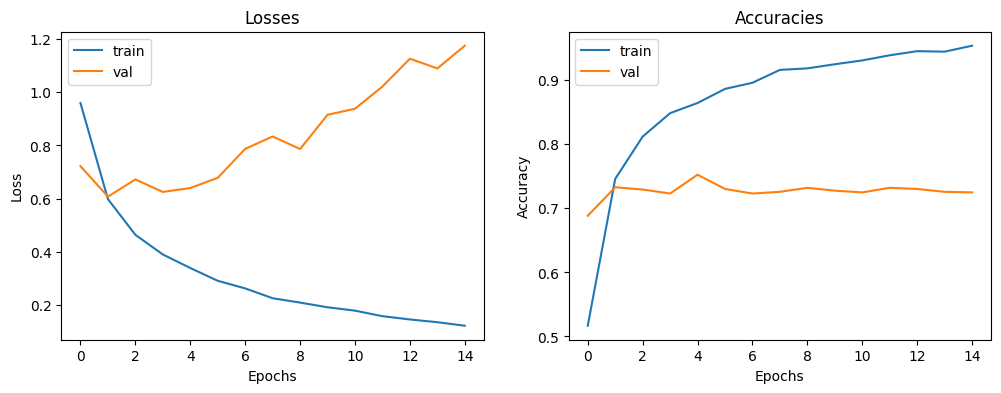

num_epochs = 15
Test correct = 468

Test total dataitem = 750

Test Accuracy = 0.6240000128746033

              precision    recall  f1-score   support

    negative       0.72      0.52      0.60       250
     neutral       0.59      0.70      0.64       250
    positive       0.60      0.65      0.63       250

    accuracy                           0.62       750
   macro avg       0.64      0.62      0.62       750
weighted avg       0.64      0.62      0.62       750



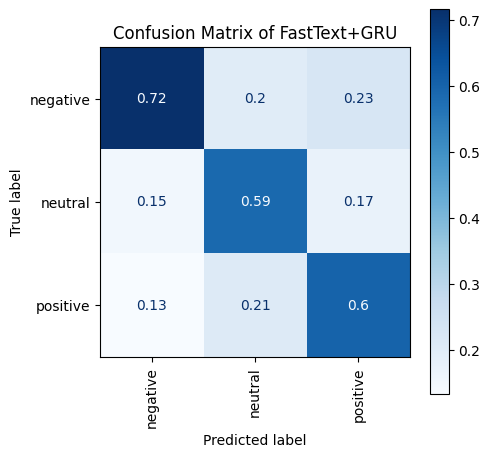

Epoch 1: 100%|██████████| 100/100 [00:02<00:00, 42.94it/s]


loss = 0.9473684357031016, val_loss =0.7062960652331683, accuracy = 0.5243404507637024, val_accuracy = 0.6865538954734802


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 64.96it/s]


loss = 0.5988349804926475, val_loss =0.6341719964054406, accuracy = 0.7463881969451904, val_accuracy = 0.7319679856300354


Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 63.01it/s]


loss = 0.4585514380817676, val_loss =0.595197655886021, accuracy = 0.8129711151123047, val_accuracy = 0.7515583634376526


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 74.89it/s]


loss = 0.38151366671531034, val_loss =0.6218020427076844, accuracy = 0.8492462038993835, val_accuracy = 0.7506678700447083


Epoch 5: 100%|██████████| 100/100 [00:01<00:00, 73.38it/s]


loss = 0.32794146465447255, val_loss =0.6505048762507497, accuracy = 0.8710741400718689, val_accuracy = 0.7488869428634644


Epoch 6: 100%|██████████| 100/100 [00:01<00:00, 75.81it/s]


loss = 0.28343511611351846, val_loss =0.6816722193440071, accuracy = 0.8905465006828308, val_accuracy = 0.7488869428634644


Epoch 7: 100%|██████████| 100/100 [00:01<00:00, 92.27it/s]


loss = 0.25889083986403066, val_loss =0.7407644451129178, accuracy = 0.8966708183288574, val_accuracy = 0.732858419418335


Epoch 8: 100%|██████████| 100/100 [00:01<00:00, 94.04it/s]


loss = 0.23878252234455316, val_loss =0.779356801895102, accuracy = 0.9056218266487122, val_accuracy = 0.7337489128112793


Epoch 9: 100%|██████████| 100/100 [00:01<00:00, 86.69it/s]


loss = 0.20956927438087827, val_loss =0.8791797469405115, accuracy = 0.9184987545013428, val_accuracy = 0.7177203893661499


Epoch 10: 100%|██████████| 100/100 [00:01<00:00, 86.69it/s]


loss = 0.18666143548082023, val_loss =0.9106965706408724, accuracy = 0.9261934757232666, val_accuracy = 0.7284060716629028


Epoch 11: 100%|██████████| 100/100 [00:01<00:00, 83.96it/s]


loss = 0.1683775314976253, val_loss =0.9721887792913222, accuracy = 0.9362437129020691, val_accuracy = 0.7310774922370911


Epoch 12: 100%|██████████| 100/100 [00:01<00:00, 88.94it/s]


loss = 0.15784643044577845, val_loss =1.0461970622018133, accuracy = 0.9411118030548096, val_accuracy = 0.7257346510887146


Epoch 13: 100%|██████████| 100/100 [00:01<00:00, 94.16it/s]


loss = 0.1557078452036013, val_loss =1.0187890579142067, accuracy = 0.9385992288589478, val_accuracy = 0.7195013761520386


Epoch 14: 100%|██████████| 100/100 [00:01<00:00, 93.42it/s]


loss = 0.13799116709828116, val_loss =1.0585981031362155, accuracy = 0.9470791220664978, val_accuracy = 0.7310774922370911


Epoch 15: 100%|██████████| 100/100 [00:01<00:00, 94.48it/s]


loss = 0.12495972754843908, val_loss =1.2182834214477358, accuracy = 0.9532034993171692, val_accuracy = 0.7301869988441467


Epoch 16: 100%|██████████| 100/100 [00:01<00:00, 93.56it/s]


loss = 0.12535792907960513, val_loss =1.2164959568201208, accuracy = 0.9533605575561523, val_accuracy = 0.7177203893661499


Epoch 17: 100%|██████████| 100/100 [00:01<00:00, 94.35it/s]


loss = 0.11417451843666679, val_loss =1.2881082777424127, accuracy = 0.9536746144294739, val_accuracy = 0.7292965650558472


Epoch 18: 100%|██████████| 100/100 [00:01<00:00, 94.36it/s]
<ipython-input-24-a92860fd3f0c>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.11360846774913086, val_loss =1.259640489385844, accuracy = 0.9541457295417786, val_accuracy = 0.7301869988441467


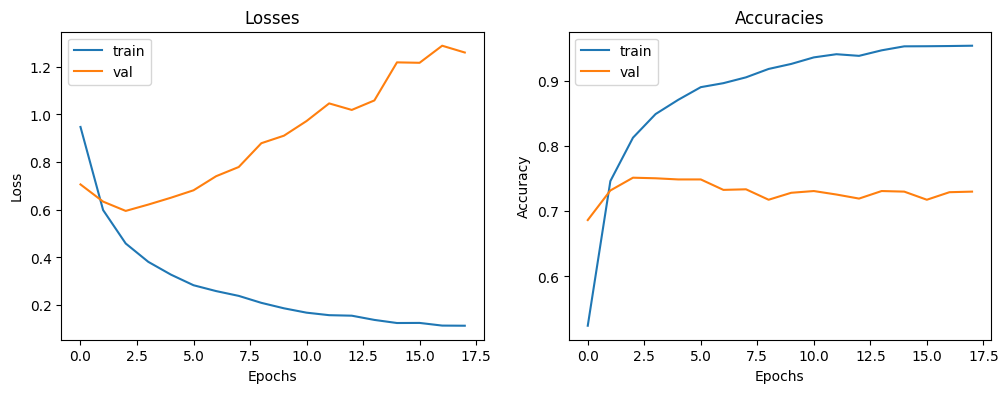

num_epochs = 18
Test correct = 457

Test total dataitem = 750

Test Accuracy = 0.609333336353302

              precision    recall  f1-score   support

    negative       0.76      0.47      0.58       250
     neutral       0.58      0.68      0.62       250
    positive       0.56      0.68      0.62       250

    accuracy                           0.61       750
   macro avg       0.63      0.61      0.61       750
weighted avg       0.63      0.61      0.61       750



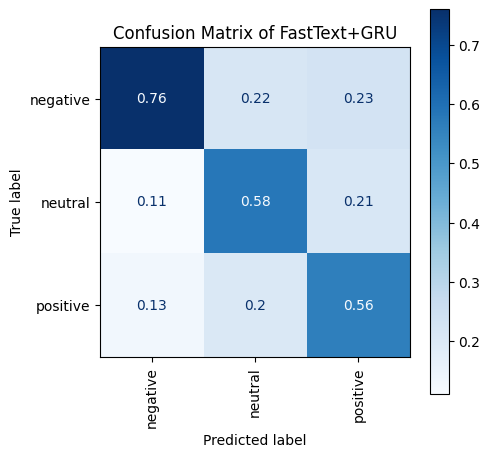

Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 94.29it/s]


loss = 0.9393738585876418, val_loss =0.7620066355369219, accuracy = 0.5405150651931763, val_accuracy = 0.6607301831245422


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 88.63it/s]


loss = 0.5945907850983713, val_loss =0.6129122069855738, accuracy = 0.7547110319137573, val_accuracy = 0.7337489128112793


Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 84.03it/s]


loss = 0.4535842792498352, val_loss =0.6112214760392175, accuracy = 0.8164258599281311, val_accuracy = 0.7524487972259521


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 84.93it/s]


loss = 0.3827382592811949, val_loss =0.6107900512683675, accuracy = 0.848304033279419, val_accuracy = 0.7515583634376526


Epoch 5: 100%|██████████| 100/100 [00:01<00:00, 86.03it/s]


loss = 0.3371843269435865, val_loss =0.6275297918330107, accuracy = 0.8688756227493286, val_accuracy = 0.74799644947052


Epoch 6: 100%|██████████| 100/100 [00:01<00:00, 94.39it/s]


loss = 0.28865519058362926, val_loss =0.6530086648887514, accuracy = 0.8894472122192383, val_accuracy = 0.741763174533844


Epoch 7: 100%|██████████| 100/100 [00:01<00:00, 94.42it/s]


loss = 0.25893185983401384, val_loss =0.7083647846702804, accuracy = 0.9012248516082764, val_accuracy = 0.741763174533844


Epoch 8: 100%|██████████| 100/100 [00:01<00:00, 94.10it/s]


loss = 0.23575230136398903, val_loss =0.7281508797202739, accuracy = 0.909547746181488, val_accuracy = 0.7364203333854675


Epoch 9: 100%|██████████| 100/100 [00:01<00:00, 94.15it/s]


loss = 0.20972839755579037, val_loss =0.8530793120261182, accuracy = 0.9208542704582214, val_accuracy = 0.7257346510887146


Epoch 10: 100%|██████████| 100/100 [00:01<00:00, 94.32it/s]


loss = 0.1932288530079128, val_loss =0.8567748520913827, accuracy = 0.9254083037376404, val_accuracy = 0.7355298399925232


Epoch 11: 100%|██████████| 100/100 [00:01<00:00, 93.58it/s]


loss = 0.1711965480050691, val_loss =0.9539231771662559, accuracy = 0.9351444840431213, val_accuracy = 0.7266251444816589


Epoch 12: 100%|██████████| 100/100 [00:01<00:00, 93.84it/s]


loss = 0.1575674428395925, val_loss =0.9665596601187469, accuracy = 0.9418969750404358, val_accuracy = 0.7266251444816589


Epoch 13: 100%|██████████| 100/100 [00:01<00:00, 94.24it/s]


loss = 0.14655497642722784, val_loss =1.0735030698751657, accuracy = 0.9428392052650452, val_accuracy = 0.7266251444816589


Epoch 14: 100%|██████████| 100/100 [00:01<00:00, 90.61it/s]


loss = 0.1475018274878795, val_loss =1.0194471755348455, accuracy = 0.942054033279419, val_accuracy = 0.7257346510887146


Epoch 15: 100%|██████████| 100/100 [00:01<00:00, 86.61it/s]


loss = 0.12728823181147925, val_loss =1.0790505180069951, accuracy = 0.9522612690925598, val_accuracy = 0.7310774922370911


Epoch 16: 100%|██████████| 100/100 [00:01<00:00, 85.16it/s]


loss = 0.12475537755619058, val_loss =1.0960697655361014, accuracy = 0.9519472122192383, val_accuracy = 0.7301869988441467


Epoch 17: 100%|██████████| 100/100 [00:01<00:00, 82.43it/s]


loss = 0.10866439251079782, val_loss =1.256826731534973, accuracy = 0.9565012454986572, val_accuracy = 0.7195013761520386


Epoch 18: 100%|██████████| 100/100 [00:01<00:00, 94.38it/s]


loss = 0.10796305718410647, val_loss =1.2672907606570956, accuracy = 0.9554020166397095, val_accuracy = 0.7284060716629028


Epoch 19: 100%|██████████| 100/100 [00:01<00:00, 94.39it/s]


loss = 0.11514583961905116, val_loss =1.2908197381708428, accuracy = 0.955716073513031, val_accuracy = 0.7284060716629028


Epoch 20: 100%|██████████| 100/100 [00:01<00:00, 94.58it/s]
<ipython-input-24-a92860fd3f0c>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.10555396822584001, val_loss =1.2586695924079006, accuracy = 0.9582286477088928, val_accuracy = 0.7203918099403381


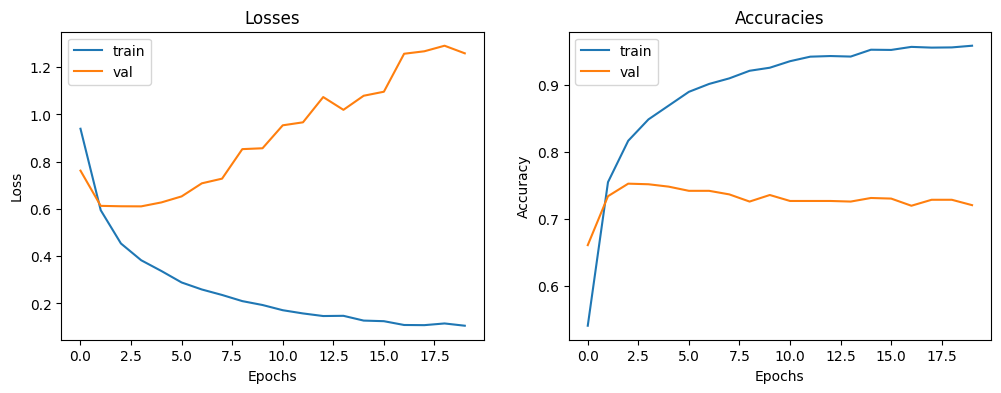

num_epochs = 20
Test correct = 469

Test total dataitem = 750

Test Accuracy = 0.625333309173584

              precision    recall  f1-score   support

    negative       0.70      0.54      0.61       250
     neutral       0.62      0.63      0.62       250
    positive       0.59      0.71      0.64       250

    accuracy                           0.63       750
   macro avg       0.63      0.63      0.62       750
weighted avg       0.63      0.63      0.62       750



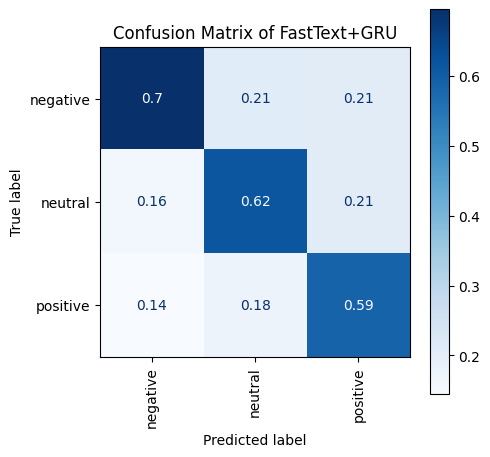

In [ ]:
bidirectional=True
num_layers=3
hidden_size1=128
hidden_size2=256
droprate=0.3
freeze_embedding=False
learning_rate=0.0003
bidirectional_options=[True,False]
num_epochs=[2,3,4,5,6,7,8,10,12,15,18,20]
for num_epoch in num_epochs:
  model=GRU(fasttext_weights,hidden_size1,hidden_size2,freeze_embedding,droprate,num_layers,dider=bidirectional).to(device)
  optimizer=optim.Adam(model.parameters(),lr=learning_rate)
  train(model,num_epoch,optimizer,criterion,train_loader,val_loader)
  model_name='FastText+GRU'
  print(f'num_epochs = {num_epoch}')
  test_and_report(model,test_loader,model_name)

Epoch 1: 100%|██████████| 118/118 [00:01<00:00, 89.24it/s]


loss = 0.9111271844238341, accuracy = 0.5546655654907227


Epoch 2: 100%|██████████| 118/118 [00:01<00:00, 95.39it/s]


loss = 0.564962598277215, accuracy = 0.7647843956947327


Epoch 3: 100%|██████████| 118/118 [00:01<00:00, 87.79it/s]


loss = 0.4549754994205591, accuracy = 0.8153784275054932


Epoch 4: 100%|██████████| 118/118 [00:01<00:00, 87.17it/s]


loss = 0.38063416514525394, accuracy = 0.8446134924888611


Epoch 5: 100%|██████████| 118/118 [00:01<00:00, 88.38it/s]


loss = 0.3311673718657135, accuracy = 0.8722466826438904


Epoch 6: 100%|██████████| 118/118 [00:01<00:00, 95.35it/s]


loss = 0.29344582094928795, accuracy = 0.8831931352615356


Epoch 7: 100%|██████████| 118/118 [00:01<00:00, 94.75it/s]
<ipython-input-24-a92860fd3f0c>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.2667079528783102, accuracy = 0.896275520324707


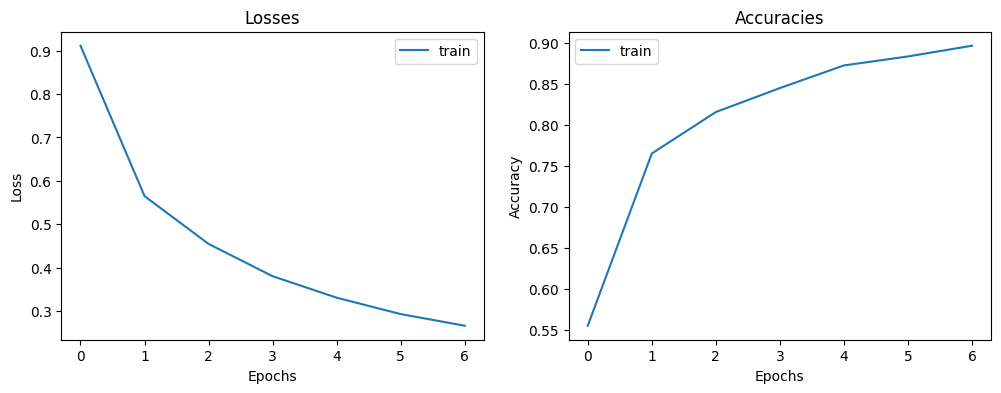

Test correct = 474

Test total dataitem = 750

Test Accuracy = 0.6319999694824219

              precision    recall  f1-score   support

    negative       0.71      0.56      0.63       250
     neutral       0.59      0.71      0.64       250
    positive       0.62      0.63      0.62       250

    accuracy                           0.63       750
   macro avg       0.64      0.63      0.63       750
weighted avg       0.64      0.63      0.63       750



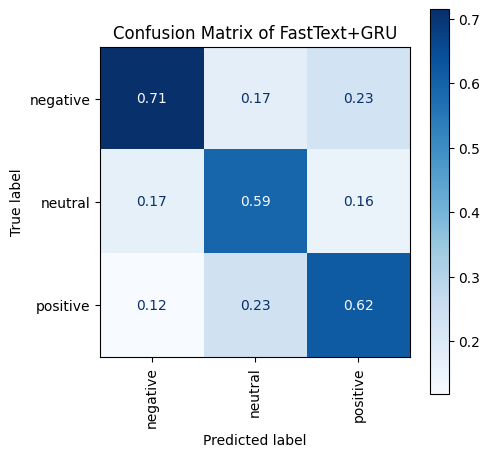

In [ ]:
bidirectional=True
num_layers=3
hidden_size1=128
hidden_size2=256
droprate=0.2
freeze_embedding=False
learning_rate=0.0003
epoch=7
model=GRU(fasttext_weights,hidden_size1,hidden_size2,freeze_embedding,droprate,num_layers,dider=bidirectional).to(device)
optimizer=optim.Adam(model.parameters(),lr=learning_rate)
train(model,epoch,optimizer,criterion,full_dataloader)
model_name='FastText+GRU'
test_and_report(model,test_loader,model_name)

# Attention

In [ ]:
class AttentionLayer(nn.Module):
    def __init__(self, gru_size):
        super(AttentionLayer, self).__init__()
        self.U = nn.Linear(gru_size, 1,bias=False) # for the learnable paramter u
        torch.nn.init.xavier_normal_(self.U.weight)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, hidden_states):
        # α = softmax(u_t^T U)
        attention_weights = self.U(hidden_states) # (batch_size, seq_len ,1)
        attention_weights = self.softmax(attention_weights.squeeze(2))  # (batch_size, seq_len)

        # eq.11: v = sum( α * hidden_states )
        attention_output = hidden_states * attention_weights.unsqueeze(2)  # (batch_size, seq_len, gru_size)
        attention_output = attention_output.sum(dim = 1)  # (batch_size, gru_size)

        return attention_output, attention_weights

In [ ]:
class AttentionGRU(nn.Module):
  def __init__(self,fasttext_weights,hidden_size1,hidden_size2,freeze_embedding=True,droprate=0.5,num_layers=1,num_classes=3,dider=True):
    super(AttentionGRU,self).__init__()
    self.embedding=nn.Embedding.from_pretrained(torch.FloatTensor(fasttext_weights),freeze=freeze_embedding)
    self.gru=nn.GRU(self.embedding.embedding_dim,hidden_size1,num_layers,batch_first=True,bidirectional=dider)
    self.dropout=nn.Dropout(droprate)
    self.d=2 if dider else 1
    self.attention=AttentionLayer(hidden_size1*self.d)
    self.fc1=nn.Linear(hidden_size1*self.d,hidden_size2)
    self.fc2=nn.Linear(hidden_size2,num_classes)

    #torch.nn.init.xavier_uniform_(self.fc1.weight)
    #torch.nn.init.xavier_uniform_(self.fc2.weight)

  def forward(self,x):
    x=self.embedding(x)
    x,h=self.gru(x)
    x,attention_weights=self.attention(x)
    x=self.fc1(x)
    x=F.relu(x)
    x=self.dropout(x)
    x=self.fc2(x)
    return x,attention_weights

You're on a cuda


Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 78.45it/s]


loss = 0.9937934130523354, val_loss =0.7396746367322824, accuracy = 0.4722047746181488, val_accuracy = 0.6785396337509155


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 92.70it/s]


loss = 0.6117447362274107, val_loss =0.5846795369574495, accuracy = 0.7478014826774597, val_accuracy = 0.7604630589485168


Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 92.83it/s]


loss = 0.47989690754166076, val_loss =0.5758192773284145, accuracy = 0.8093593120574951, val_accuracy = 0.7595725655555725


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 92.87it/s]


loss = 0.39310791242856796, val_loss =0.5923163784542166, accuracy = 0.8473618030548096, val_accuracy = 0.7666963934898376


Epoch 5: 100%|██████████| 100/100 [00:01<00:00, 92.85it/s]


loss = 0.34275492504619254, val_loss =0.6112165443322247, accuracy = 0.8669912219047546, val_accuracy = 0.7577916383743286


Epoch 6: 100%|██████████| 100/100 [00:01<00:00, 92.28it/s]


loss = 0.2941697361593947, val_loss =0.6974896081252255, accuracy = 0.8861494660377502, val_accuracy = 0.7453250288963318


Epoch 7: 100%|██████████| 100/100 [00:01<00:00, 92.30it/s]
<ipython-input-24-a92860fd3f0c>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.27578527302286376, val_loss =0.667844916573382, accuracy = 0.895100474357605, val_accuracy = 0.74799644947052


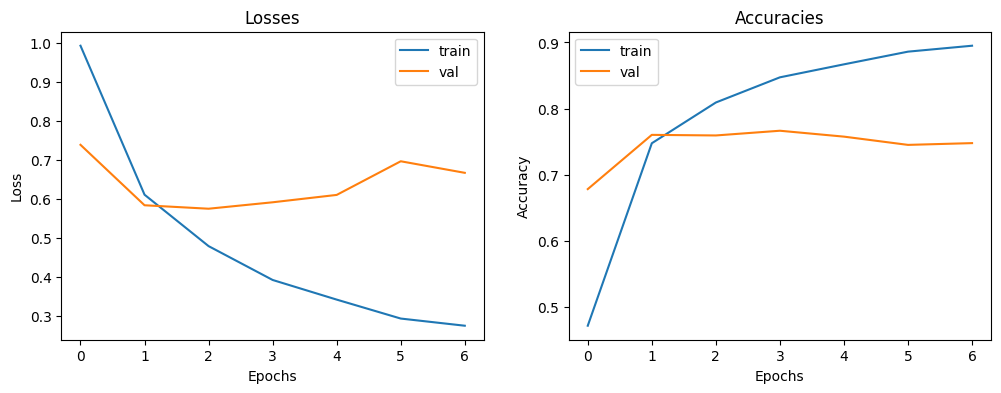

Test correct = 484

Test total dataitem = 750

Test Accuracy = 0.6453333497047424

              precision    recall  f1-score   support

    negative       0.71      0.60      0.65       250
     neutral       0.61      0.70      0.65       250
    positive       0.63      0.64      0.63       250

    accuracy                           0.65       750
   macro avg       0.65      0.65      0.65       750
weighted avg       0.65      0.65      0.65       750



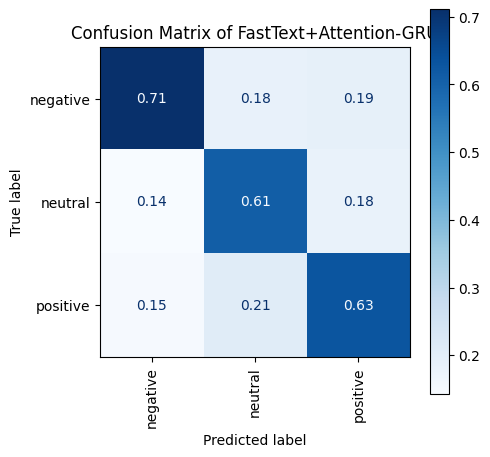

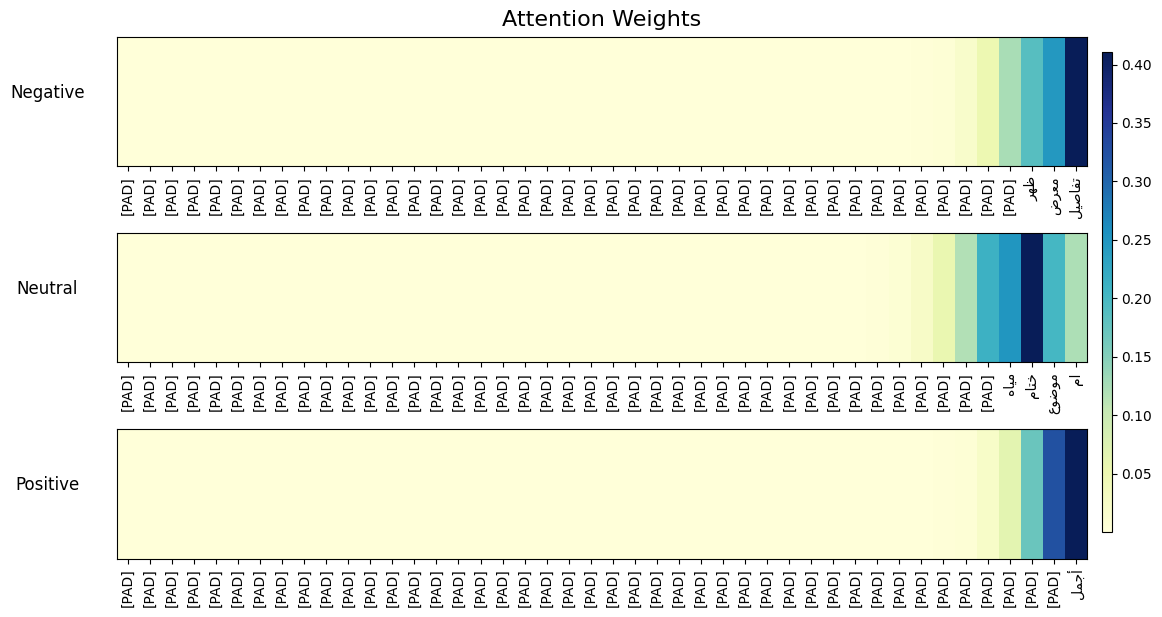

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"You're on a {device}")
bidirectional=True
num_layers=3
hidden_size1=128
hidden_size2=256
droprate=0.2
freeze_embedding=False
learning_rate=0.0003
epoch=7

model=AttentionGRU(fasttext_weights,hidden_size1,hidden_size2,freeze_embedding,droprate,num_layers,dider=bidirectional).to(device)
optimizer=optim.Adam(model.parameters(),lr=learning_rate) # play around this also
criterion=nn.CrossEntropyLoss()
train(model,epoch,optimizer,criterion,train_loader,val_loader,attention_added=True)
model_name='FastText+Attention-GRU'
test_and_report(model,test_loader,model_name,attention_added=True)

In [ ]:
torch.save(model.state_dict(),'model_name.pth')